In [1]:
import io
from time import time

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
from P4_Openclassroom_Functions import *
import warnings
warnings.filterwarnings('ignore')

import dill

import scipy.stats as st

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import *

from sklearn import metrics

In [2]:
df= pd.read_csv("../data/Cleaned_data_seatle.csv")

In [3]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions','SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']
                # 'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

### 1.5 Splitting training and testing set

In [4]:
print(f'--- {df.columns.shape[0]} independent columns ---\
\nquantitative ({len(prop_Q_cols)}): {prop_Q_cols},\
\ncategorical ({len(prop_C_cols)}): {prop_C_cols}')

--- 66 independent columns ---
quantitative (13): ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'BuildingAge', 'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified', 'ExtsurfVolRatio'],
categorical (12): ['Neighborhood', 'ZipCode', 'CouncilDistrictCode', 'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']


In [5]:
print(f'--- {len(target_cols)} target columns ---\
\nquantitative ({len(target_cols)}): {target_cols}')

--- 4 target columns ---
quantitative (4): ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']


## 2 Modelling 

### Définition des fonctions d'évaluation

Nous allons utiliser 3 différentes métriques pour évaluer et sélectionner le modèle tout au long du processus d'optimisation :
- R2 (Coefficient of determination)
- RMSE (Root Mean Squared Error)
- TIME



In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings(action='ignore',category=FutureWarning)

mymodels = [ExtraTreesRegressor(), DummyRegressor(),
            LinearRegression(), 
           Ridge(), 
          Lasso(),
          ElasticNet(),
          KNeighborsRegressor(),
          SVR(),
          RandomForestRegressor(),
          GradientBoostingRegressor()]

Mettre les parametres des Machines learning :
-ExtraTreesRegressor()
-DummyRegressor()
-LinearRegression()
-Ridge()
-Lasso()
-ElasticNet()
-KNeighborsRegressor()
-SVR()
-RandomForestRegressor()
-GradientBoostingRegressor()

In [7]:
extra_tree_params={'n_estimators':[100],'n_jobs': [-1]}
dummy_params = {'strategy':['mean']}
lr_params = { 'fit_intercept': [True, False],'positive': [True, False], 'copy_X': [True],'n_jobs': [1, -1]}

ridge_params = {'alpha':[1,0.1,0.01,0.001], 'max_iter':[1000], 'random_state':[42], 'tol':[0.001]}

lasso_params = {'alpha':[1,0.1,0.01,0.001], 'max_iter':[1000], 'random_state':[42], 'tol':[0.001]}

elastic_params = {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}

knn_params = {'n_neighbors': list(range(1,30))}

svr_params = {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}

rfr_params = {'n_estimators': [100, 500, 1000], 'max_features': ['sqrt'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}

gradboost_params = {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]}


mygrids = [extra_tree_params,dummy_params,lr_params, ridge_params, lasso_params, elastic_params, knn_params, svr_params, 
         rfr_params, gradboost_params ]

In [8]:
df.shape

(863, 66)

### Recherche de modèles de prédiction pour la consommation CO (TotalGHGEmissions) without ENERGYSTARScore and with outlieares suppression
Rappelons que l'objectif est de pouvoir faire des prévisions sur la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

In [9]:
#%pip install -U scikit-learn

In [10]:
X_train, X_test, y_train, y_test = data_preprocessing1(df,prop_C_cols,prop_Q_cols,'TotalGHGEmissions_log',0.2)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/TotalGHGEmissions/withoutlieaires/withoutENERGYSTARScore/')
compar_results_energy

X :  (863, 66)
X_encoded :  (863, 435)
Comparative table of models…


extratree     dummy                   lr     ridge  \
Standard Time       3.115336  0.000999             0.157389  0.011117   
GridSearch Time     8.568087  0.905392             0.954079  0.238271   
RandomSearch Time  11.969112  1.837657             1.686299  0.473958   
Standard R²         0.645114 -0.026488 -10244369260387916.0  0.625737   
GridSearch R²       0.640247 -0.026488             0.551319  0.625737   
RandomSearch R²     0.646753 -0.026488             0.551319  0.625737   
Standard RMSE       0.853538  1.451628      145017736.86976  0.876531   
GridSearch RMSE     0.859371  1.451628             0.959726  0.876531   
RandomSearch RMSE   0.851564  1.451628             0.959726  0.876531   

                      lasso   elastic       knn       svr        rfr  \
Standard Time      0.006999  0.009001  0.007195  0.088489   5.507405   
GridSearch Time    0.285939  0.342857  1.133103  2.469766  11.723141   
RandomSearch Time   0.56017  0.683825  1.484005  3.964479   18.73228   
Standard R²       -0.026488  0.079773  0.512322  0.591895   0.643675   
GridSearch R²      0.393583  0.462384  0.520476  0.697574   0.655618   
RandomSearch R²    0.393583  0.462384   0.51481  0.697574   0.655618   
Standard RMSE      1.451628  1.374441  1.000564  0.915302   0.855267   
GridSearch RMSE    1.115743  1.050545  0.992165  0.787931   0.840812   
RandomSearch RMSE  1.115743  1.050545  0.998009  0.787931   0.840812   

                   gradboost  
Standard Time       1.323002  
GridSearch Time    27.268725  
RandomSearch Time  49.434764  
Standard R²         0.676152  
GridSearch R²       0.418853  
RandomSearch R²     0.418853  
Standard RMSE       0.815359  
GridSearch RMSE     1.092249  
RandomSearch RMSE   1.092249

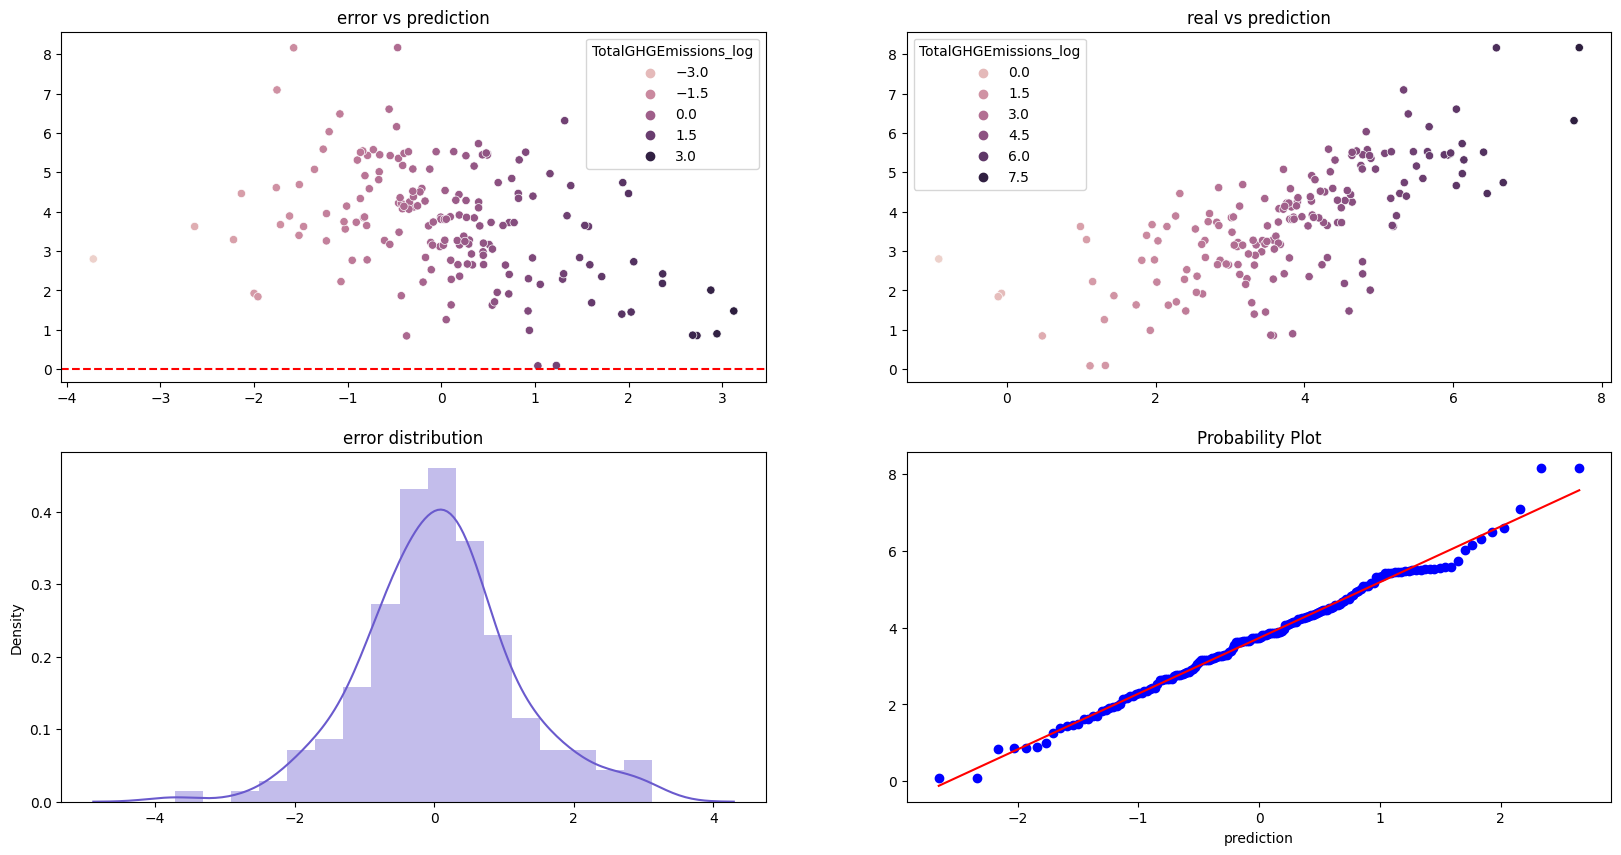

In [11]:
regression_visualizers(get_model='GradientBoostingRegressor_gridsearch', X_test=X_test, y_test=y_test, get_folder='../DATA/pickle/TotalGHGEmissions/withoutlieaires//withoutENERGYSTARScore/')

Métrique de performance pour le modèle DummyRegressor_gridsearch.pkl :
R²: -0.026487524562185394
RMSE: 1.4516280411916735
MAE: 1.1228725488260956
MSE: 2.1072239699739748


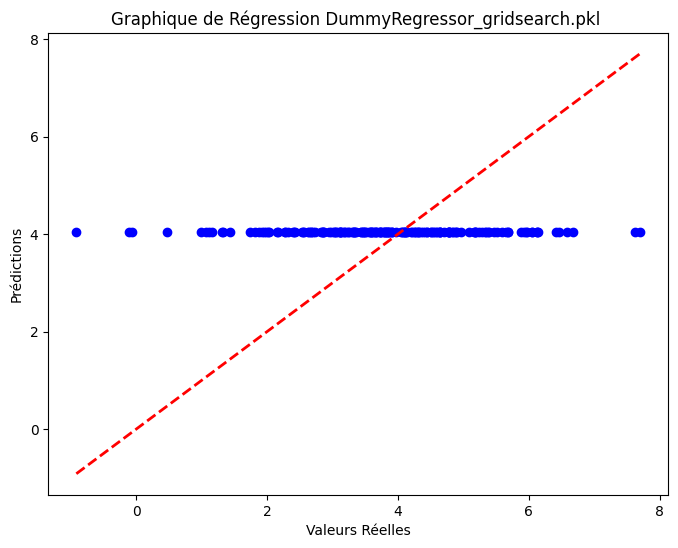

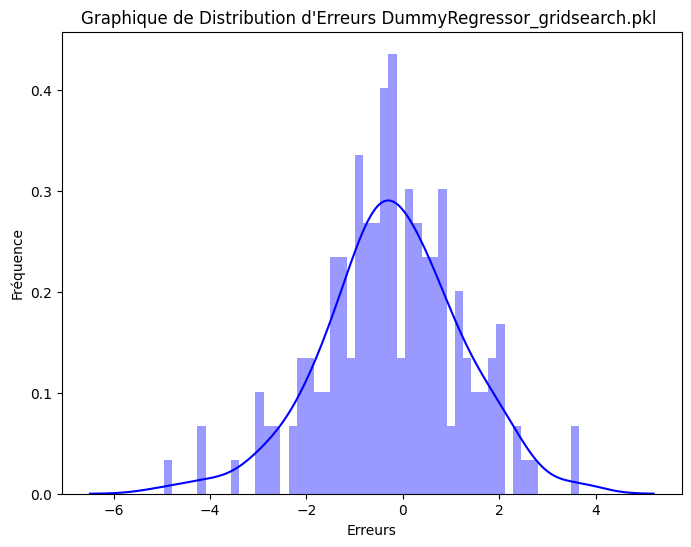

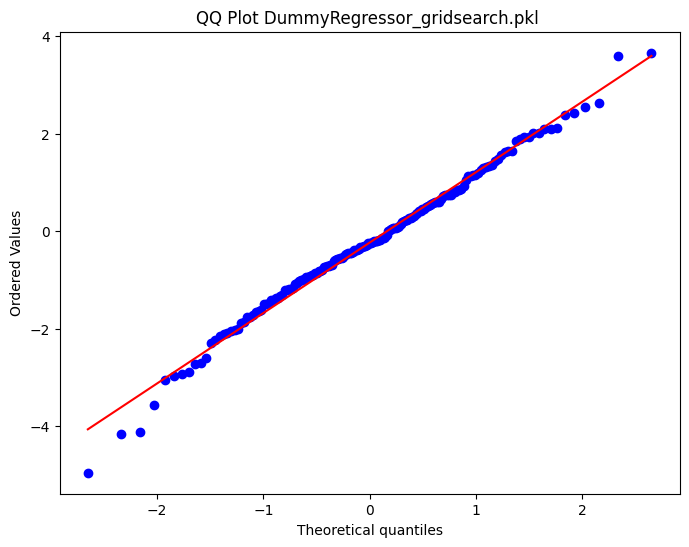

Métrique de performance pour le modèle DummyRegressor_randomsearch.pkl :
R²: -0.026487524562185394
RMSE: 1.4516280411916735
MAE: 1.1228725488260956
MSE: 2.1072239699739748


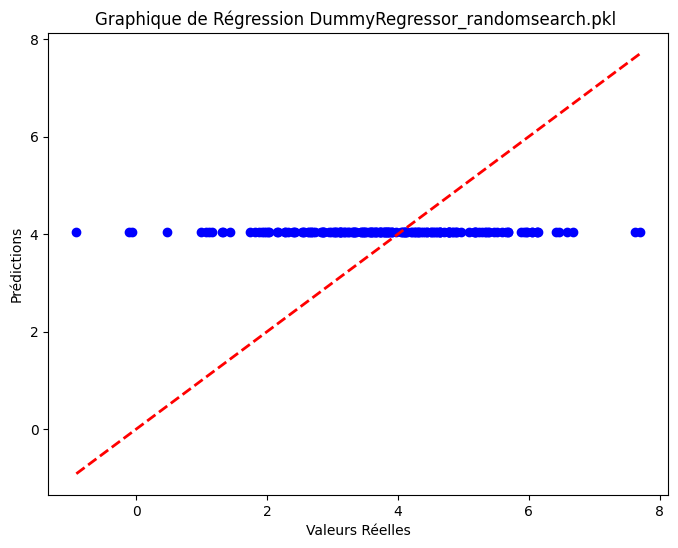

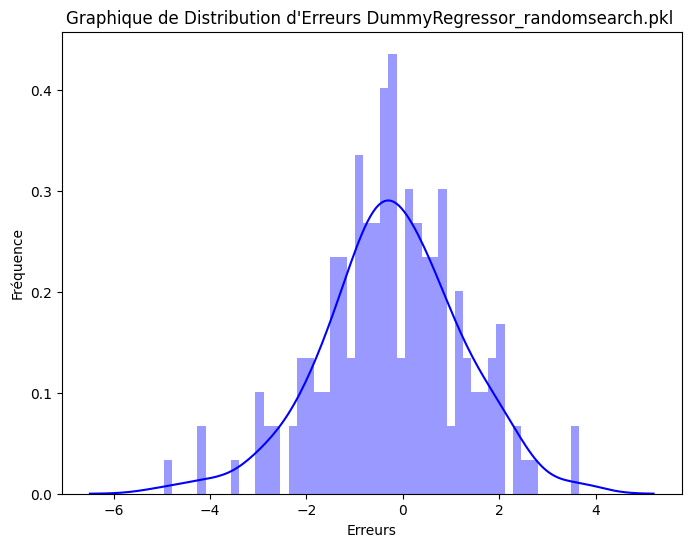

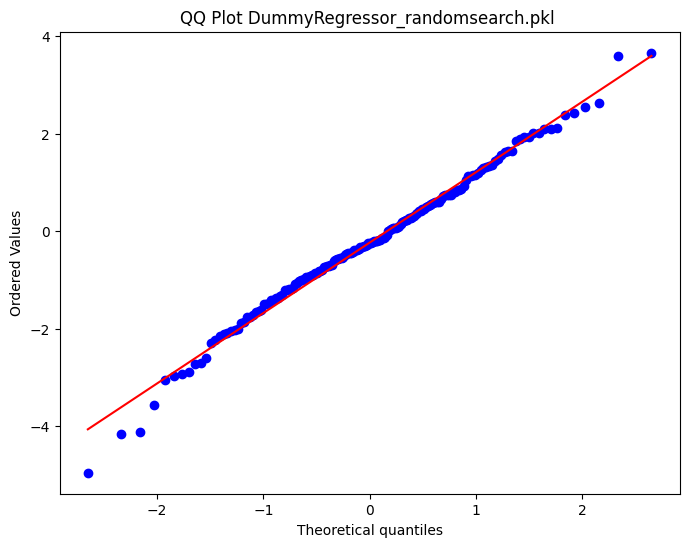

Métrique de performance pour le modèle DummyRegressor_standard.pkl :
R²: -0.026487524562185394
RMSE: 1.4516280411916735
MAE: 1.1228725488260956
MSE: 2.1072239699739748


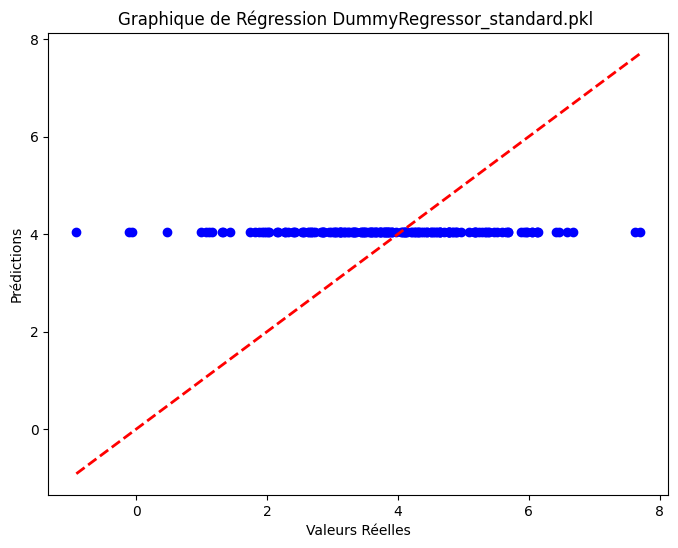

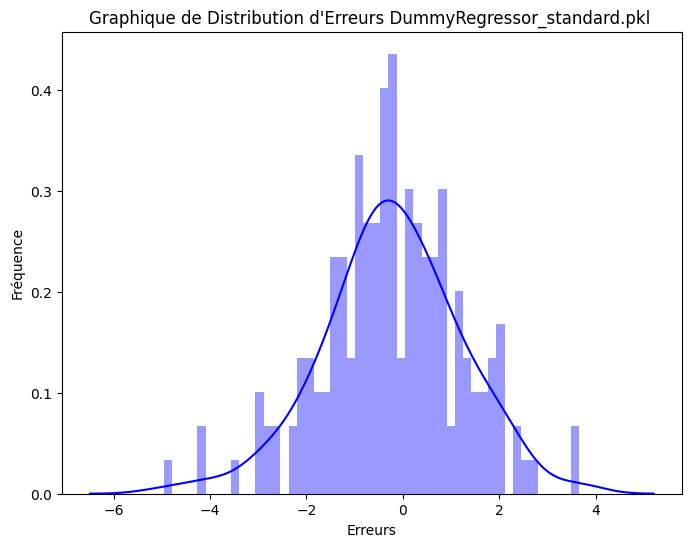

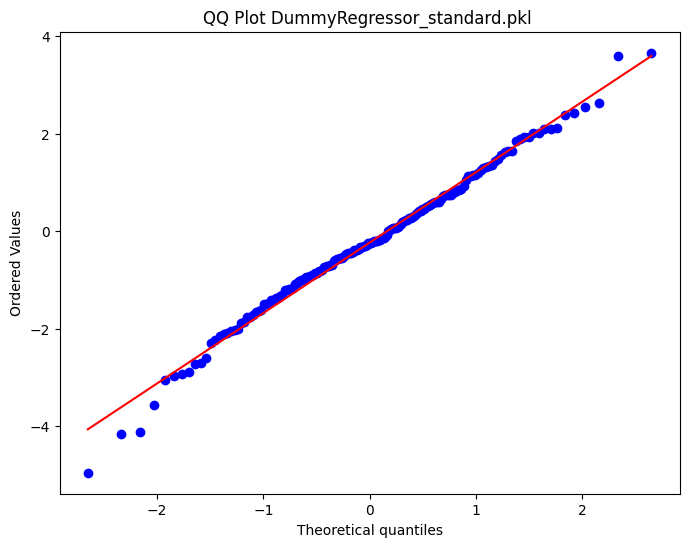

Métrique de performance pour le modèle ElasticNet_gridsearch.pkl :
R²: 0.46238413938841494
RMSE: 1.0505447275635653
MAE: 0.8031321616720695
MSE: 1.1036442246116056


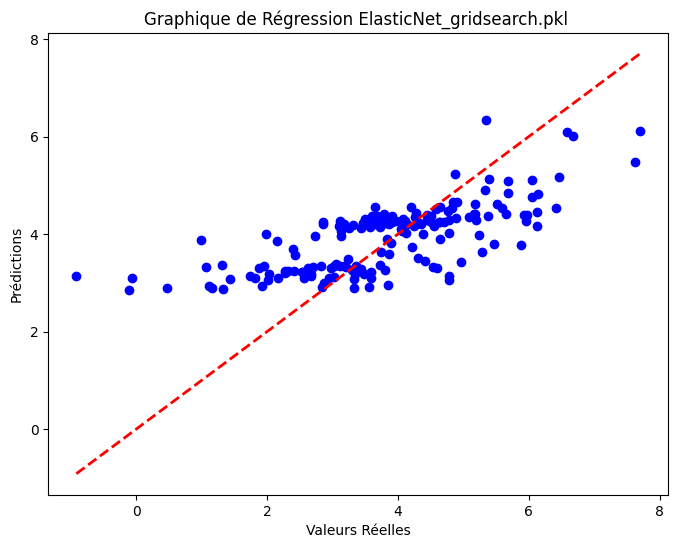

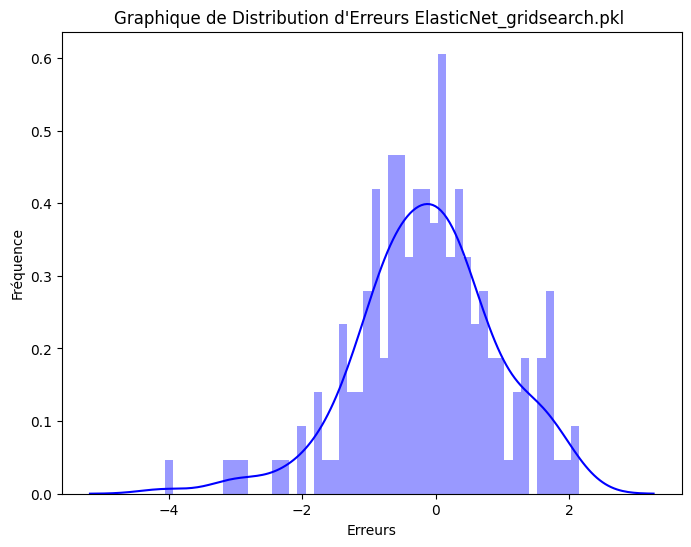

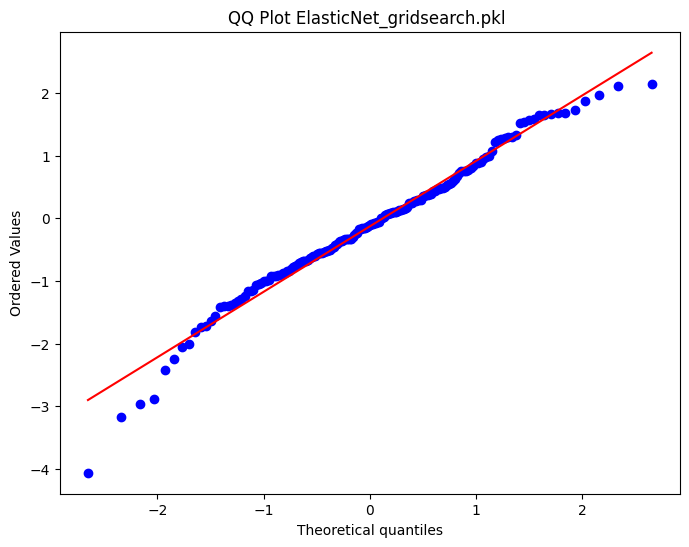

Métrique de performance pour le modèle ElasticNet_randomsearch.pkl :
R²: 0.46238413938841494
RMSE: 1.0505447275635653
MAE: 0.8031321616720695
MSE: 1.1036442246116056


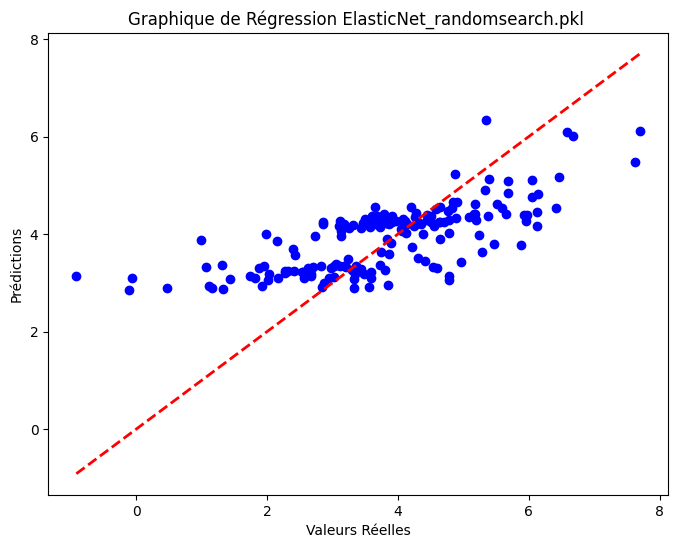

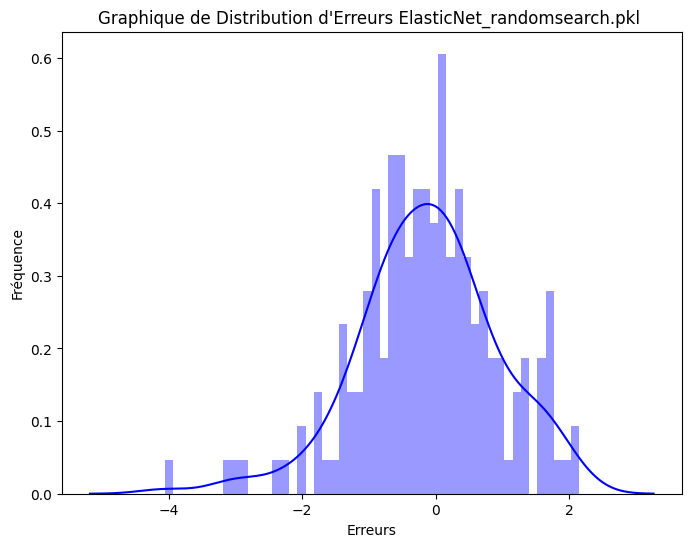

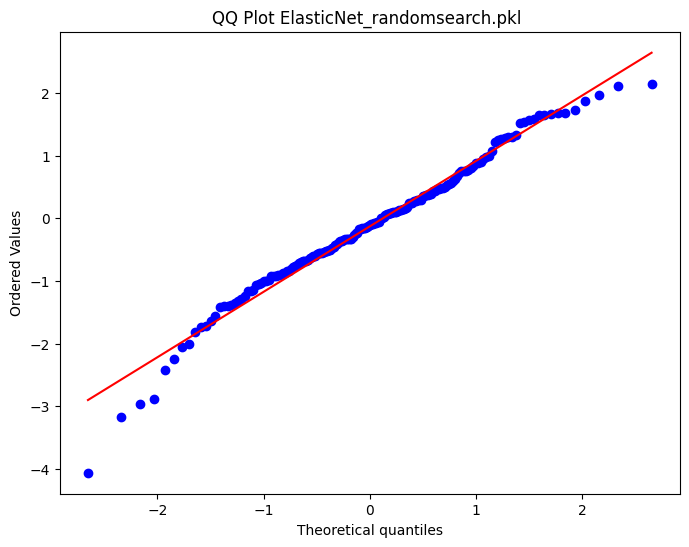

Métrique de performance pour le modèle ElasticNet_standard.pkl :
R²: 0.0797730410846772
RMSE: 1.3744406373476568
MAE: 1.055050235383558
MSE: 1.889087065592633


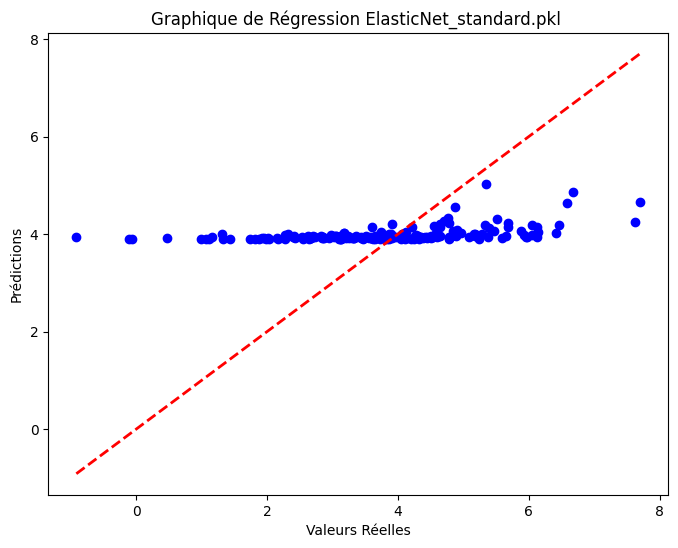

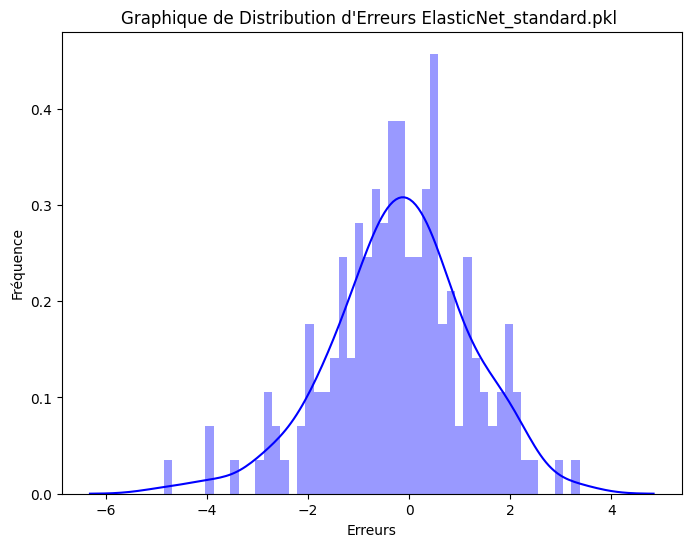

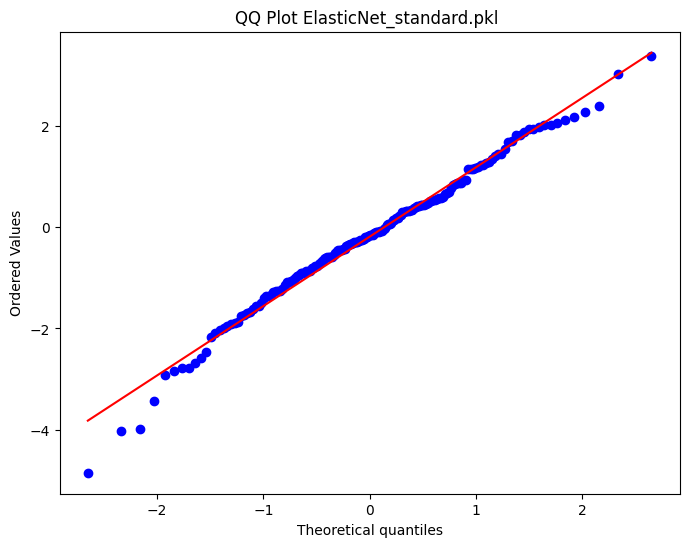

Métrique de performance pour le modèle ExtraTreesRegressor_gridsearch.pkl :
R²: 0.6402470748482899
RMSE: 0.85937096836322
MAE: 0.6581824179002829
MSE: 0.7385184612655386


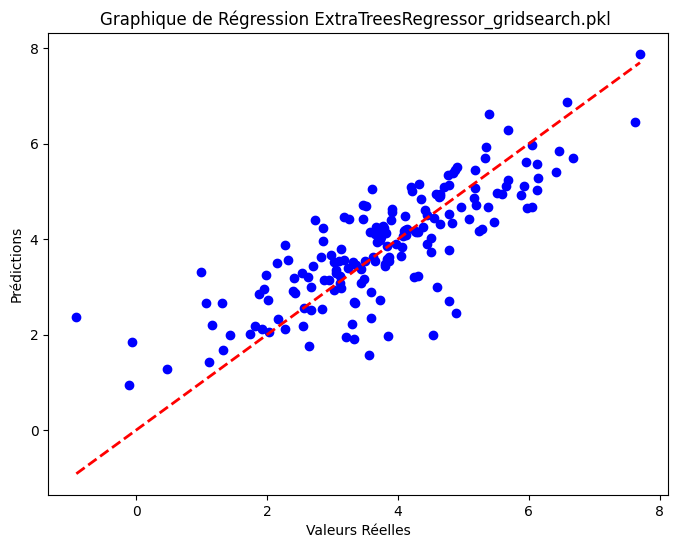

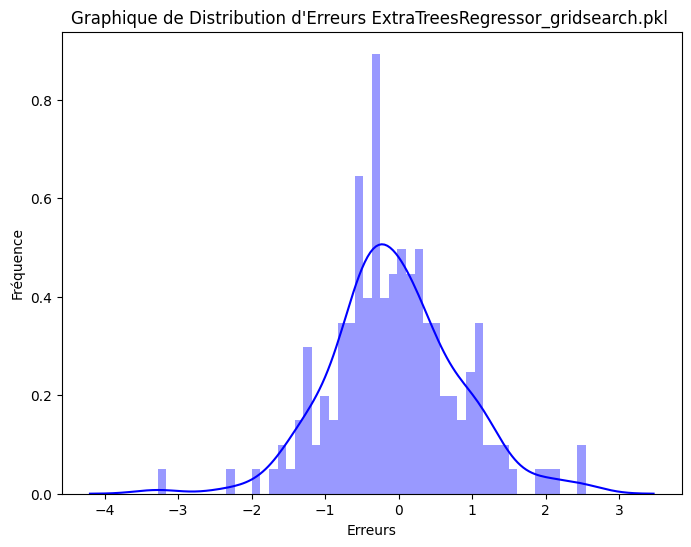

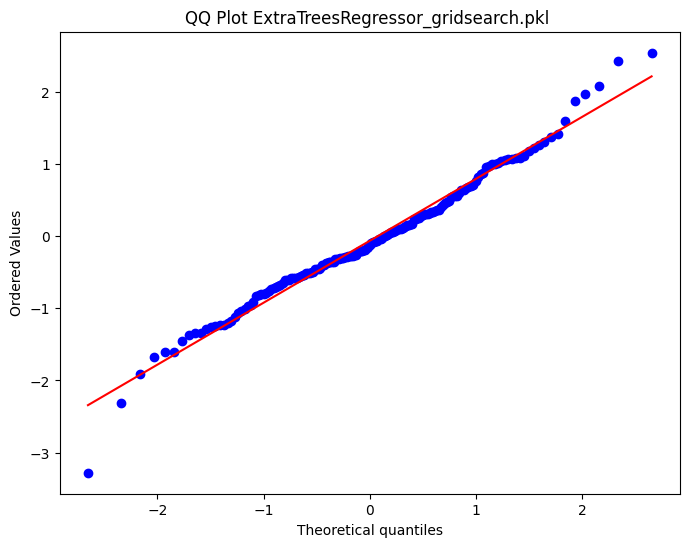

Métrique de performance pour le modèle ExtraTreesRegressor_randomsearch.pkl :
R²: 0.6467534406642339
RMSE: 0.8515643687878318
MAE: 0.6476412888422568
MSE: 0.7251618741890185


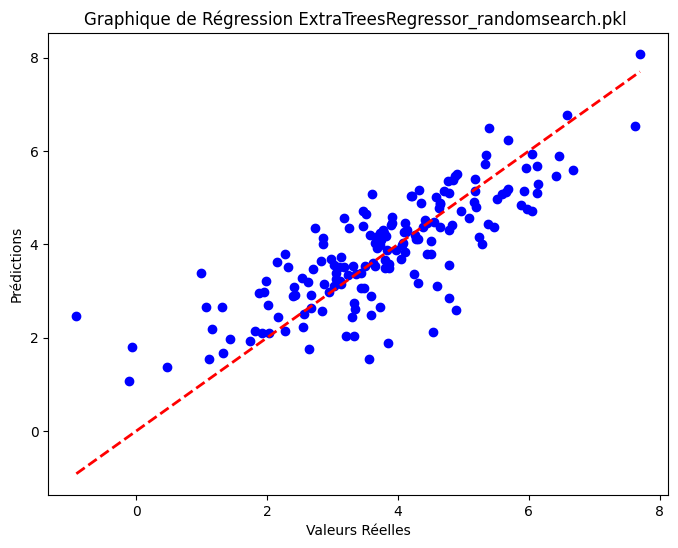

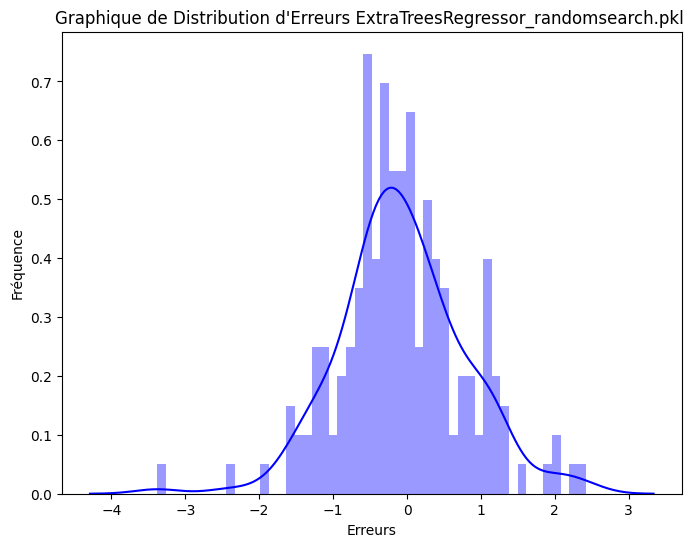

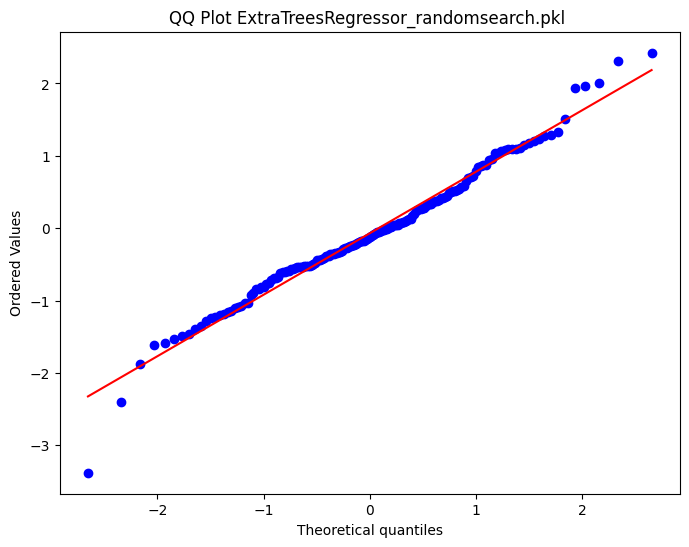

Métrique de performance pour le modèle ExtraTreesRegressor_standard.pkl :
R²: 0.6451141307070322
RMSE: 0.8535380074289417
MAE: 0.6504989072732464
MSE: 0.7285271301257681


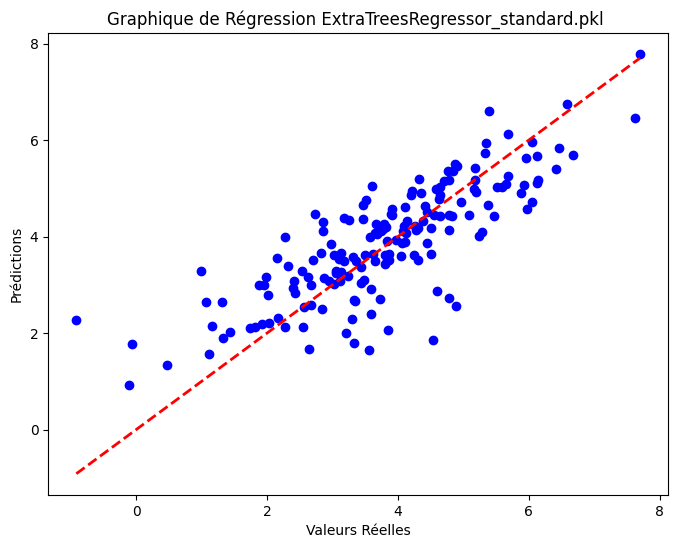

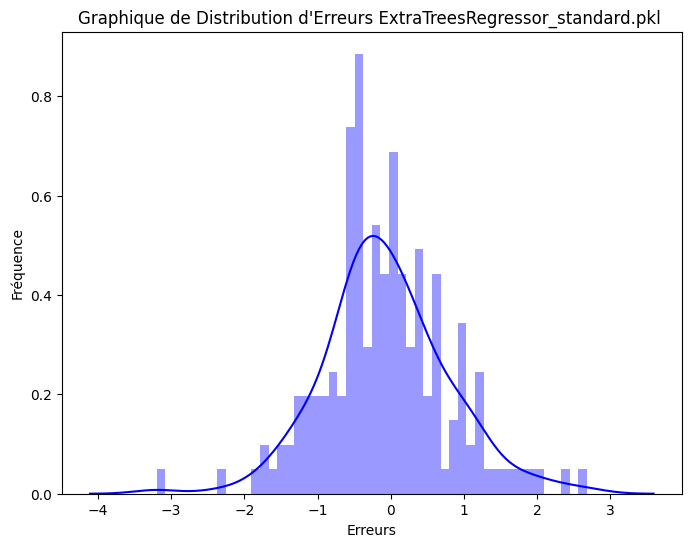

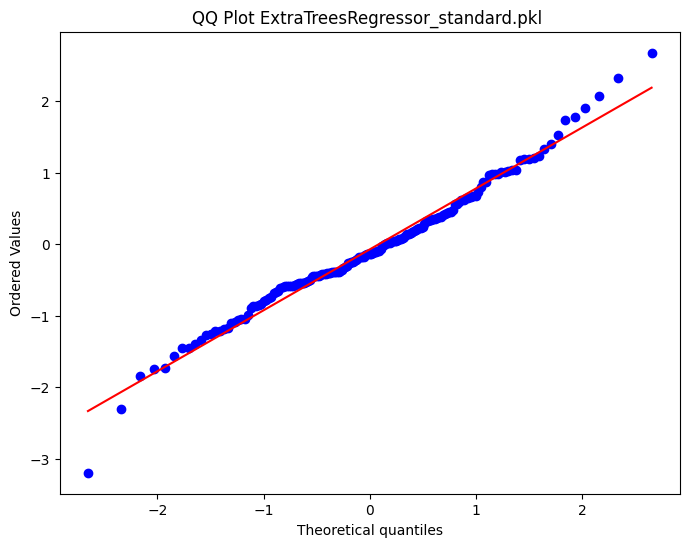

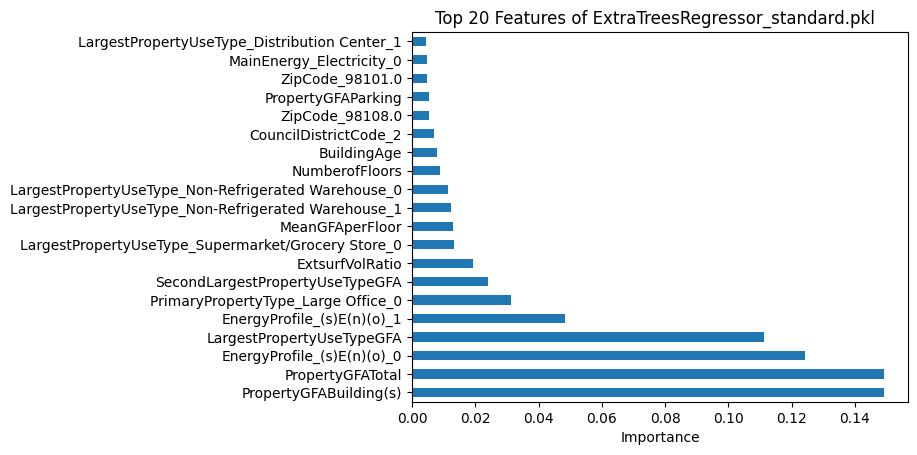

Métrique de performance pour le modèle GradientBoostingRegressor_gridsearch.pkl :
R²: 0.418852500734027
RMSE: 1.0922491057239931
MAE: 0.8230730470299227
MSE: 1.193008108954863


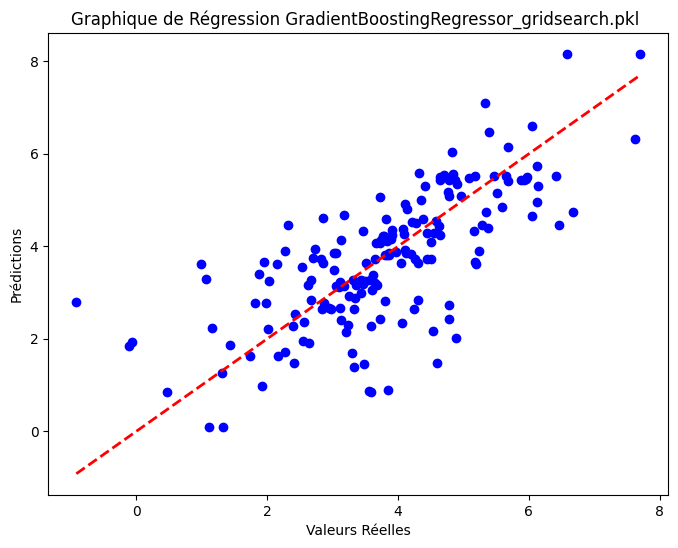

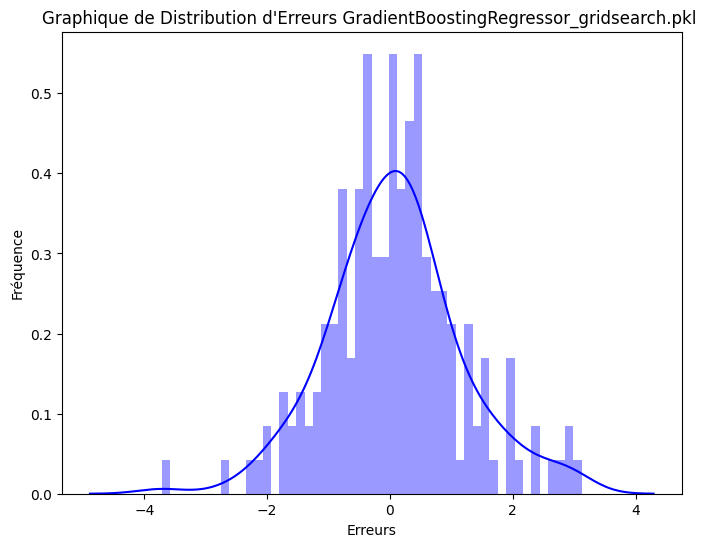

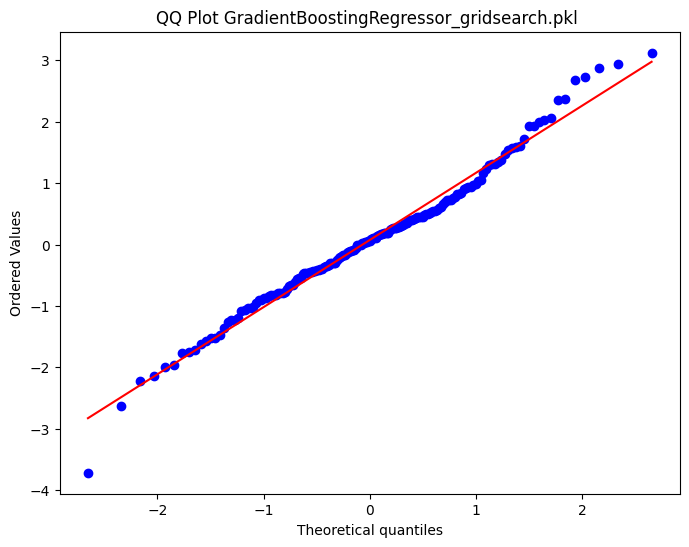

Métrique de performance pour le modèle GradientBoostingRegressor_randomsearch.pkl :
R²: 0.418852500734027
RMSE: 1.0922491057239931
MAE: 0.8230730470299227
MSE: 1.193008108954863


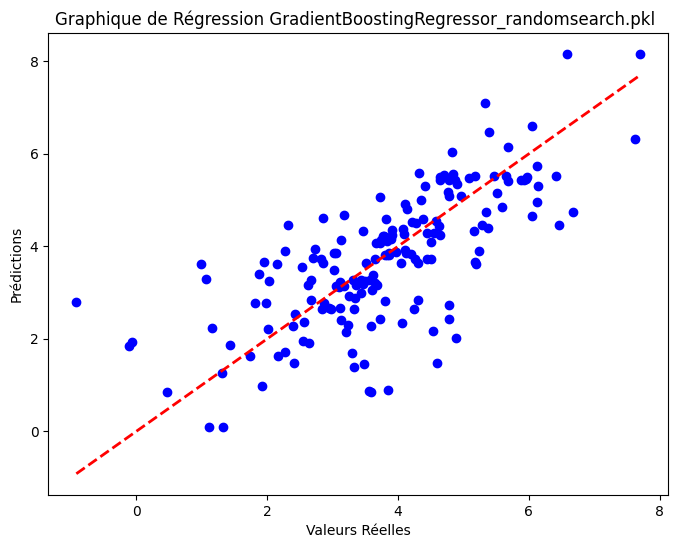

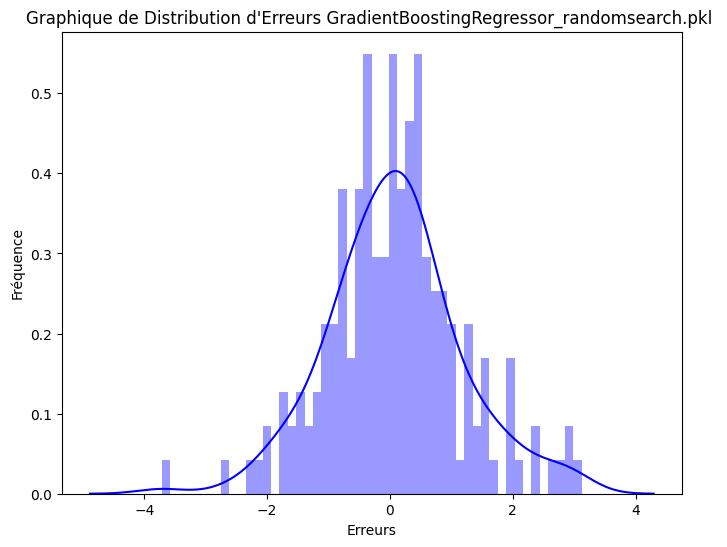

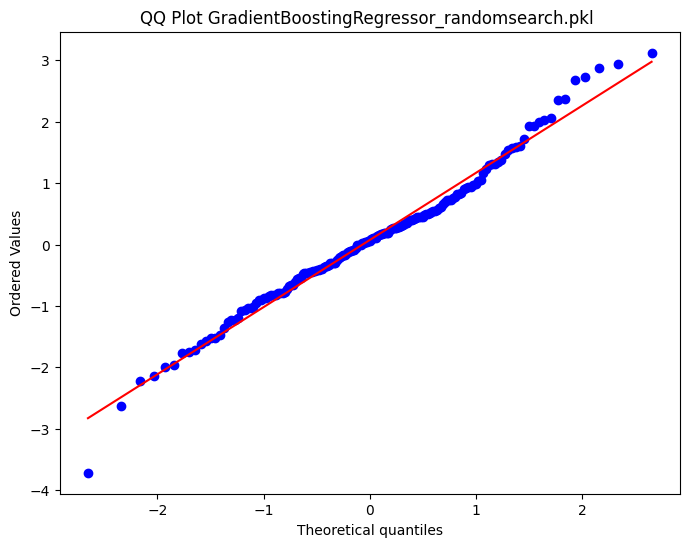

Métrique de performance pour le modèle GradientBoostingRegressor_standard.pkl :
R²: 0.6761520045379787
RMSE: 0.8153594663708215
MAE: 0.6265664600932717
MSE: 0.6648110594005107


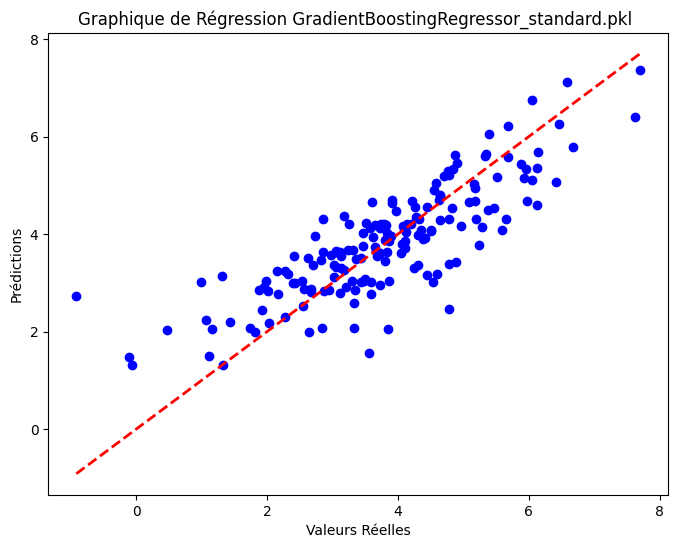

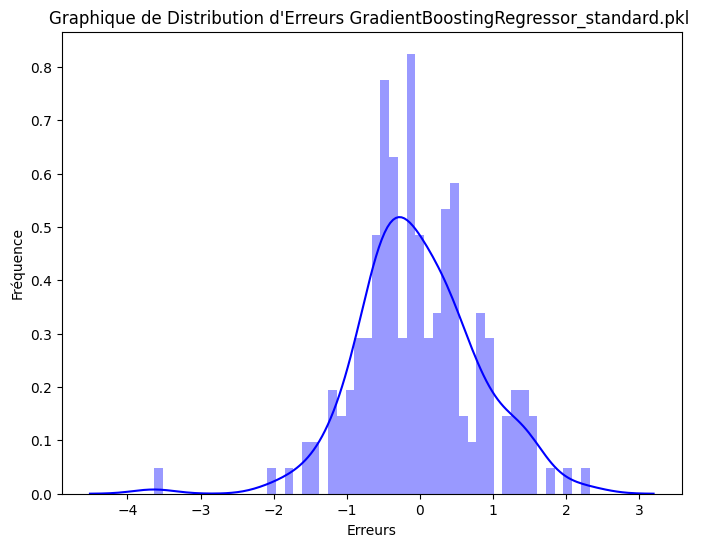

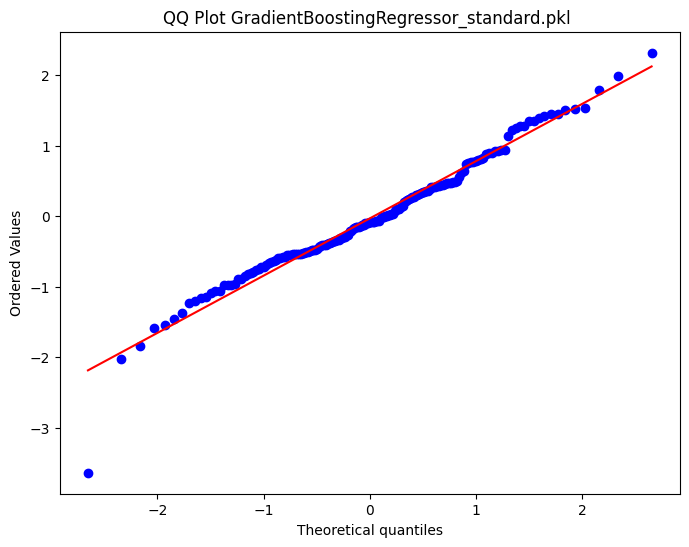

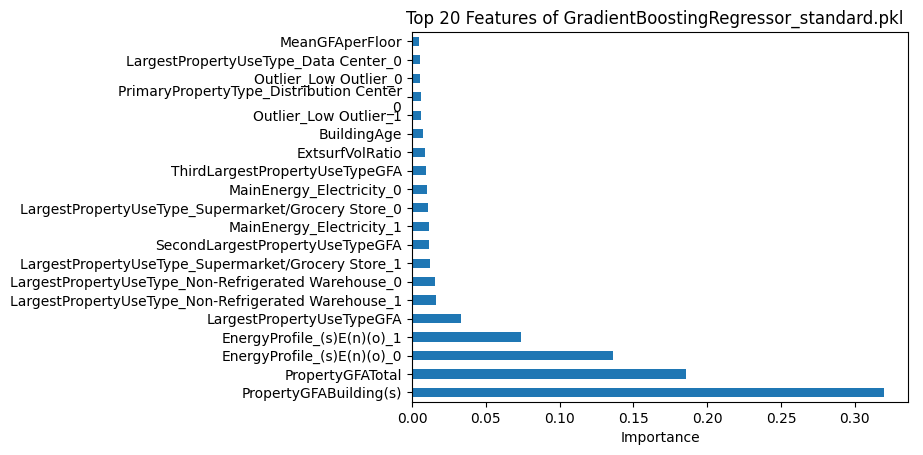

Métrique de performance pour le modèle KNeighborsRegressor_gridsearch.pkl :
R²: 0.5204756187059618
RMSE: 0.992164897970337
MAE: 0.7627751214033076
MSE: 0.9843911847644893


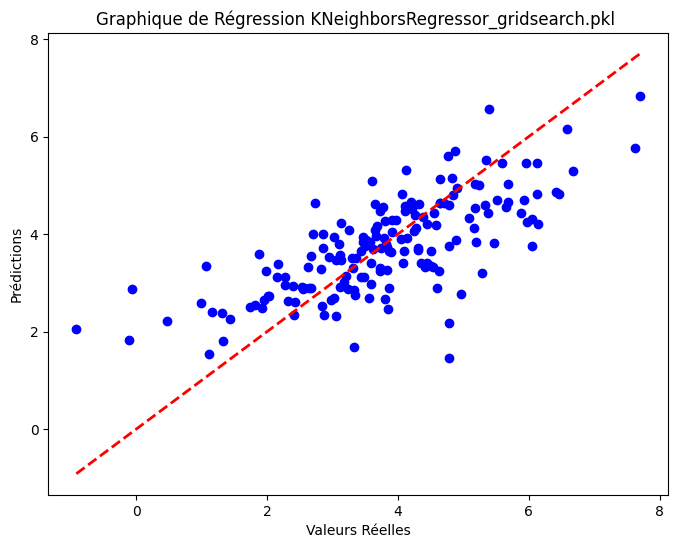

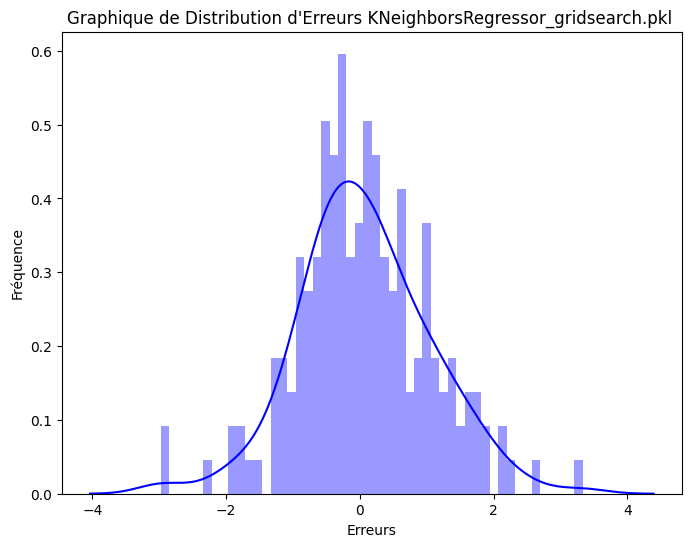

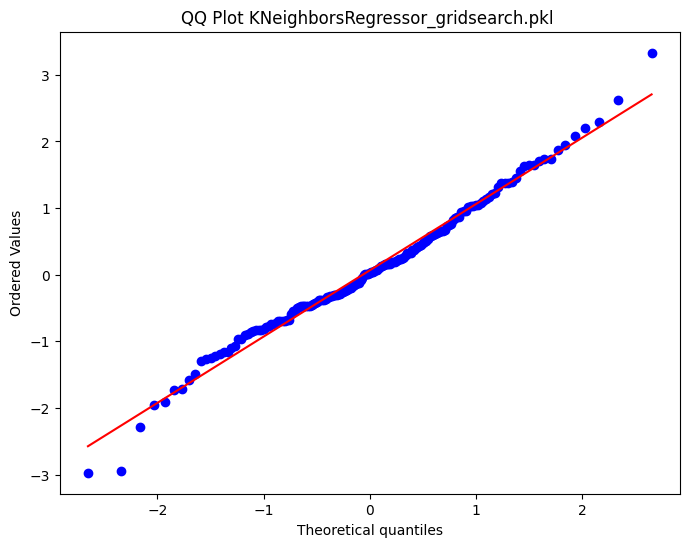

Métrique de performance pour le modèle KNeighborsRegressor_randomsearch.pkl :
R²: 0.5148099894409165
RMSE: 0.9980089511554229
MAE: 0.7606918449187142
MSE: 0.9960218665863472


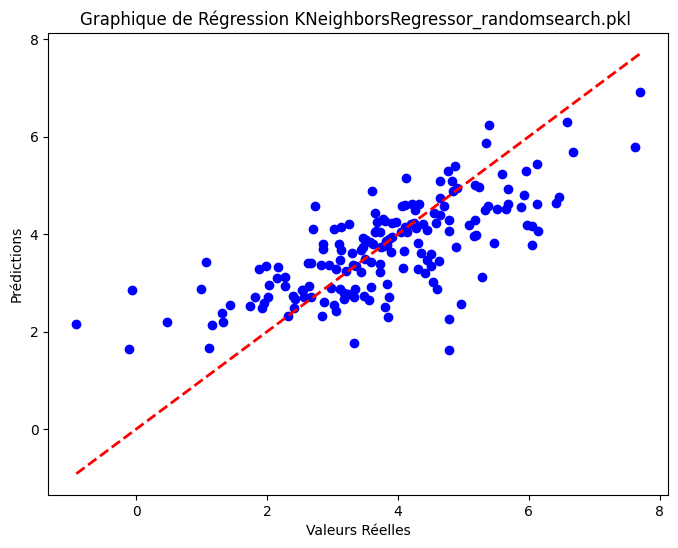

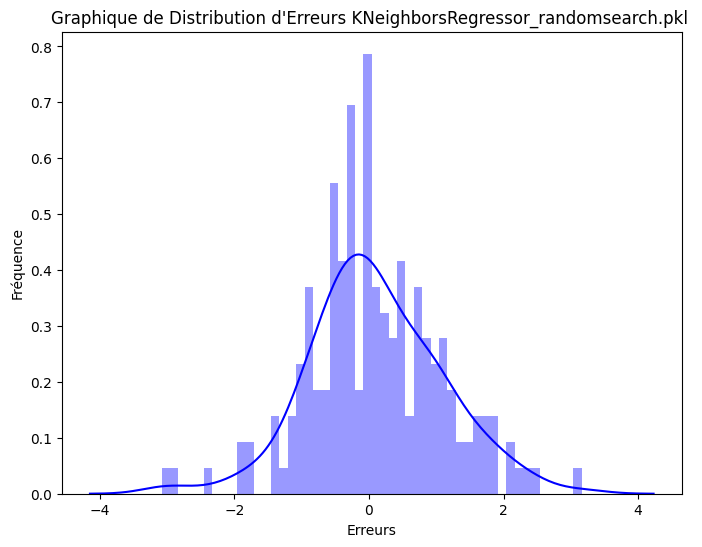

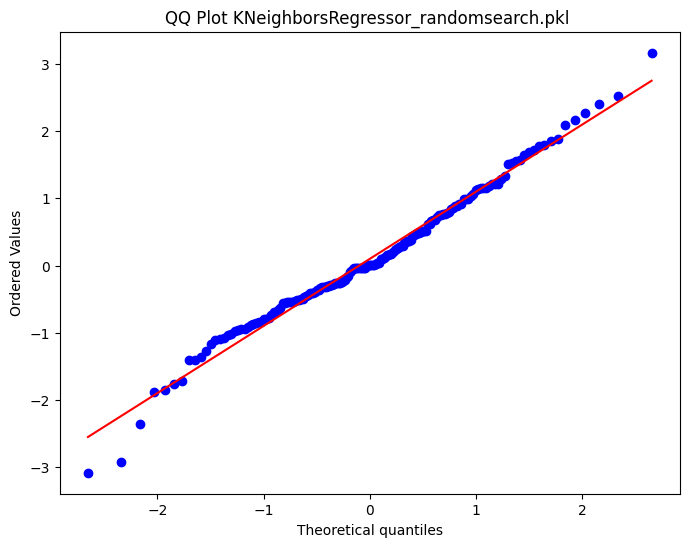

Métrique de performance pour le modèle KNeighborsRegressor_standard.pkl :
R²: 0.5123224365536823
RMSE: 1.0005640595390457
MAE: 0.7727684081531991
MSE: 1.0011284372412548


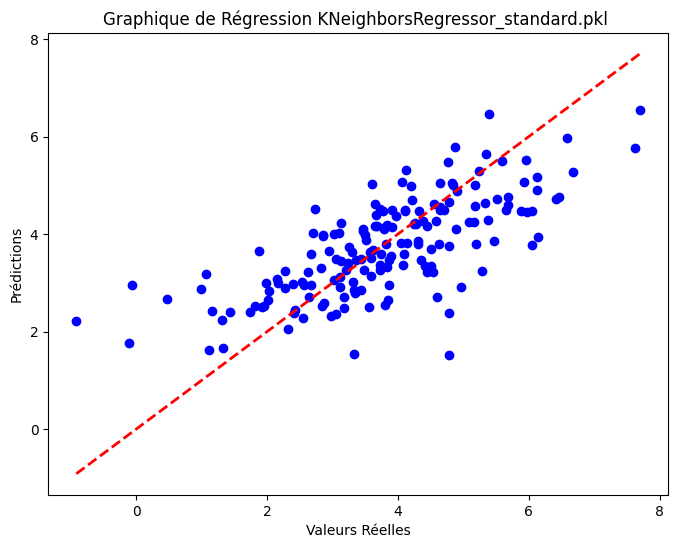

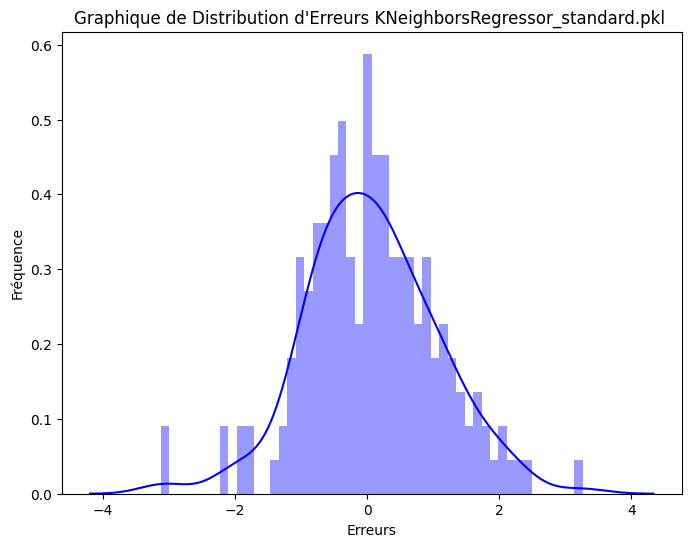

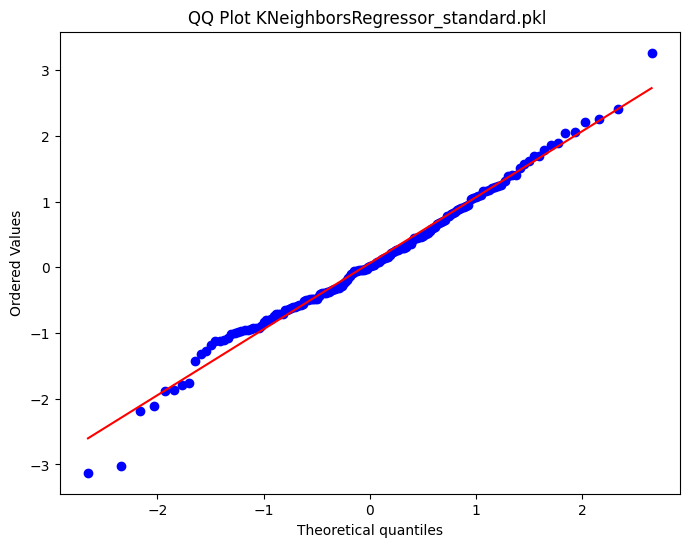

Métrique de performance pour le modèle Lasso_gridsearch.pkl :
R²: 0.3935825291817555
RMSE: 1.1157434950723975
MAE: 0.8451901585951932
MSE: 1.2448835467963688


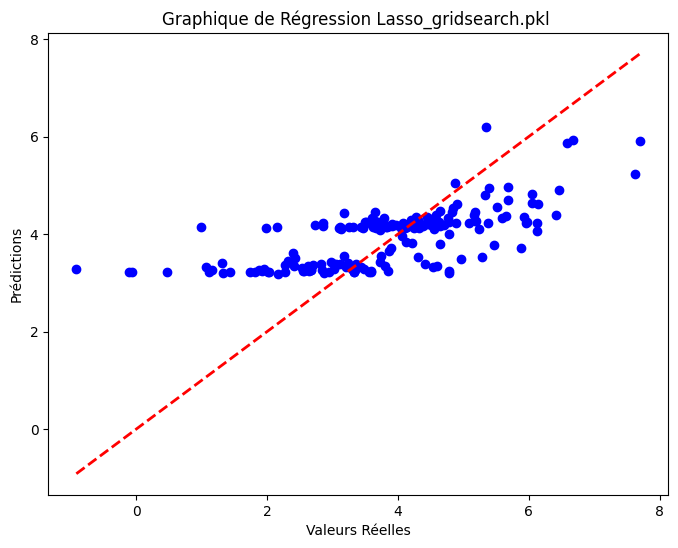

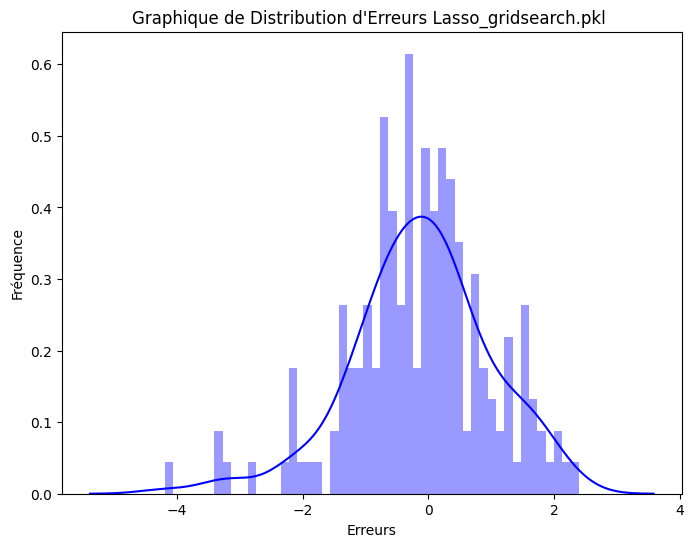

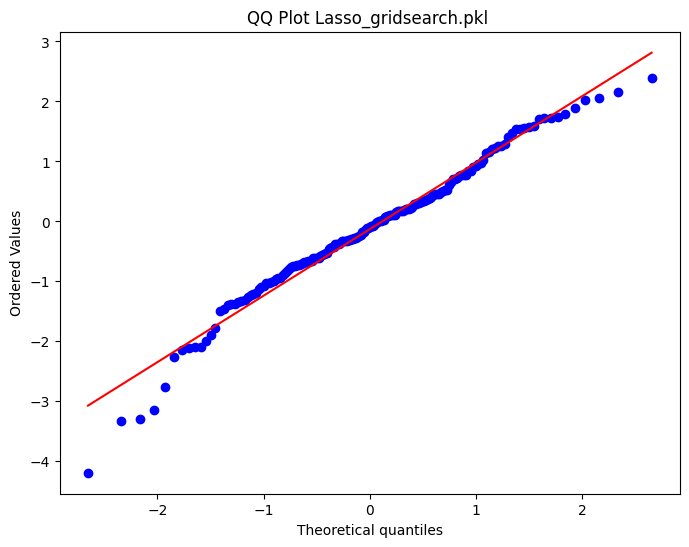

Métrique de performance pour le modèle Lasso_randomsearch.pkl :
R²: 0.3935825291817555
RMSE: 1.1157434950723975
MAE: 0.8451901585951932
MSE: 1.2448835467963688


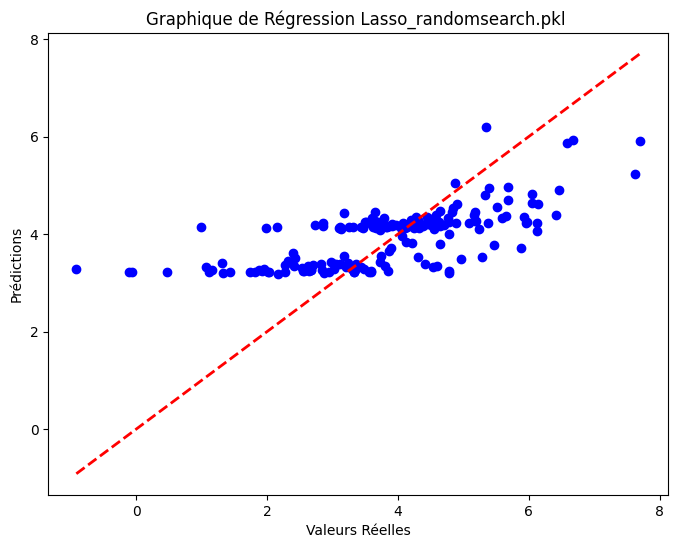

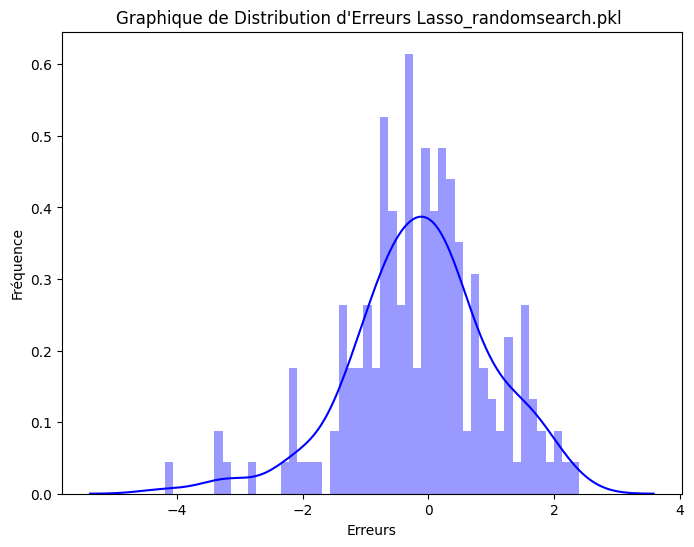

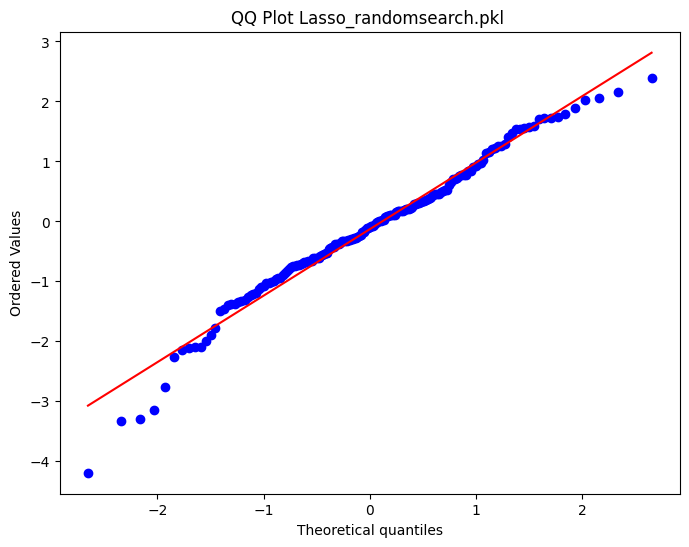

Métrique de performance pour le modèle Lasso_standard.pkl :
R²: -0.026487524562185394
RMSE: 1.4516280411916735
MAE: 1.1228725488260956
MSE: 2.1072239699739748


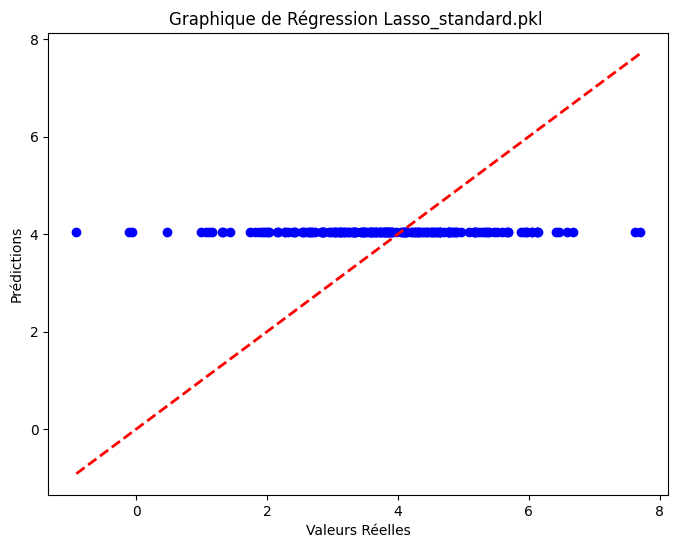

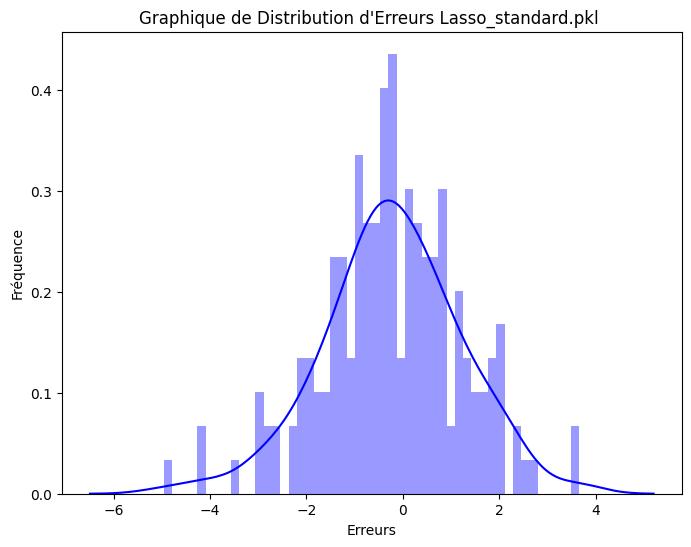

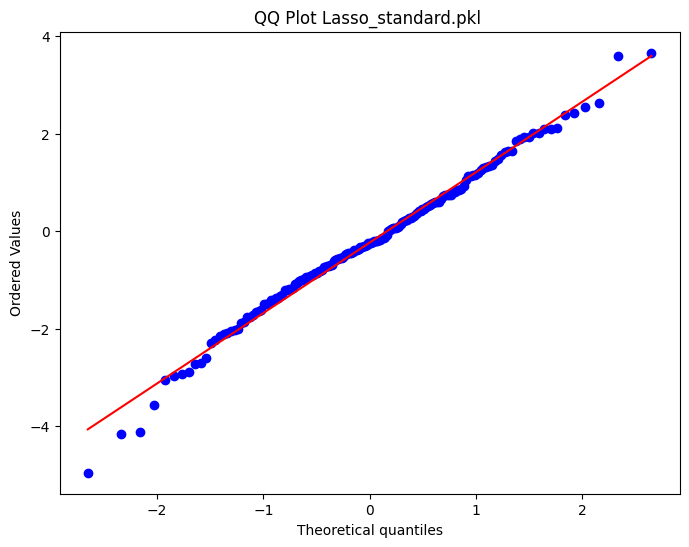

Métrique de performance pour le modèle LinearRegression_gridsearch.pkl :
R²: 0.5513188992273447
RMSE: 0.9597263072020363
MAE: 0.7359413845917134
MSE: 0.9210745847356575


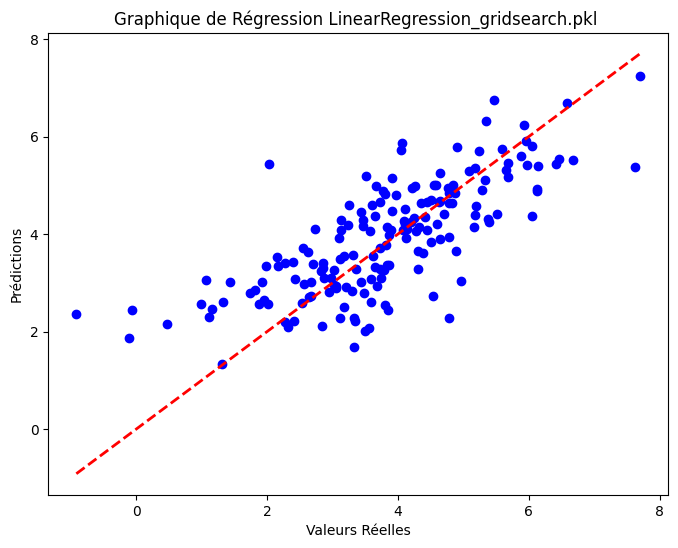

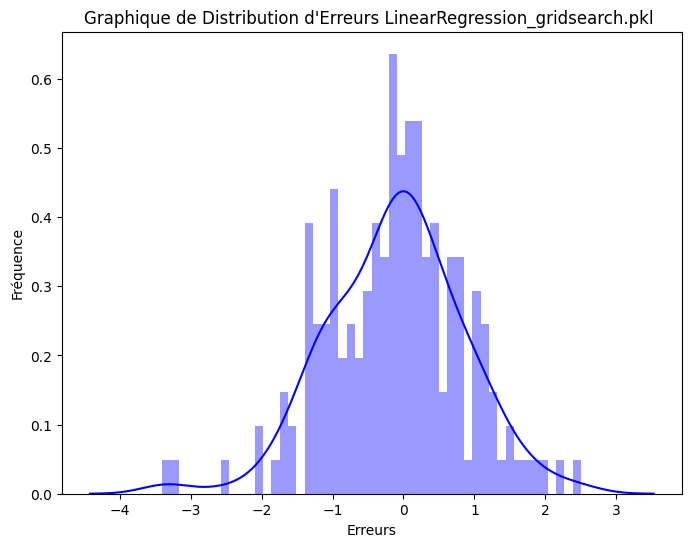

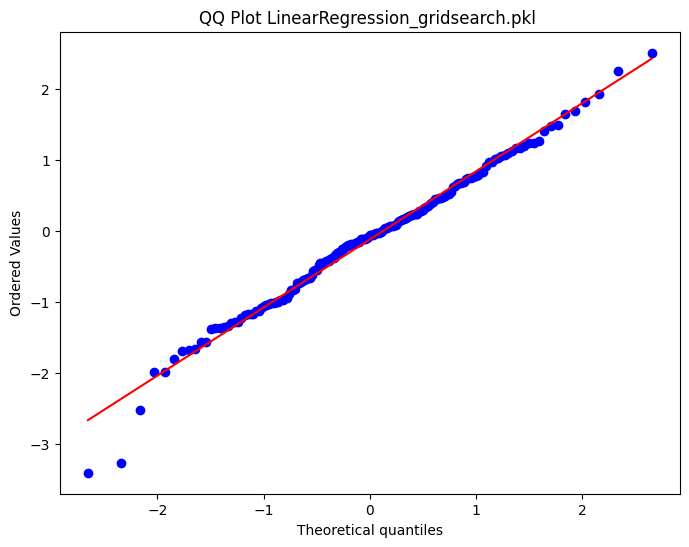

Métrique de performance pour le modèle LinearRegression_randomsearch.pkl :
R²: 0.5513188992273447
RMSE: 0.9597263072020363
MAE: 0.7359413845917134
MSE: 0.9210745847356575


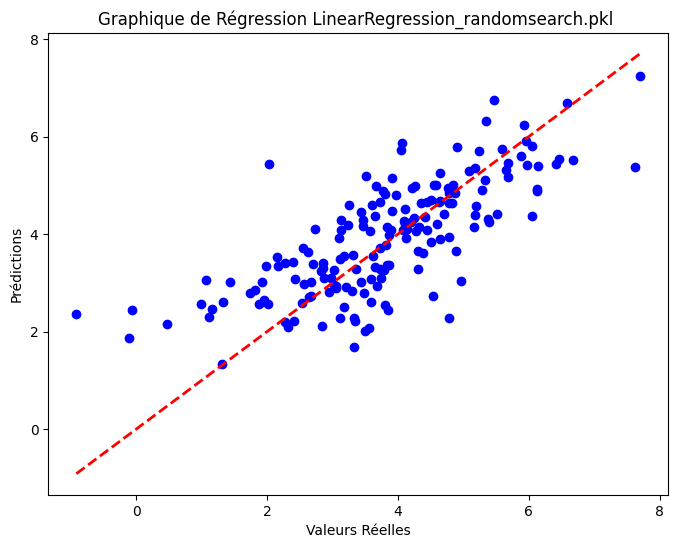

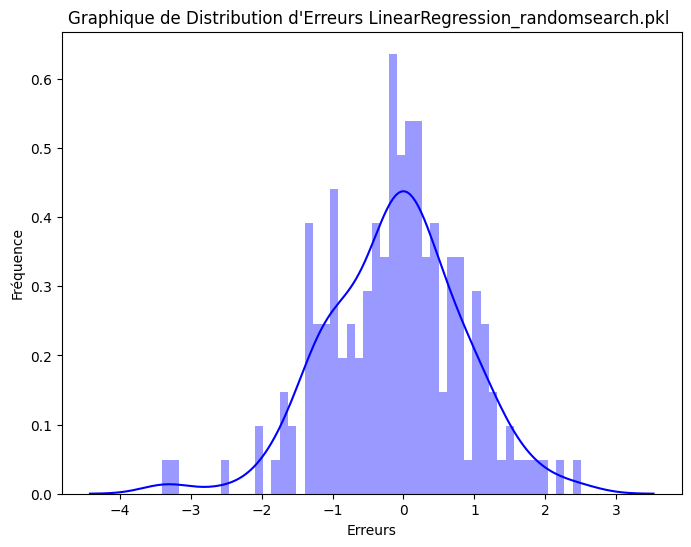

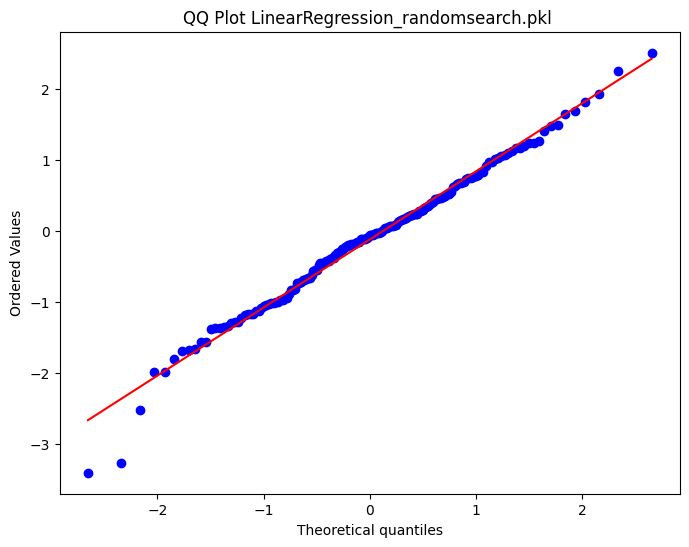

Métrique de performance pour le modèle LinearRegression_standard.pkl :
R²: -1.0244369260387916e+16
RMSE: 145017736.86975968
MAE: 30174751.537716754
MSE: 2.1030144006826856e+16


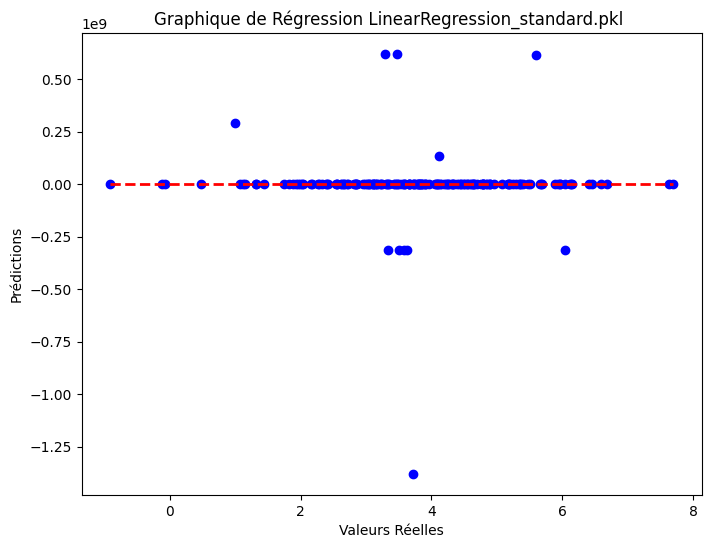

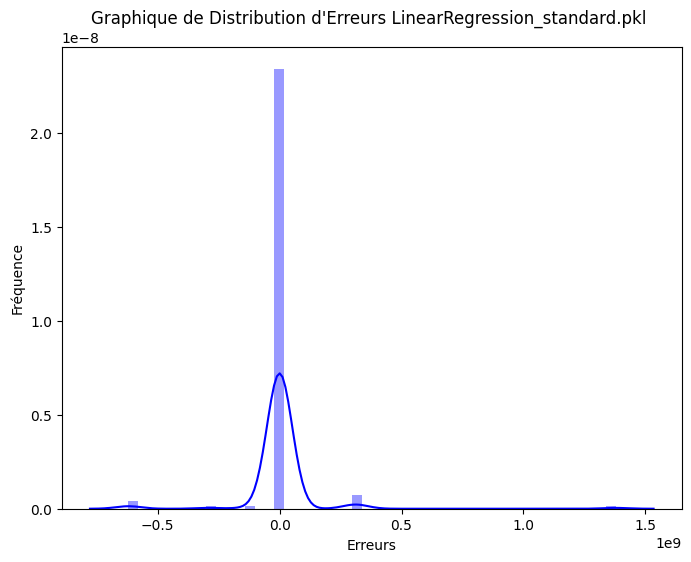

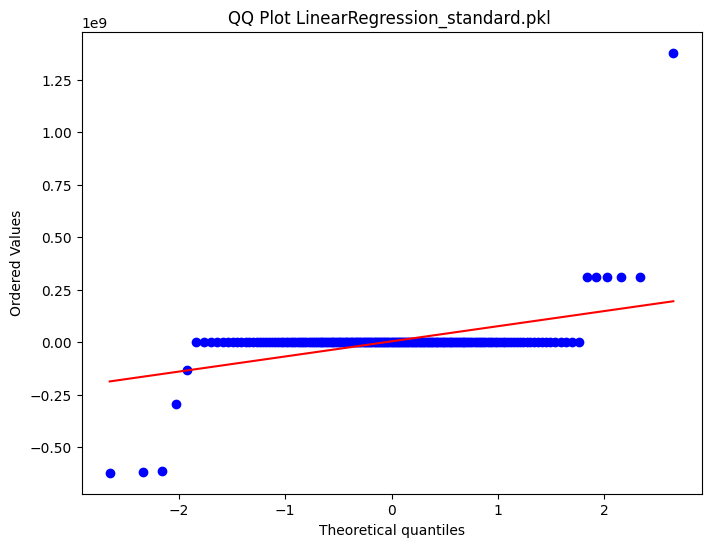

Métrique de performance pour le modèle RandomForestRegressor_gridsearch.pkl :
R²: 0.6556180133567348
RMSE: 0.840811658040345
MAE: 0.6440941310528654
MSE: 0.706964244296554


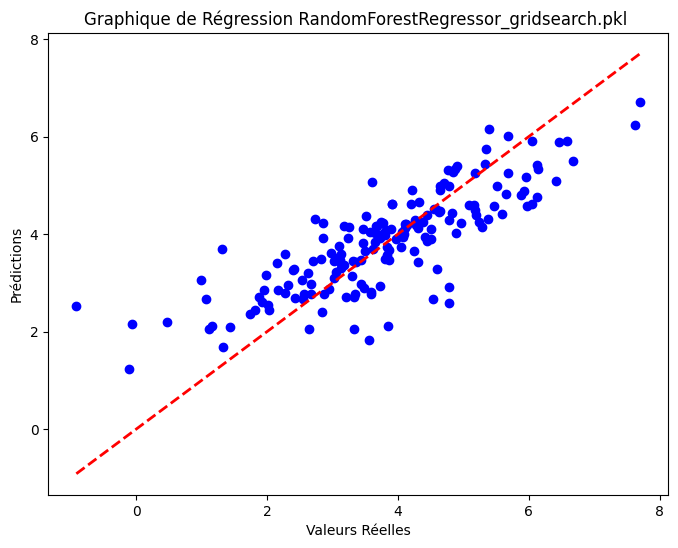

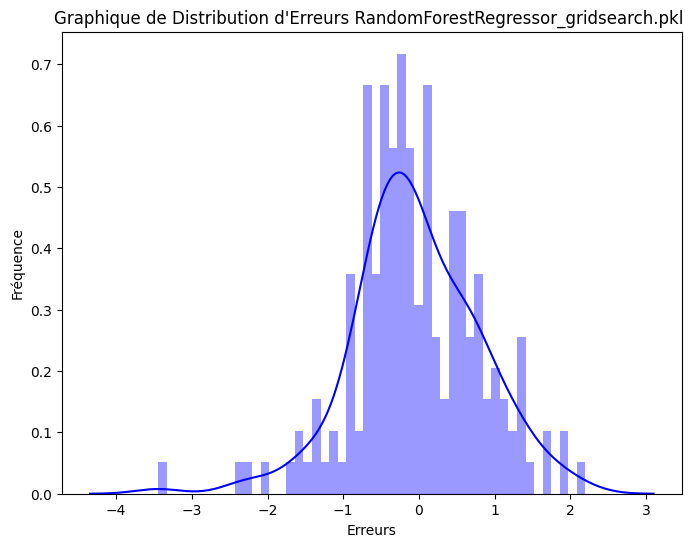

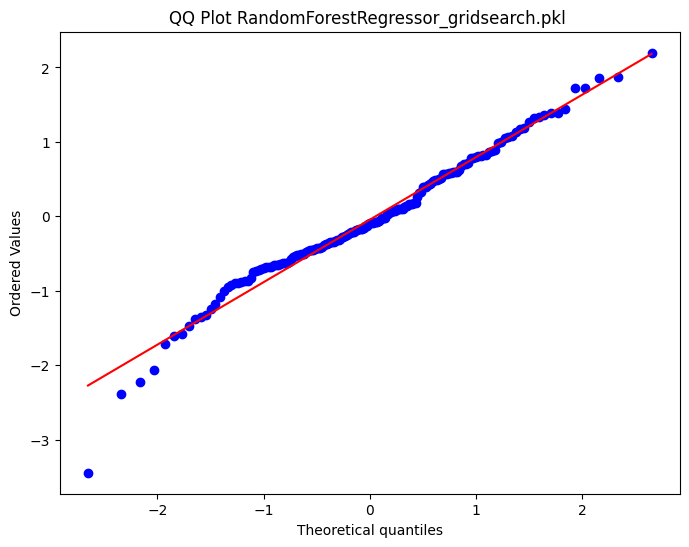

Métrique de performance pour le modèle RandomForestRegressor_randomsearch.pkl :
R²: 0.6556180133567348
RMSE: 0.840811658040345
MAE: 0.6440941310528654
MSE: 0.706964244296554


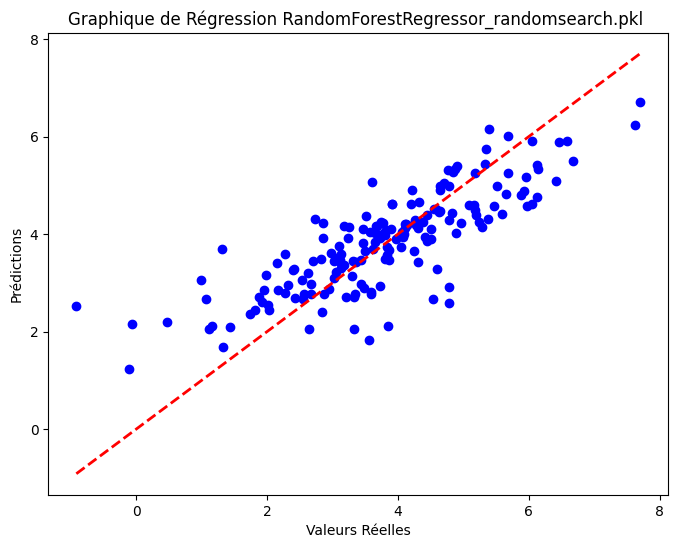

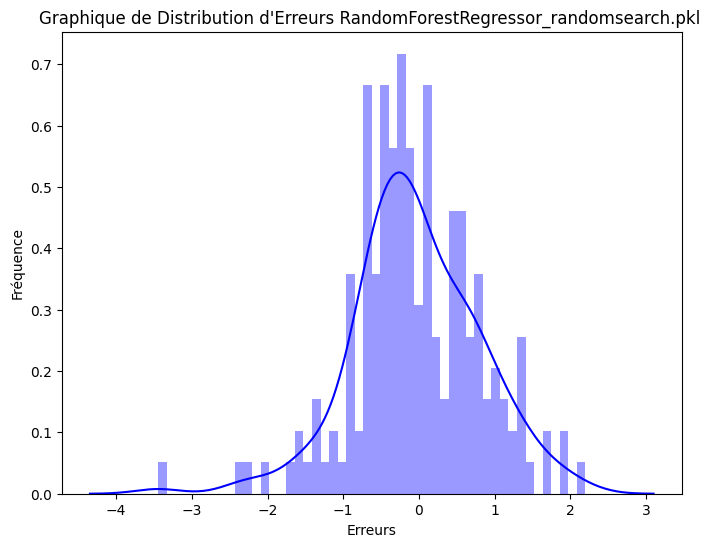

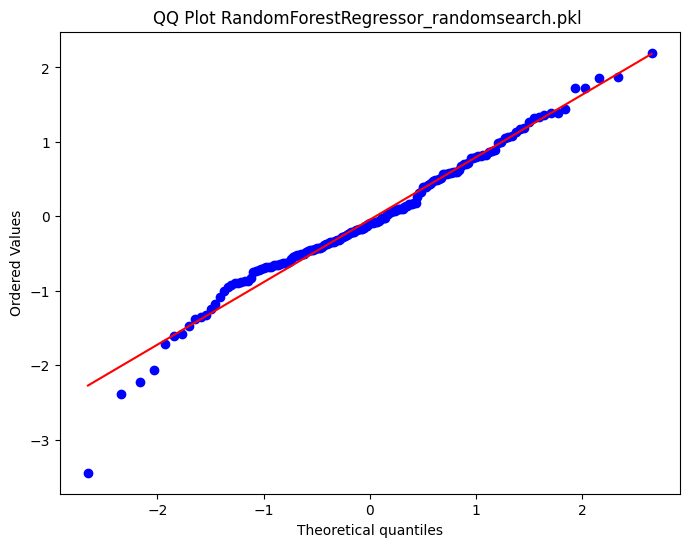

Métrique de performance pour le modèle RandomForestRegressor_standard.pkl :
R²: 0.6436752614330246
RMSE: 0.8552665734088509
MAE: 0.6523492417883813
MSE: 0.7314809115905173


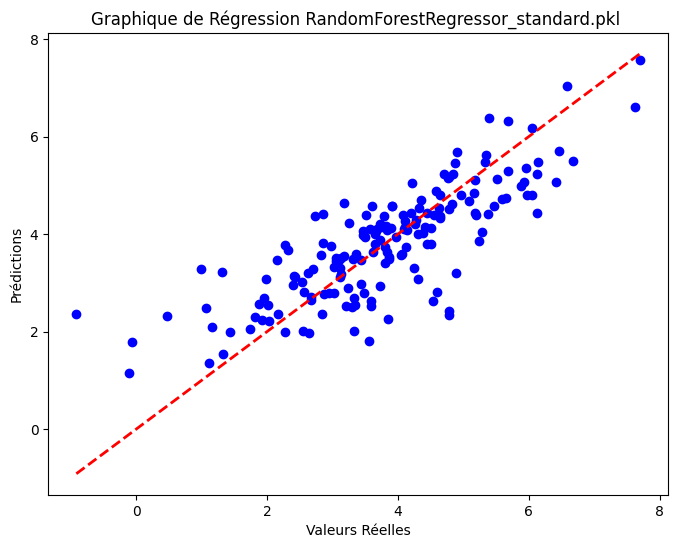

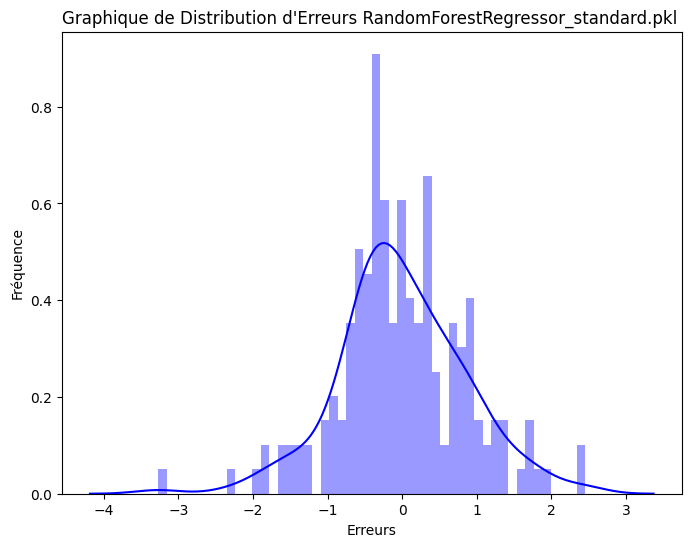

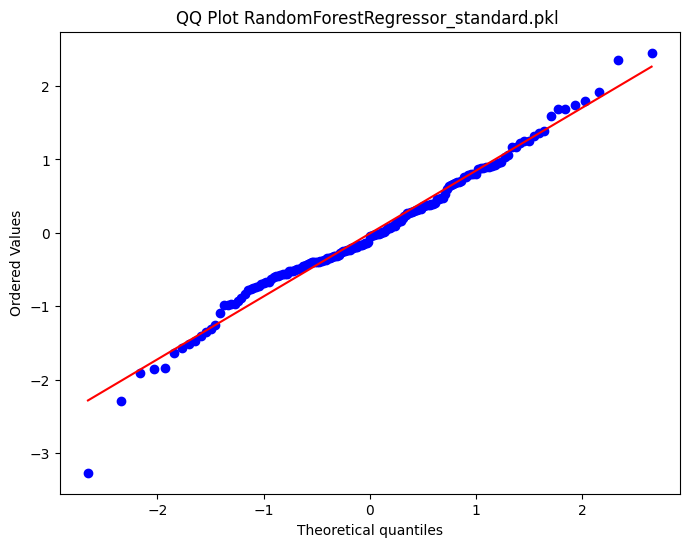

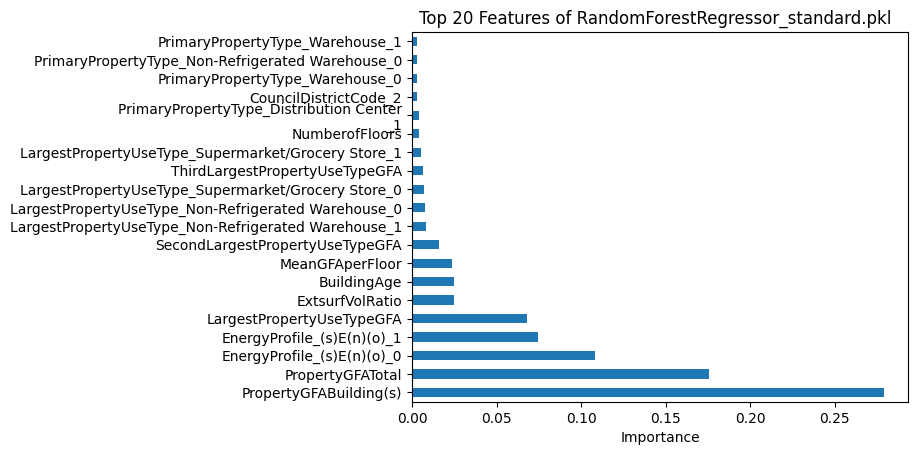

Métrique de performance pour le modèle Ridge_gridsearch.pkl :
R²: 0.6257366266782431
RMSE: 0.8765307875000028
MAE: 0.685380821479193
MSE: 0.768306221435375


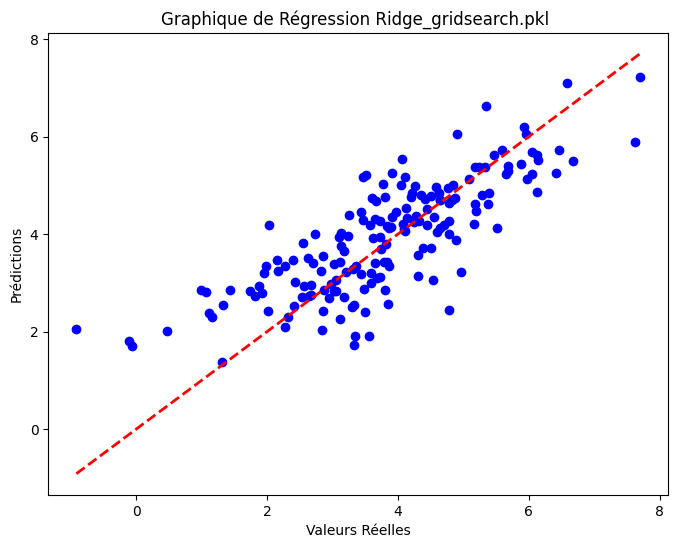

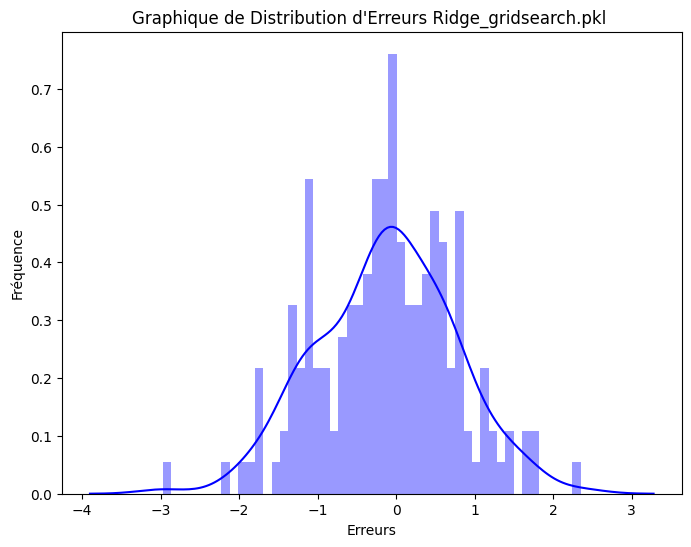

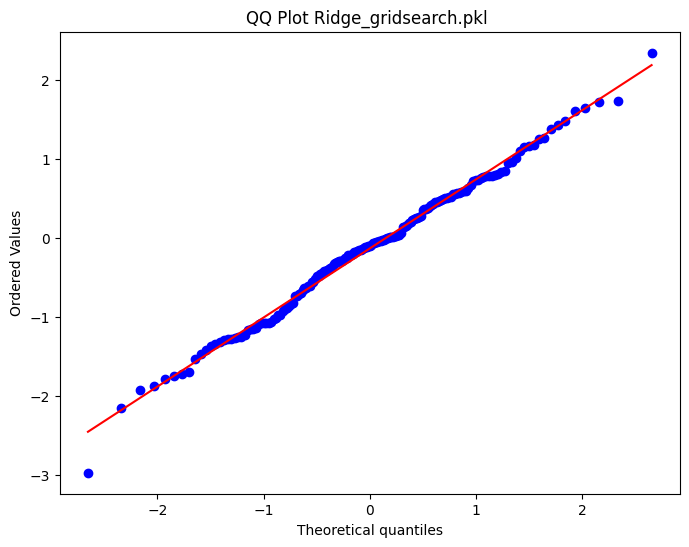

Métrique de performance pour le modèle Ridge_randomsearch.pkl :
R²: 0.6257366266782431
RMSE: 0.8765307875000028
MAE: 0.685380821479193
MSE: 0.768306221435375


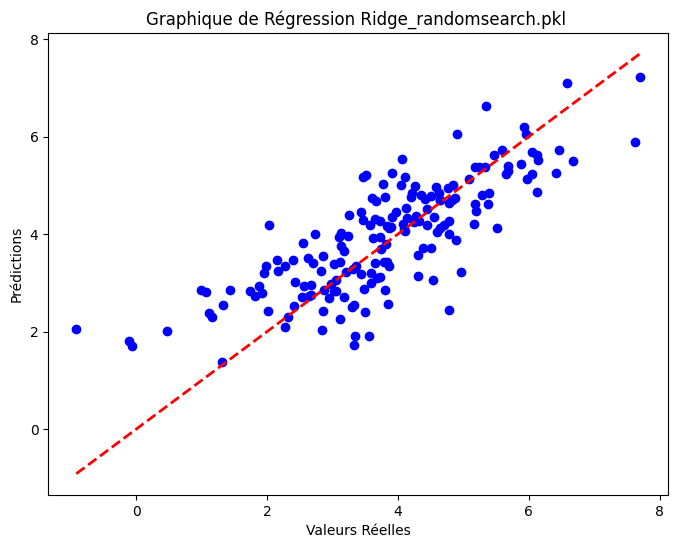

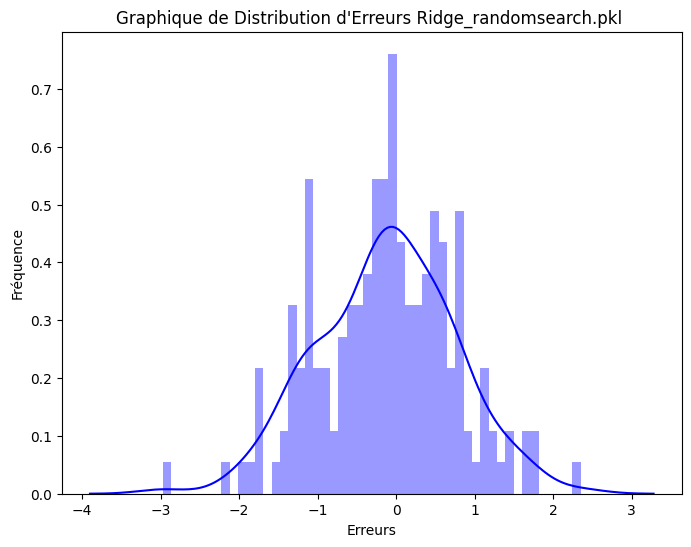

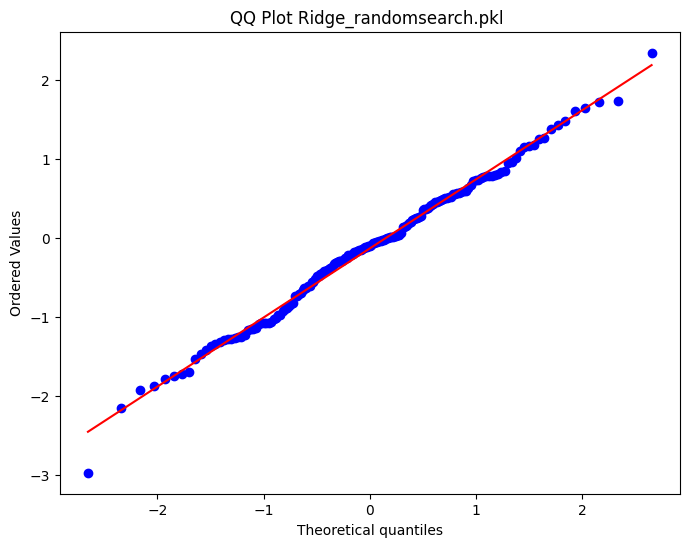

Métrique de performance pour le modèle Ridge_standard.pkl :
R²: 0.6257366266782431
RMSE: 0.8765307875000028
MAE: 0.685380821479193
MSE: 0.768306221435375


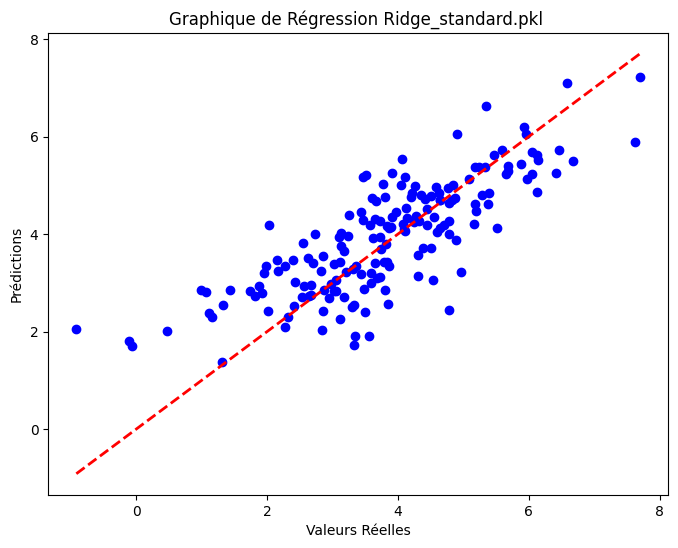

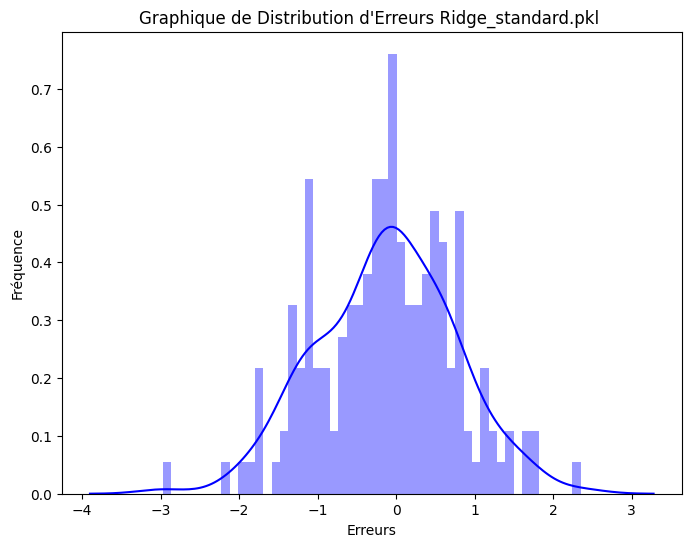

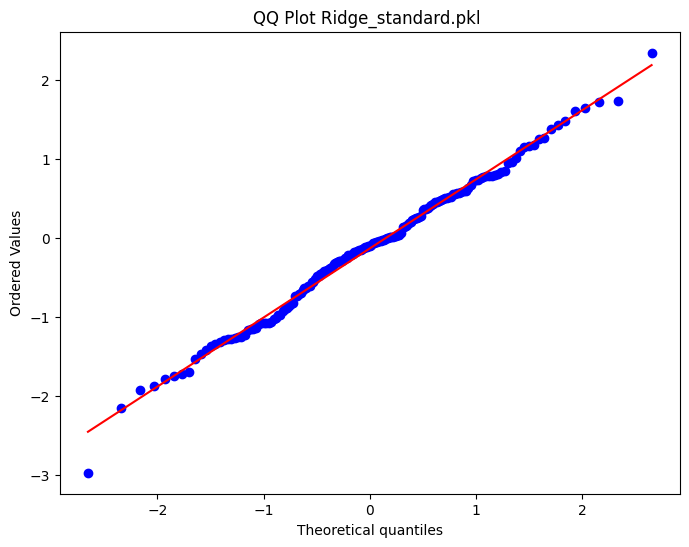

Métrique de performance pour le modèle SVR_gridsearch.pkl :
R²: 0.6975741443430381
RMSE: 0.7879306057131925
MAE: 0.623066781001686
MSE: 0.6208346394195585


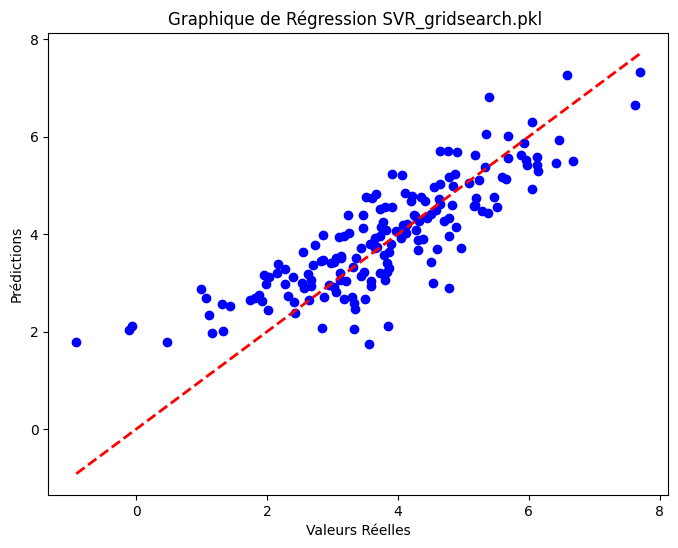

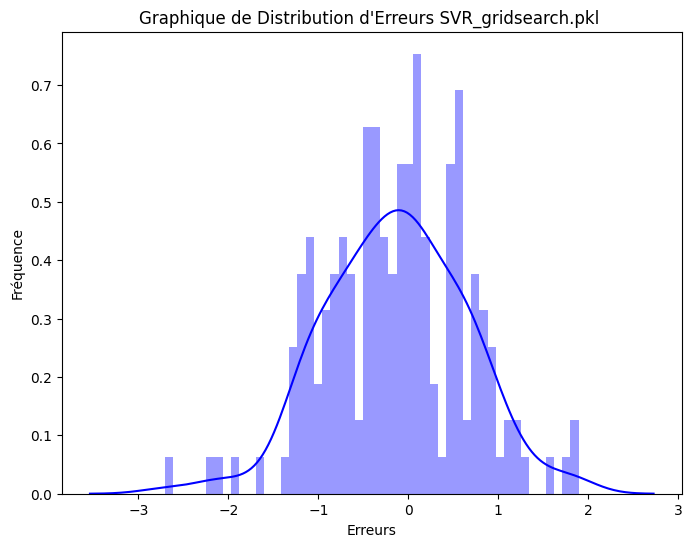

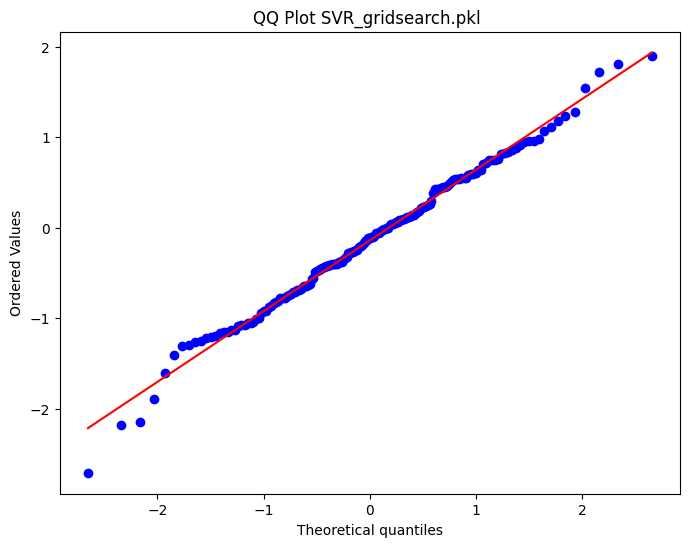

Métrique de performance pour le modèle SVR_randomsearch.pkl :
R²: 0.6975741443430381
RMSE: 0.7879306057131925
MAE: 0.623066781001686
MSE: 0.6208346394195585


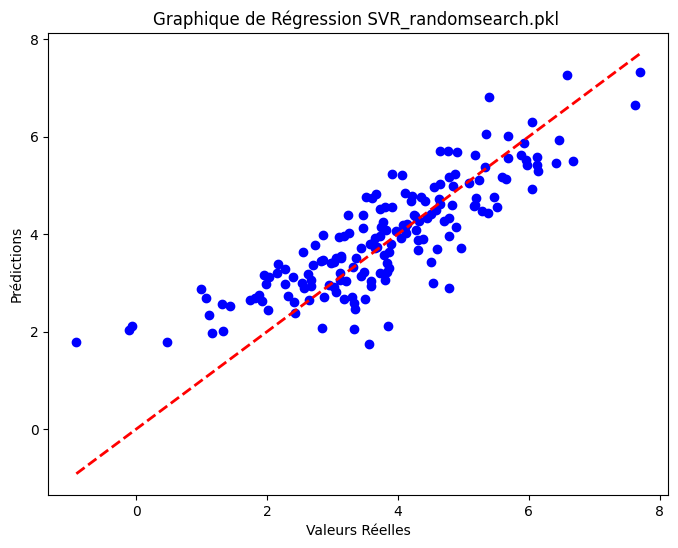

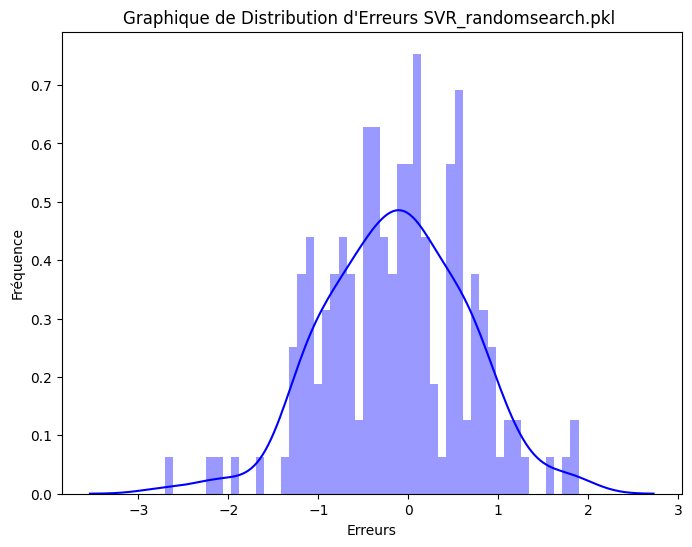

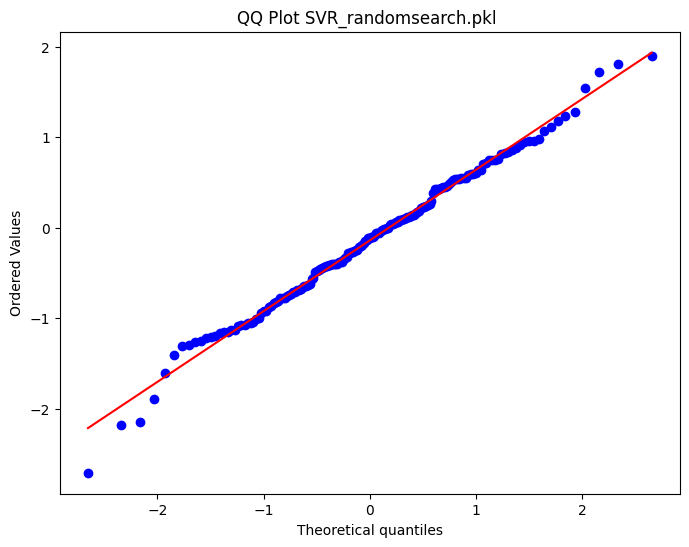

Métrique de performance pour le modèle SVR_standard.pkl :
R²: 0.5918952521104391
RMSE: 0.915301838776601
MAE: 0.7137799067294659
MSE: 0.8377774560678269


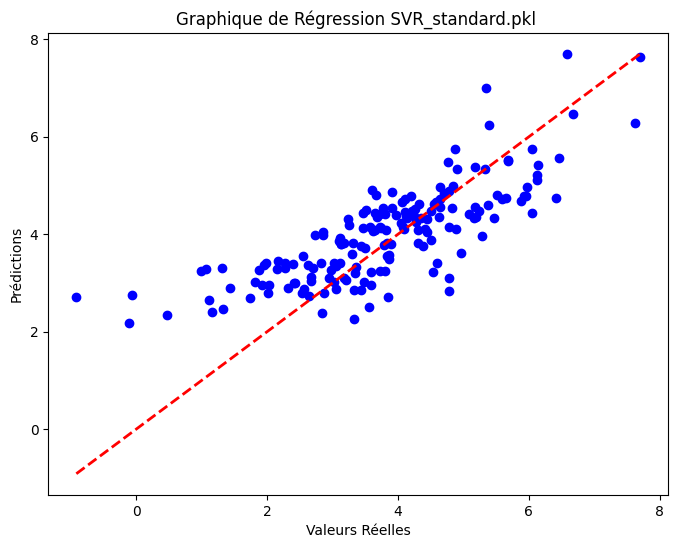

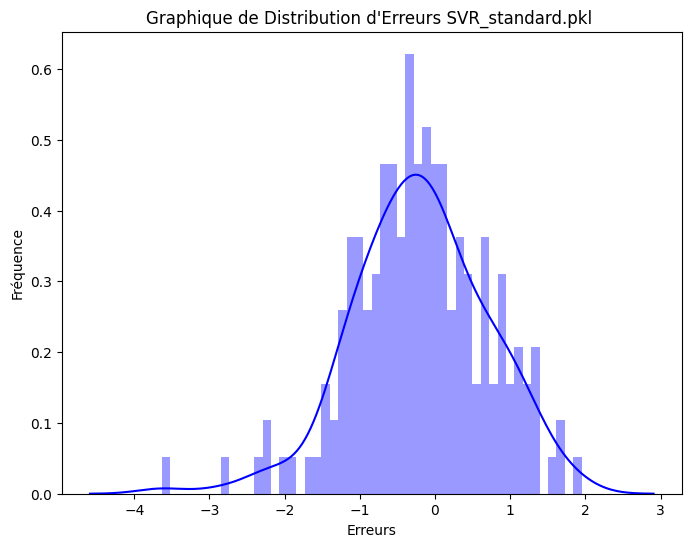

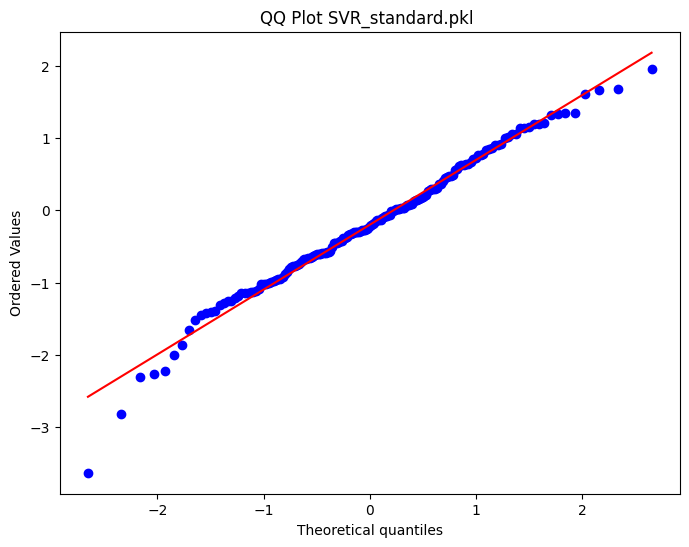

In [12]:
loaded_models = load_and_evaluate_models('../DATA/pickle/TotalGHGEmissions/withoutlieaires/withoutENERGYSTARScore', X_test, y_test, evaluate_model_performance)



Les méthodes ensemblistes permettent des performances plus intéressantes. Le temps de calcul est aussi plus important, mais la qualité prédictive devient très satisfaisante, avec une erreur quadratique moyenne faible. 



### Recherche de modèles de prédiction pour la consommation CO2 (TotalGHGEmissions) with ENERGYSTARScore and with outlieares 

imputer le ENERGYSTARScore 

In [13]:
df.columns[df.isnull().any()].tolist()



['ENERGYSTARScore', 'Comments']

Ajout ENERGYSTARScore dans les Features

In [14]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio','ENERGYSTARScore'] # ,


In [15]:
import pandas as pd
from sklearn.impute import KNNImputer

# Supposons que votre DataFrame s'appelle df
# Créez un KNNImputer avec 5 voisins
imputer = KNNImputer(n_neighbors=5)

# Sélectionnez la colonne à imputer
col_to_impute = ['ENERGYSTARScore']

# Imputez les valeurs NaN dans la colonne sélectionnée
df[col_to_impute] = imputer.fit_transform(df[col_to_impute])

# Maintenant, les valeurs NaN dans la colonne 'ENERGYSTARScore' ont été imputées avec la méthode KNN avec 5 voisins les plus proches


In [16]:
df.columns[df.isnull().any()].tolist()

['Comments']

In [17]:
X_train, X_test, y_train, y_test = data_preprocessing1(df,prop_C_cols,prop_Q_cols,'TotalGHGEmissions_log',0.2)
display(X_test.shape)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/TotalGHGEmissions/withoutlieaires/withENERGYSTARScore/')
compar_results_energy

X :  (863, 66)
X_encoded :  (863, 436)


(173, 436)

Comparative table of models…


extratree     dummy                       lr     ridge  \
Standard Time      3.202018       0.0                  0.15039  0.013302   
GridSearch Time    5.705074  0.127511                 0.907969  0.237391   
RandomSearch Time  8.230207  0.249762                 1.636748  0.469957   
Standard R²        0.644913 -0.002331 -433591904129323106304.0  0.479409   
GridSearch R²       0.64547 -0.002331                 0.318791  0.479409   
RandomSearch R²    0.652778 -0.002331                 0.318791  0.479409   
Standard RMSE      0.829691  1.393974       28992760064.549831   1.00461   
GridSearch RMSE     0.82904  1.393974                 1.149183   1.00461   
RandomSearch RMSE  0.820451  1.393974                 1.149183   1.00461   

                      lasso   elastic       knn       svr        rfr  \
Standard Time      0.006996  0.009002     0.004  0.050181   2.947099   
GridSearch Time    0.314809  0.382001  0.498636  2.199197  12.032864   
RandomSearch Time  0.649782  0.716439  0.795428  3.301929  19.663202   
Standard R²       -0.002331  0.148598  0.383308  0.658838   0.643459   
GridSearch R²      0.552745  0.575046  0.383308   0.68684   0.665585   
RandomSearch R²    0.552745  0.575046  0.383308  0.688441   0.665585   
Standard RMSE      1.393974  1.284743   1.09341   0.81326   0.831388   
GridSearch RMSE    0.931165  0.907654   1.09341  0.779169   0.805178   
RandomSearch RMSE  0.931165  0.907654   1.09341  0.777175   0.805178   

                   gradboost  
Standard Time       1.044177  
GridSearch Time    27.431288  
RandomSearch Time  49.795136  
Standard R²         0.744288  
GridSearch R²       0.470471  
RandomSearch R²     0.470471  
Standard RMSE       0.704084  
GridSearch RMSE     1.013197  
RandomSearch RMSE   1.013197

Métrique de performance pour le modèle DummyRegressor_gridsearch.pkl :
R²: -0.002331115405449946
RMSE: 1.3939737170570756
MAE: 1.1002485729181057
MSE: 1.9431627238459197


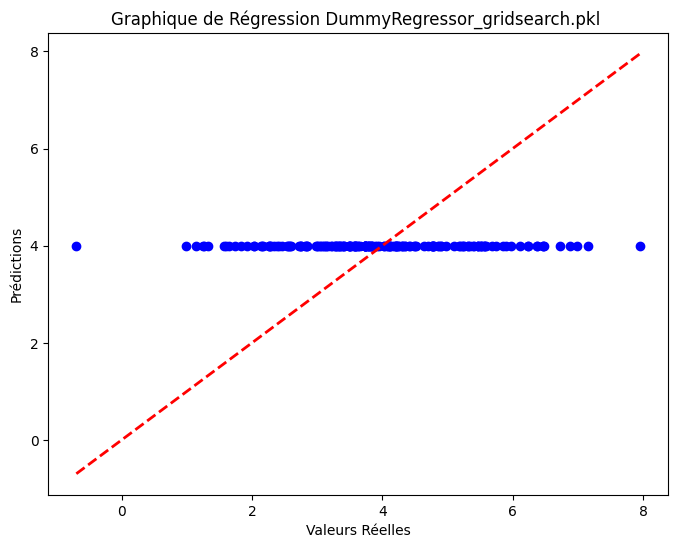

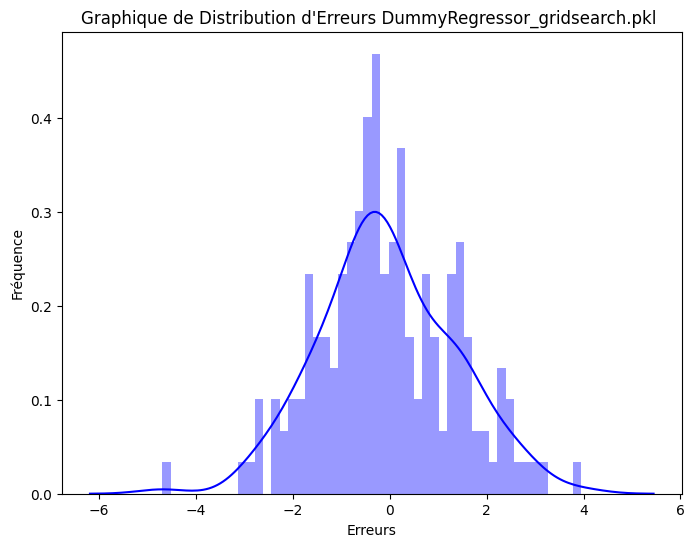

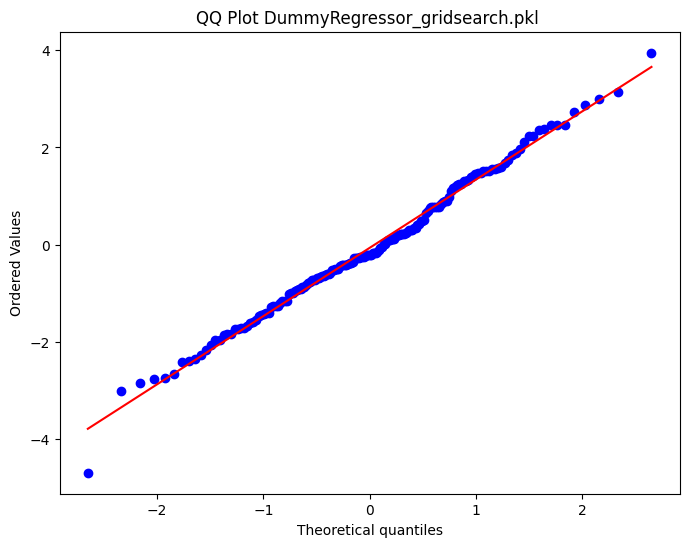

Métrique de performance pour le modèle DummyRegressor_randomsearch.pkl :
R²: -0.002331115405449946
RMSE: 1.3939737170570756
MAE: 1.1002485729181057
MSE: 1.9431627238459197


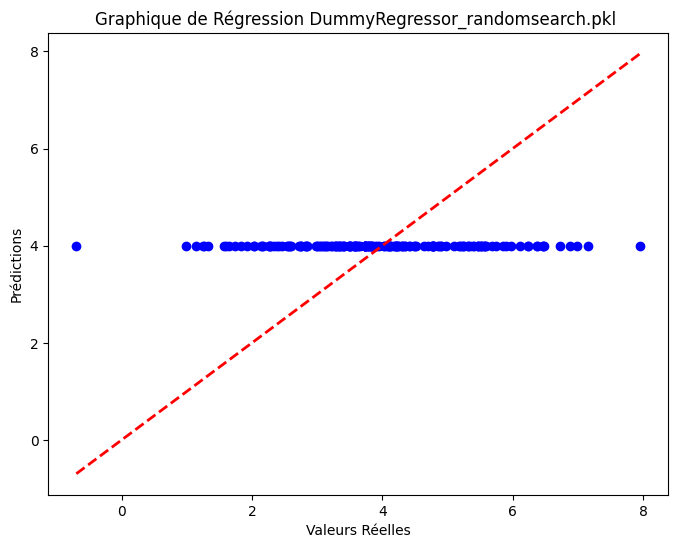

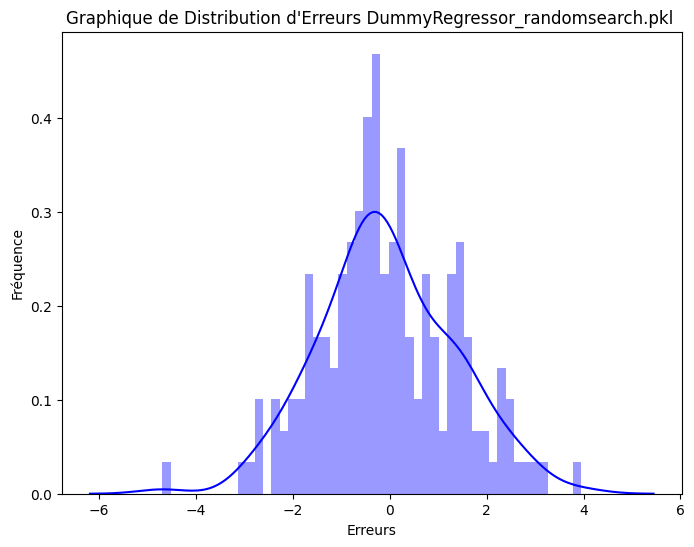

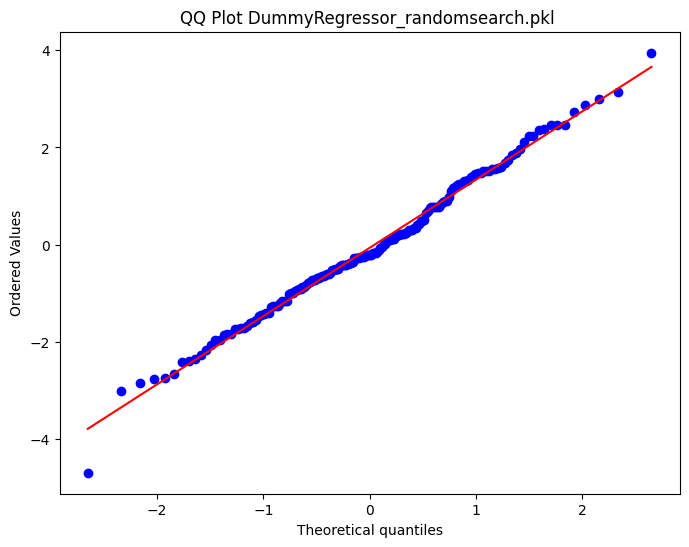

Métrique de performance pour le modèle DummyRegressor_standard.pkl :
R²: -0.002331115405449946
RMSE: 1.3939737170570756
MAE: 1.1002485729181057
MSE: 1.9431627238459197


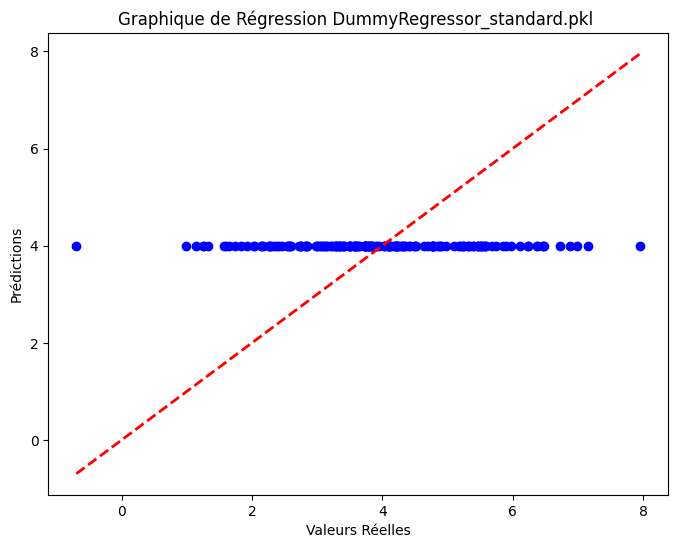

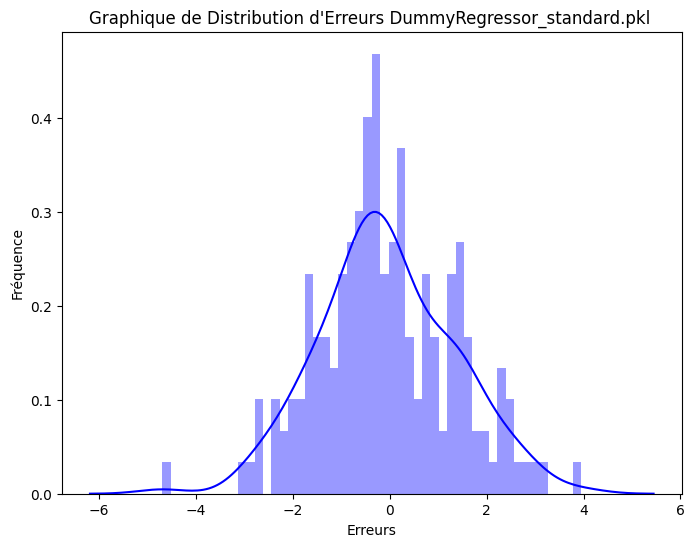

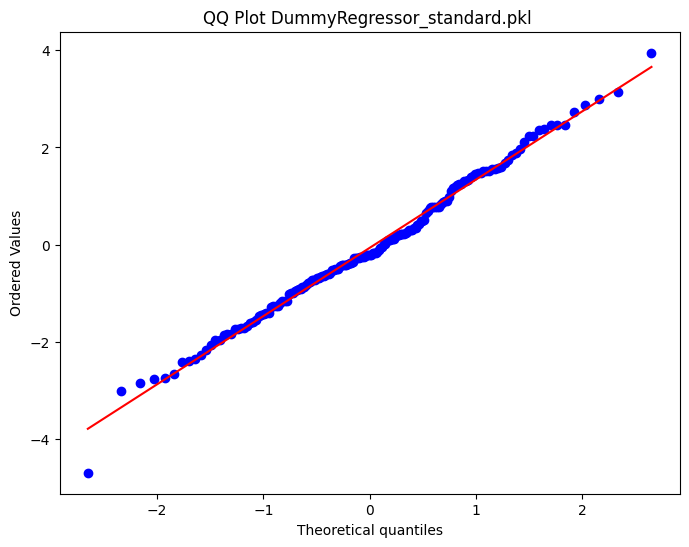

Métrique de performance pour le modèle ElasticNet_gridsearch.pkl :
R²: 0.5750455256602935
RMSE: 0.9076536998501221
MAE: 0.6896117107838097
MSE: 0.8238352388516156


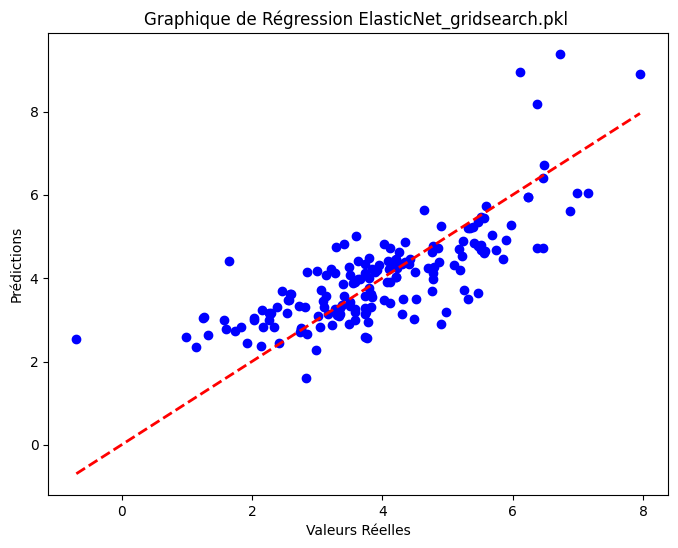

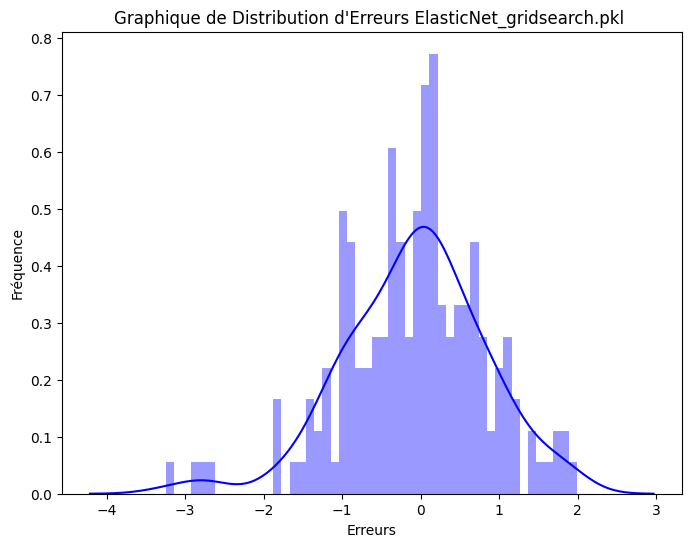

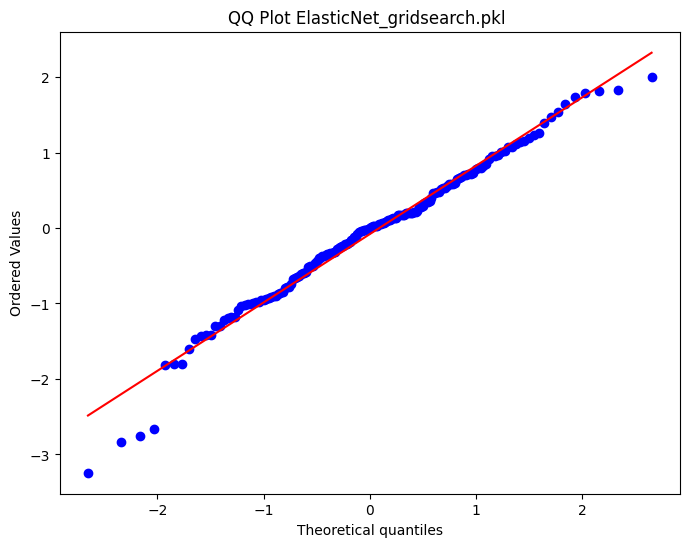

Métrique de performance pour le modèle ElasticNet_randomsearch.pkl :
R²: 0.5750455256602935
RMSE: 0.9076536998501221
MAE: 0.6896117107838097
MSE: 0.8238352388516156


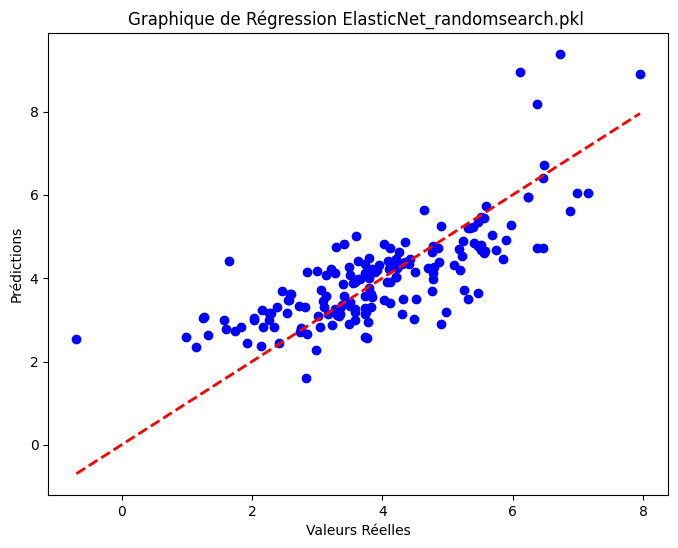

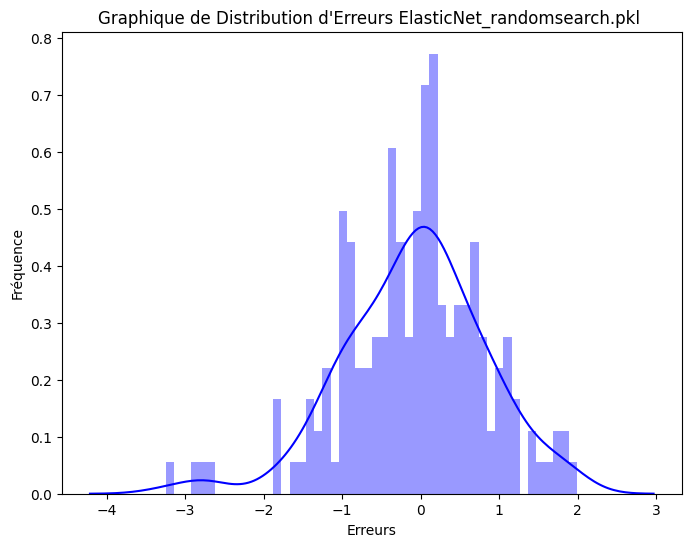

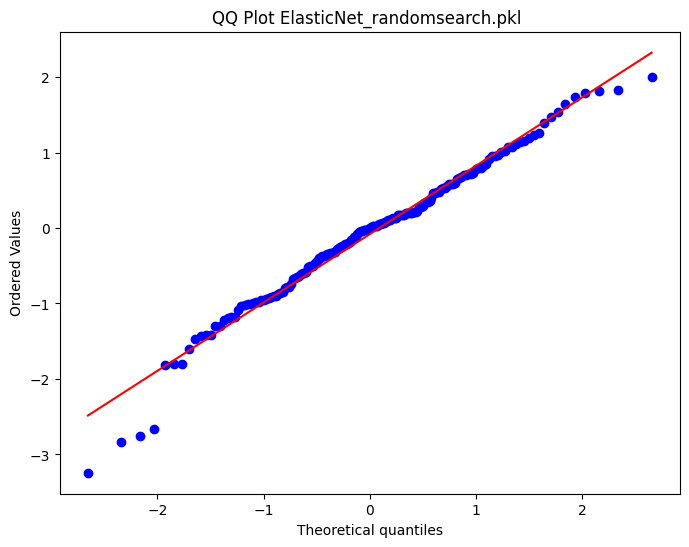

Métrique de performance pour le modèle ElasticNet_standard.pkl :
R²: 0.14859768326414113
RMSE: 1.284743393060233
MAE: 1.0137839132020225
MSE: 1.6505655860119202


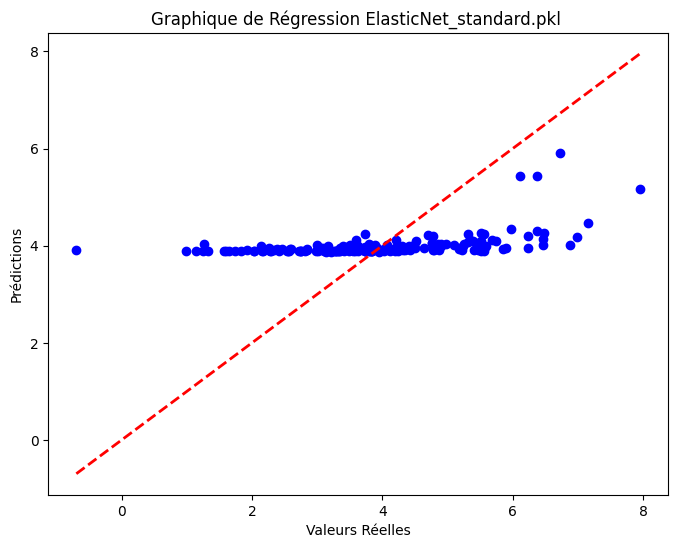

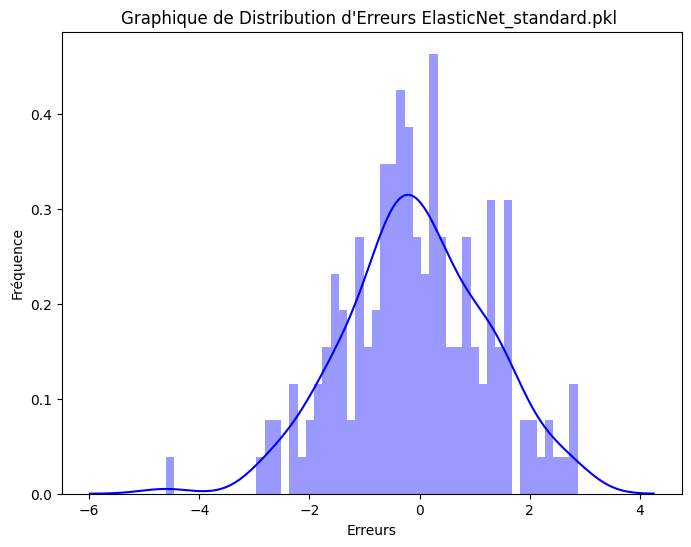

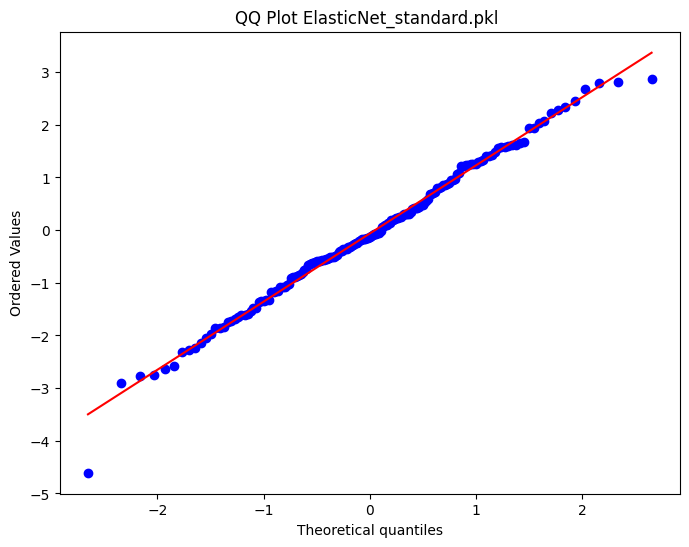

Métrique de performance pour le modèle ExtraTreesRegressor_gridsearch.pkl :
R²: 0.6454698573771134
RMSE: 0.8290401464181205
MAE: 0.5962813462802953
MSE: 0.6873075643729787


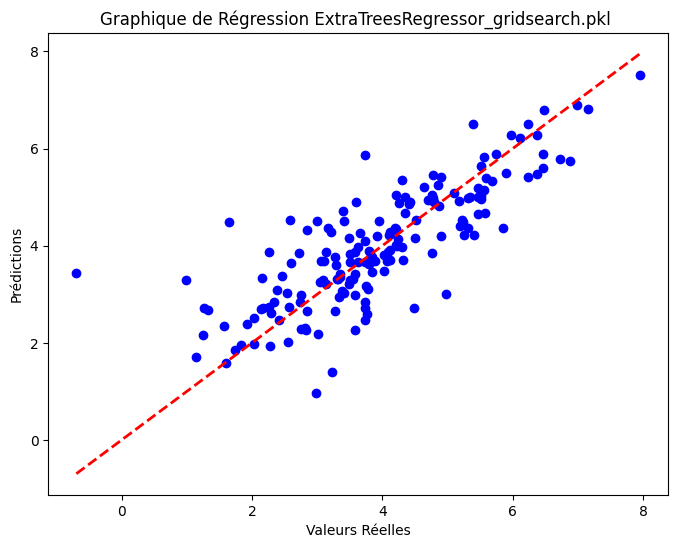

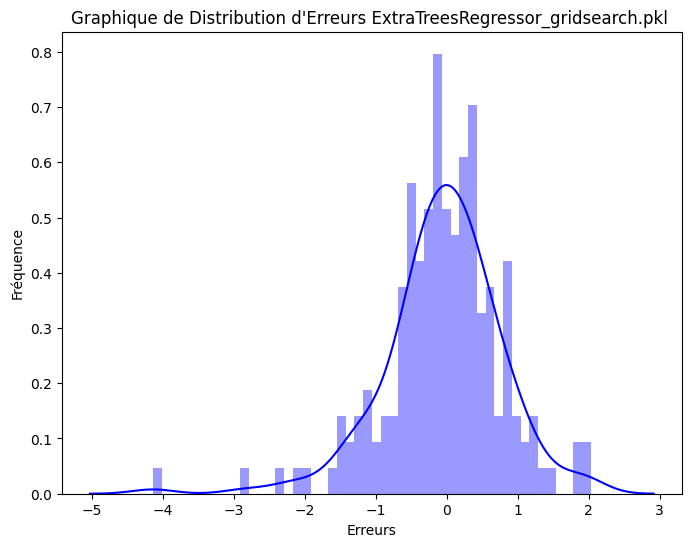

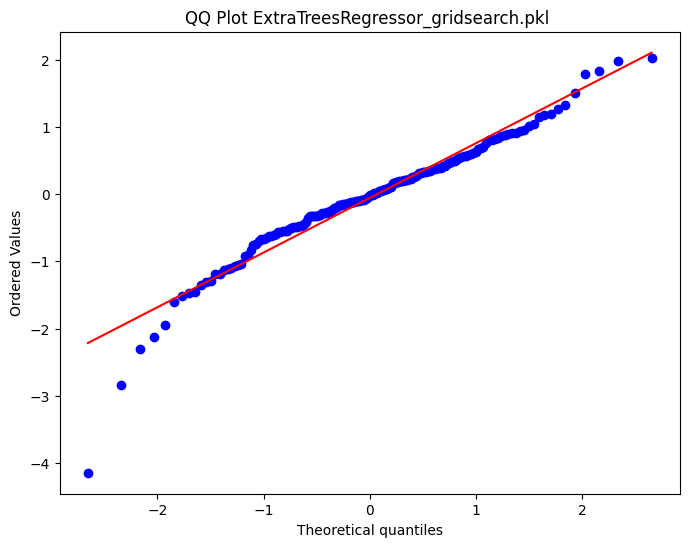

Métrique de performance pour le modèle ExtraTreesRegressor_randomsearch.pkl :
R²: 0.6527776083120453
RMSE: 0.8204513638005007
MAE: 0.5979939732802892
MSE: 0.6731404403621015


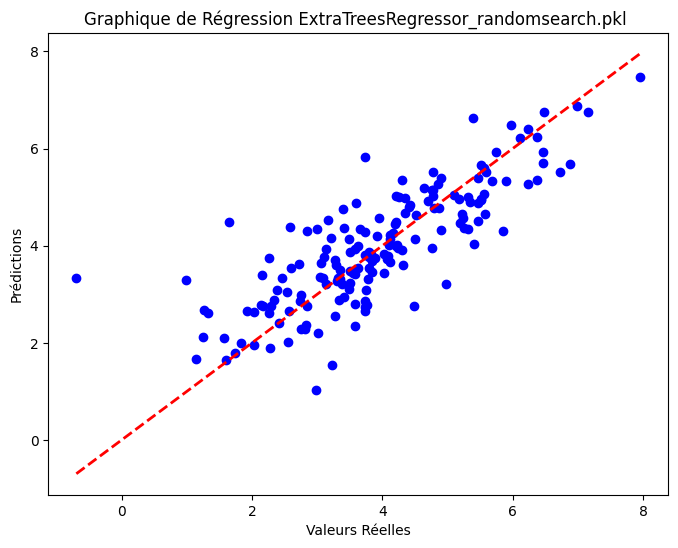

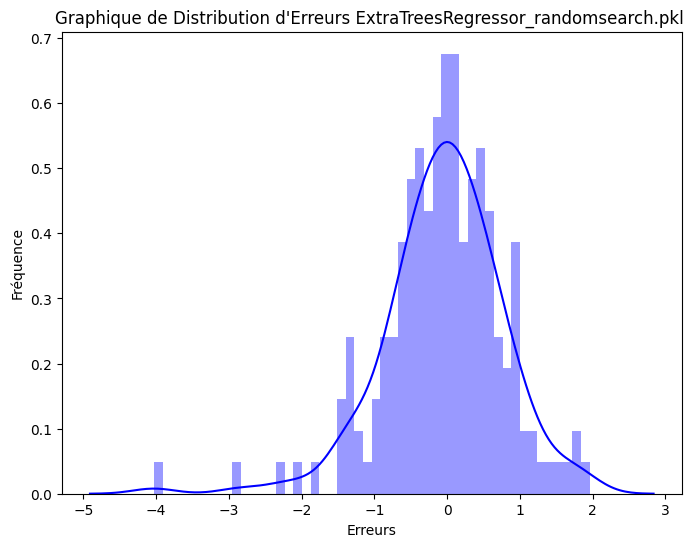

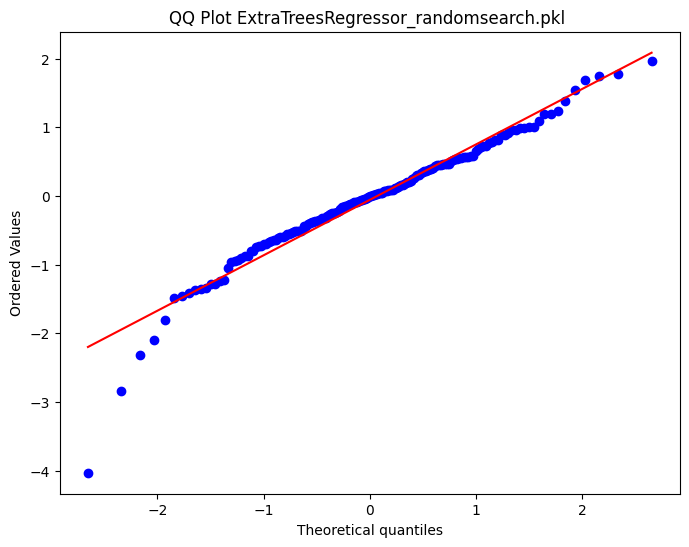

Métrique de performance pour le modèle ExtraTreesRegressor_standard.pkl :
R²: 0.6449134041846798
RMSE: 0.8296905017835404
MAE: 0.5973140487286159
MSE: 0.6883863287498231


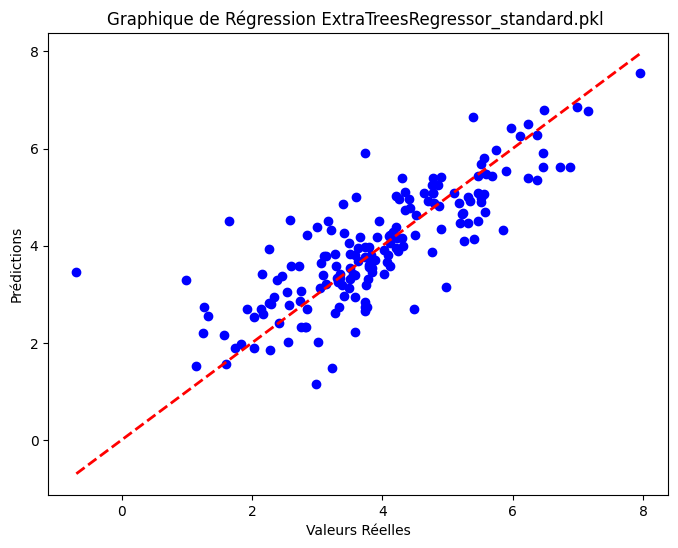

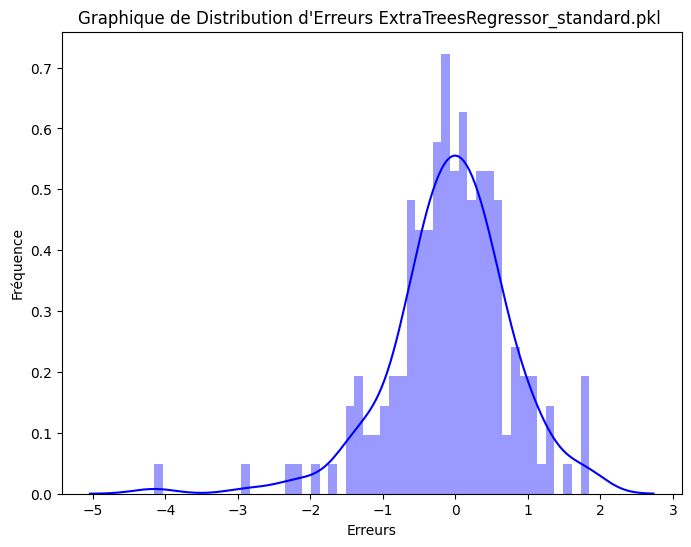

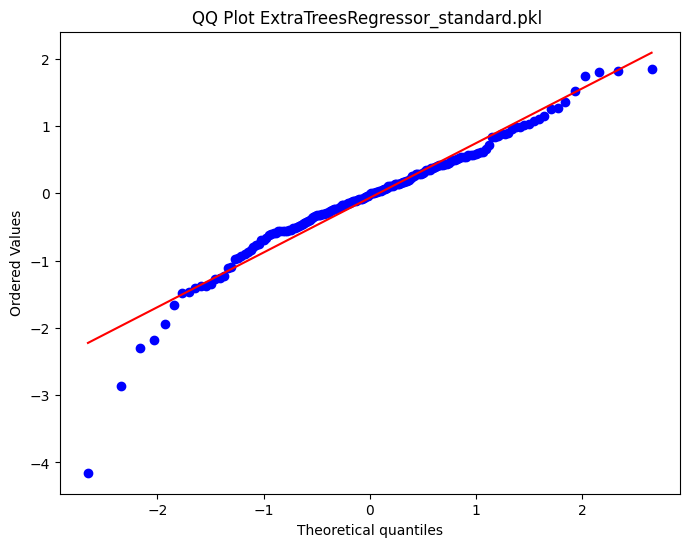

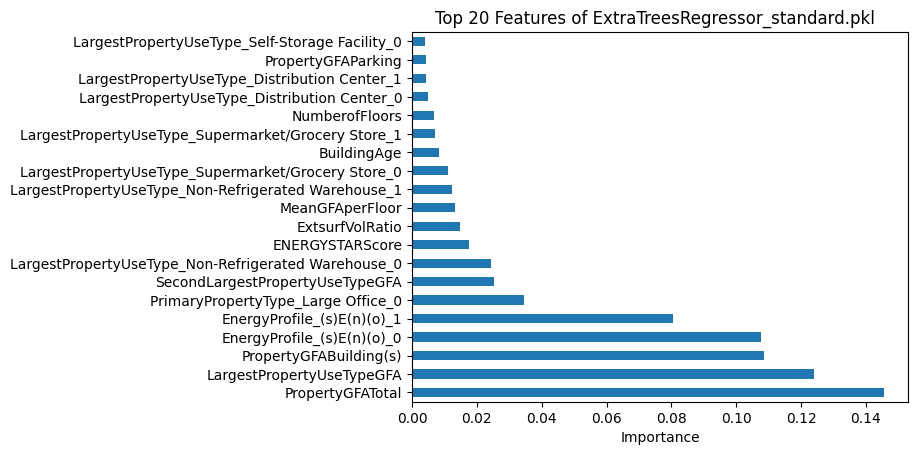

Métrique de performance pour le modèle GradientBoostingRegressor_gridsearch.pkl :
R²: 0.47047056367377704
RMSE: 1.0131973210964729
MAE: 0.7576837716515139
MSE: 1.0265688114770692


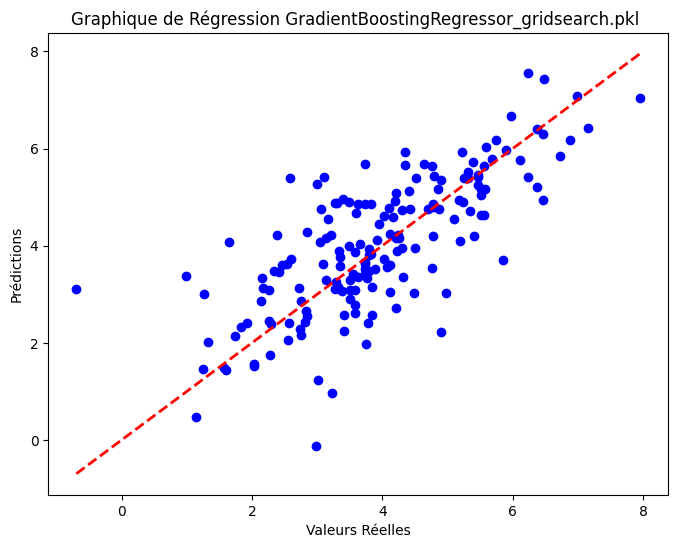

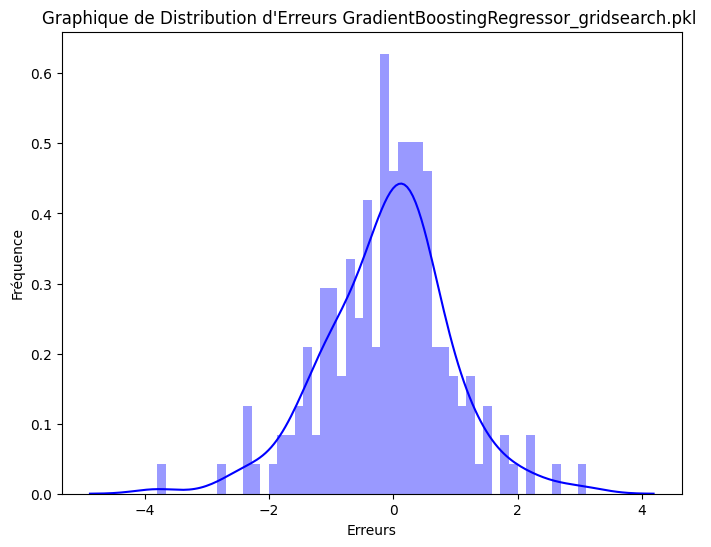

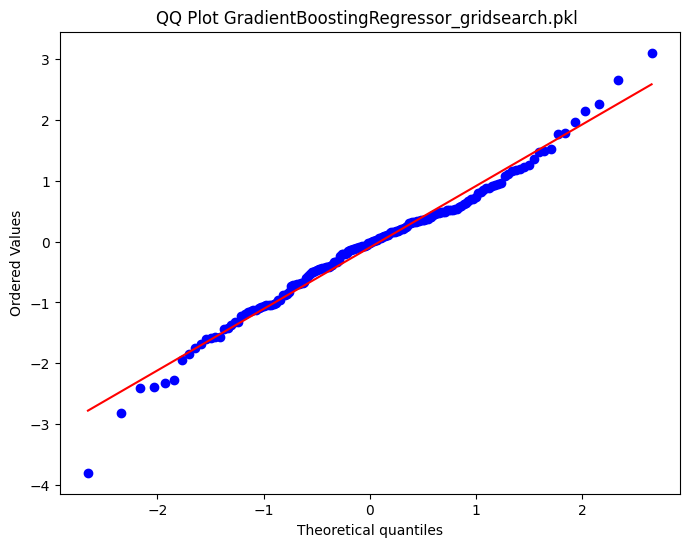

Métrique de performance pour le modèle GradientBoostingRegressor_randomsearch.pkl :
R²: 0.47047056367377704
RMSE: 1.0131973210964729
MAE: 0.7576837716515139
MSE: 1.0265688114770692


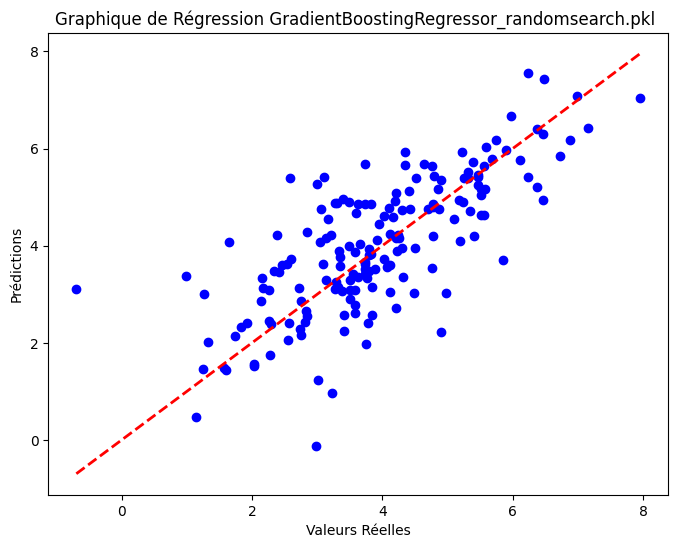

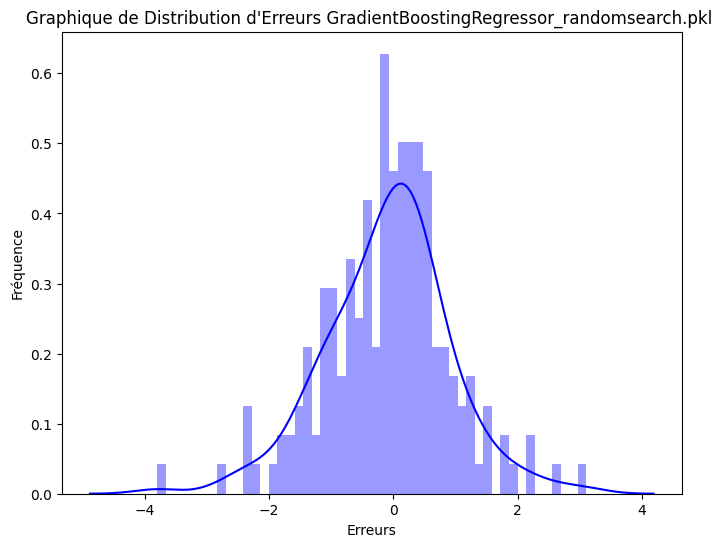

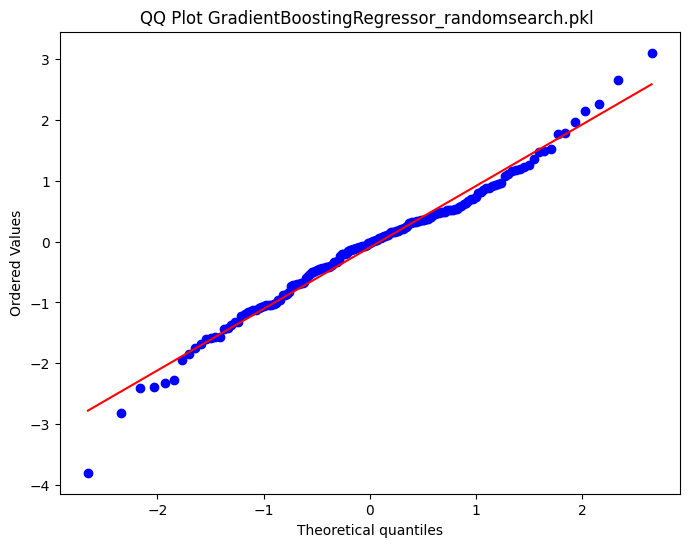

Métrique de performance pour le modèle GradientBoostingRegressor_standard.pkl :
R²: 0.7442878995042383
RMSE: 0.7040842329863575
MAE: 0.5278129126724671
MSE: 0.49573460713998724


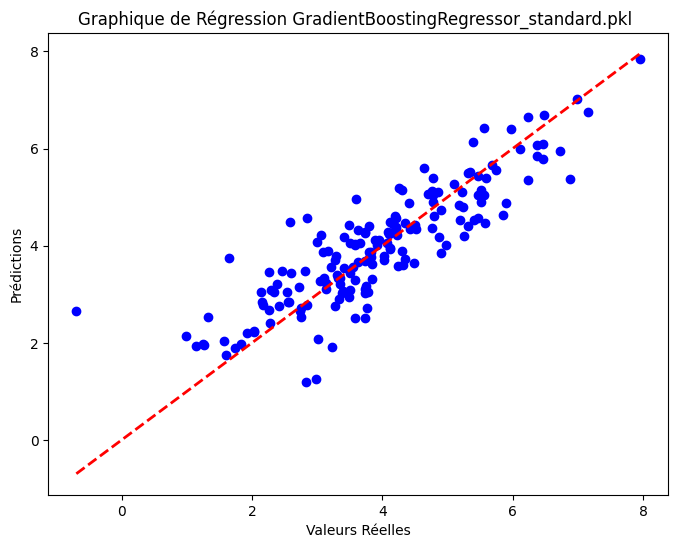

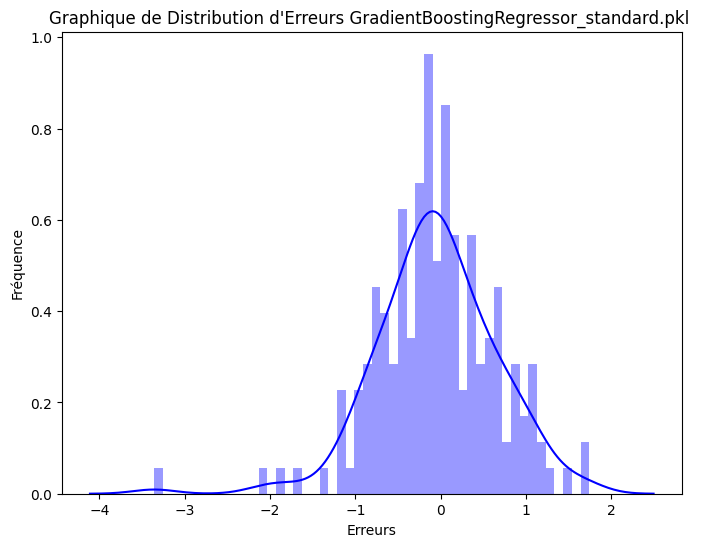

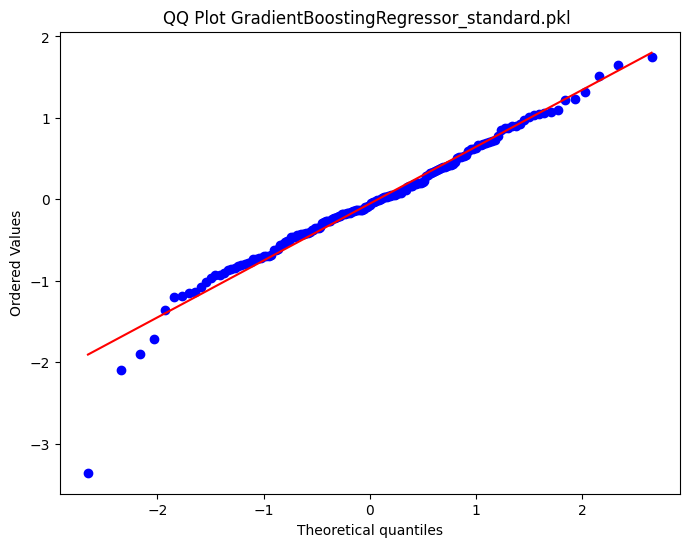

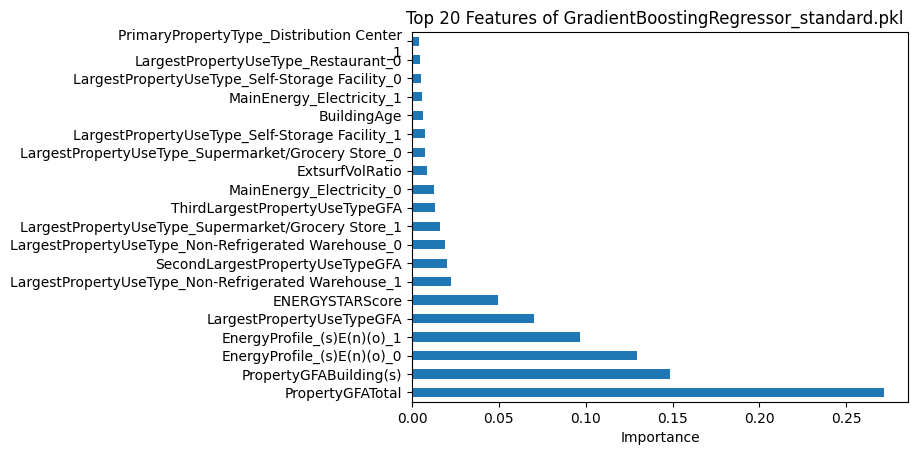

Métrique de performance pour le modèle KNeighborsRegressor_gridsearch.pkl :
R²: 0.38330828443003917
RMSE: 1.0934099869223097
MAE: 0.8527772677030063
MSE: 1.1955453995014456


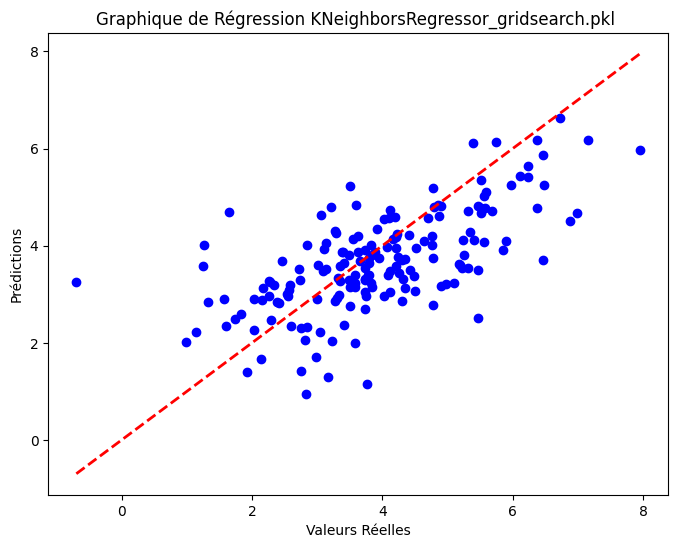

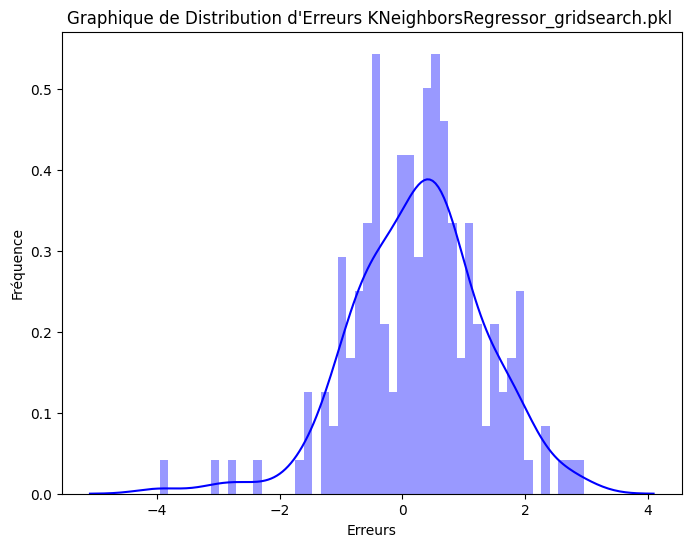

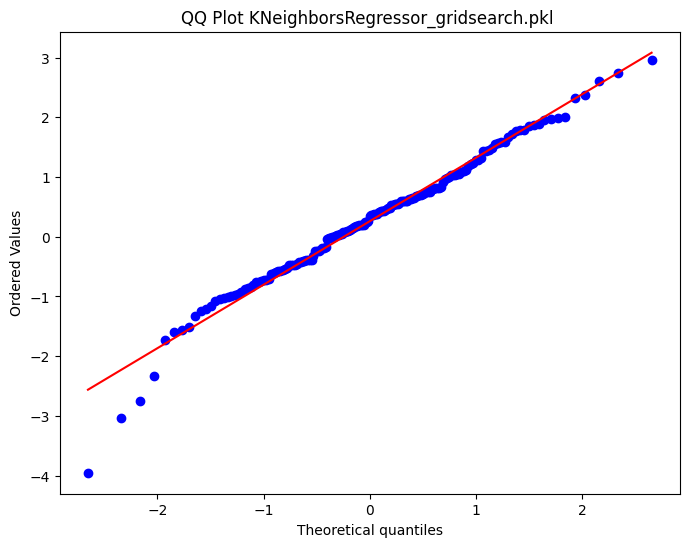

Métrique de performance pour le modèle KNeighborsRegressor_randomsearch.pkl :
R²: 0.38330828443003917
RMSE: 1.0934099869223097
MAE: 0.8527772677030063
MSE: 1.1955453995014456


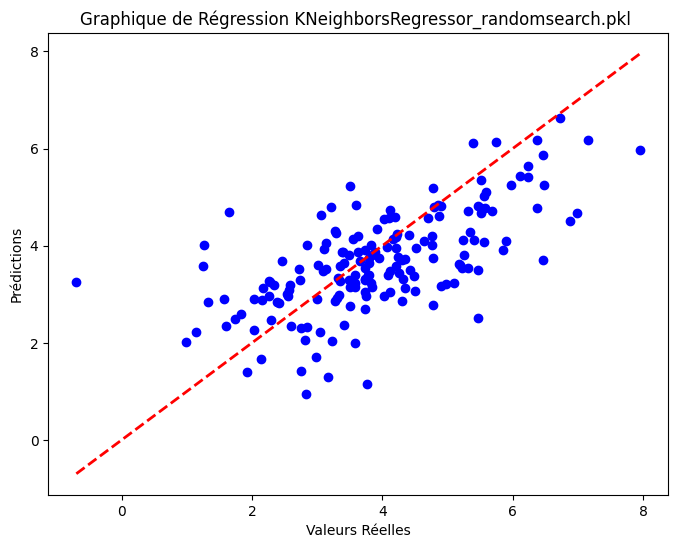

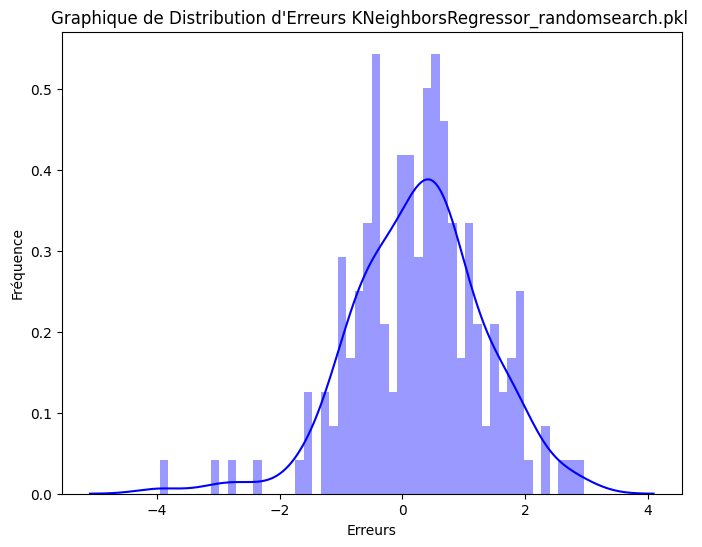

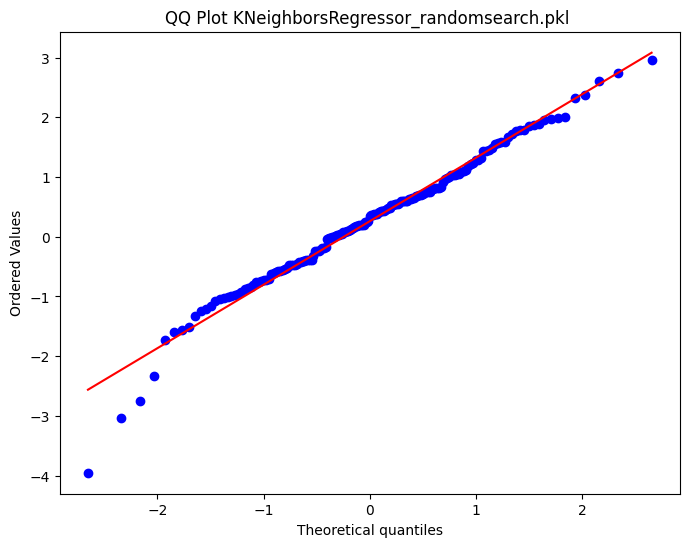

Métrique de performance pour le modèle KNeighborsRegressor_standard.pkl :
R²: 0.38330828443003917
RMSE: 1.0934099869223097
MAE: 0.8527772677030063
MSE: 1.1955453995014456


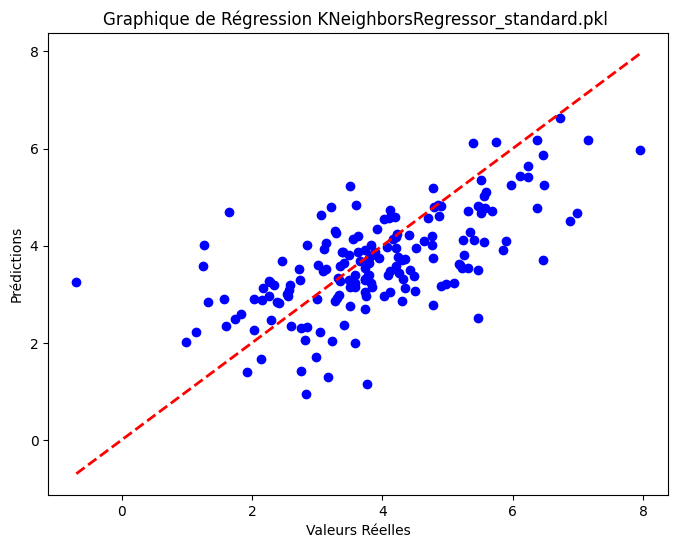

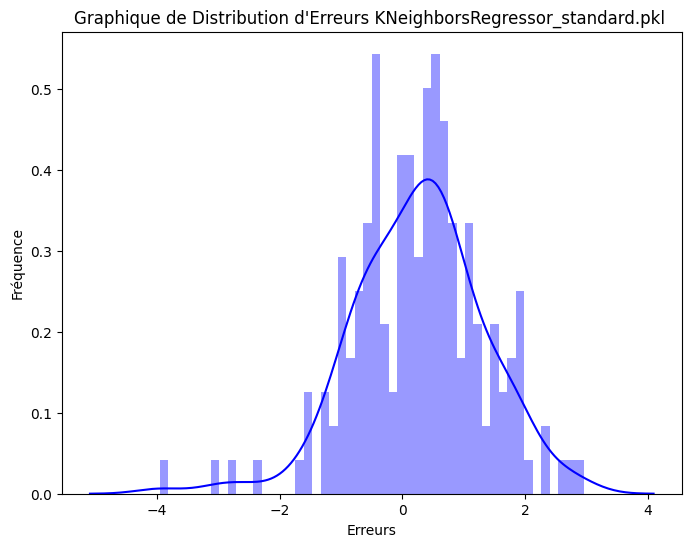

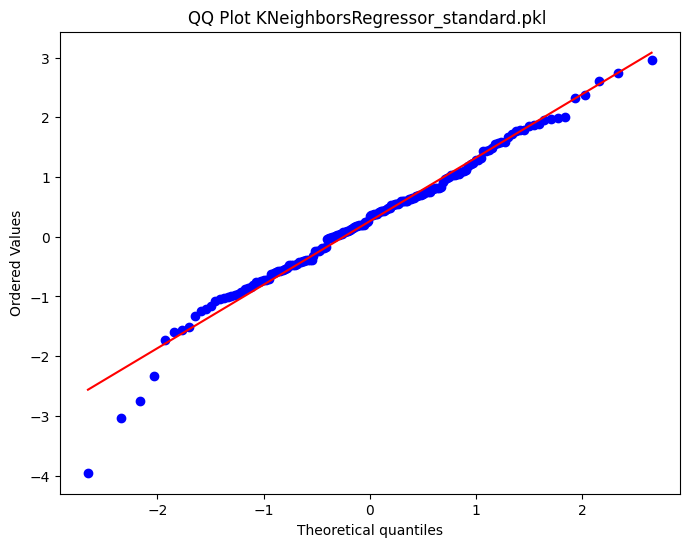

Métrique de performance pour le modèle Lasso_gridsearch.pkl :
R²: 0.5527447838143944
RMSE: 0.9311650914679057
MAE: 0.705643730820005
MSE: 0.8670684275684332


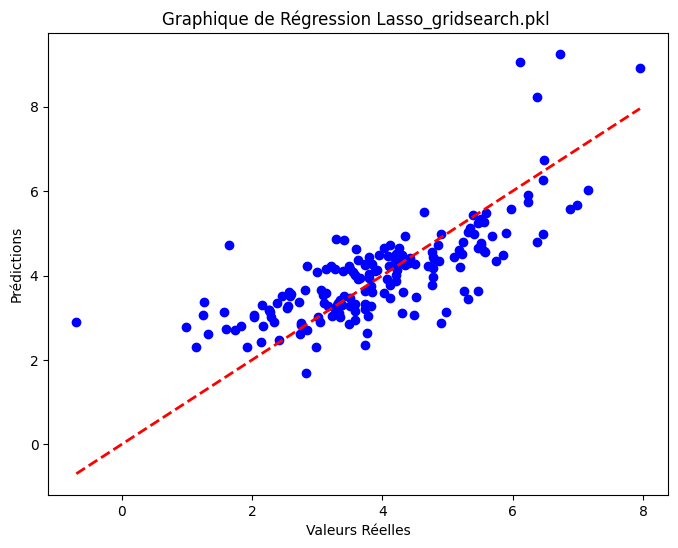

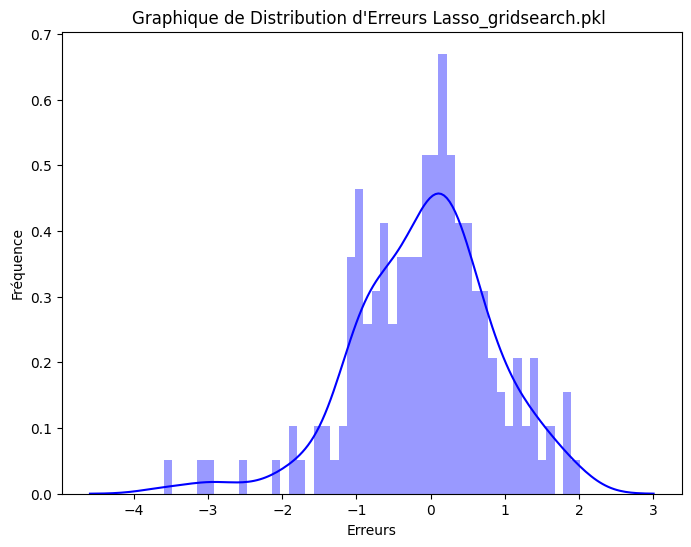

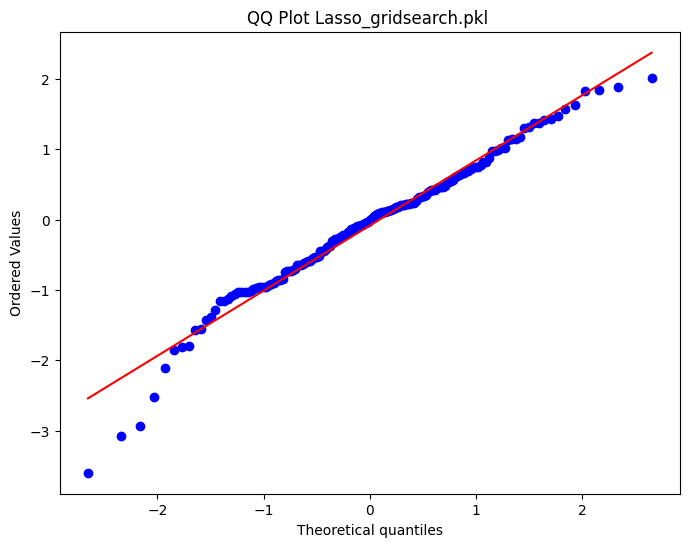

Métrique de performance pour le modèle Lasso_randomsearch.pkl :
R²: 0.5527447838143944
RMSE: 0.9311650914679057
MAE: 0.705643730820005
MSE: 0.8670684275684332


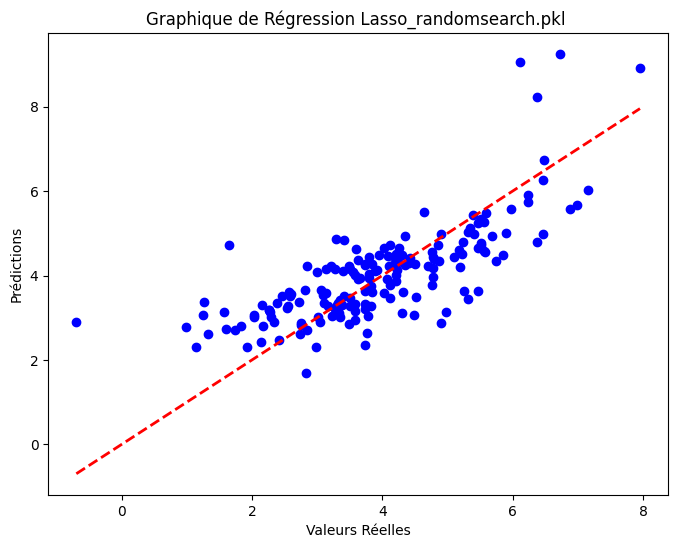

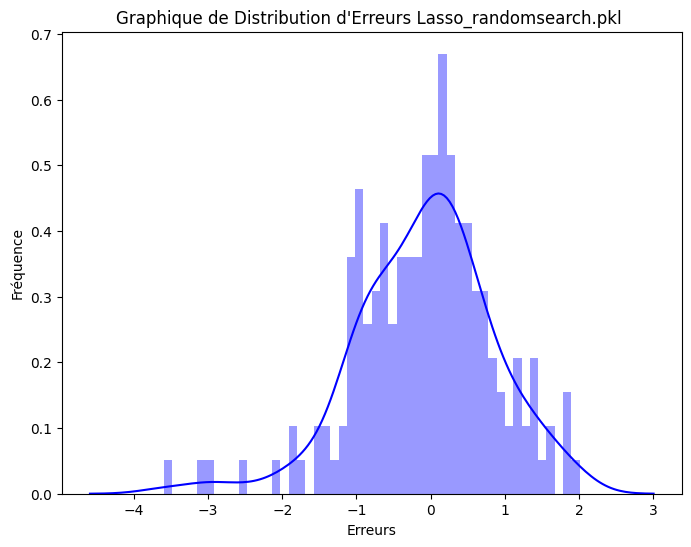

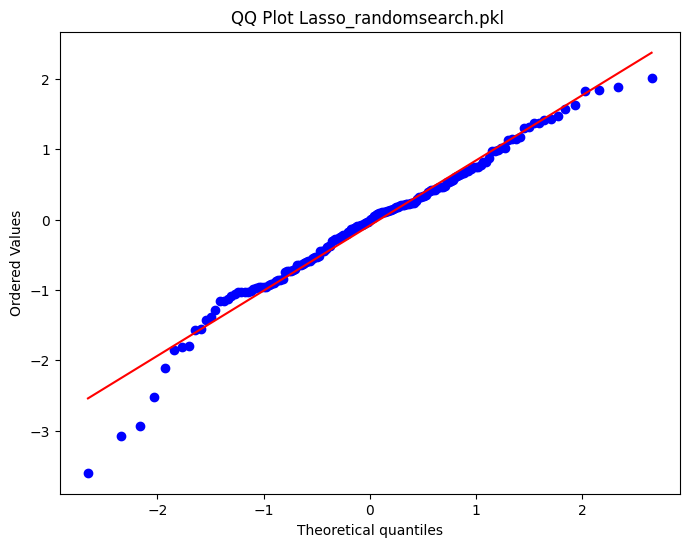

Métrique de performance pour le modèle Lasso_standard.pkl :
R²: -0.002331115405449946
RMSE: 1.3939737170570756
MAE: 1.1002485729181057
MSE: 1.9431627238459197


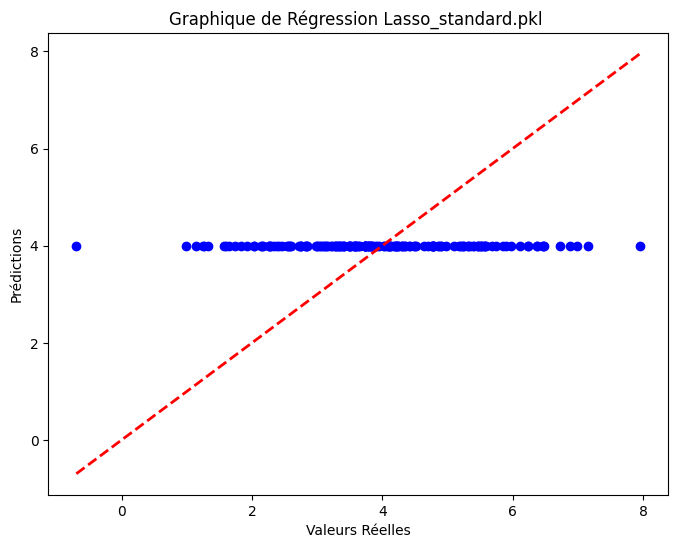

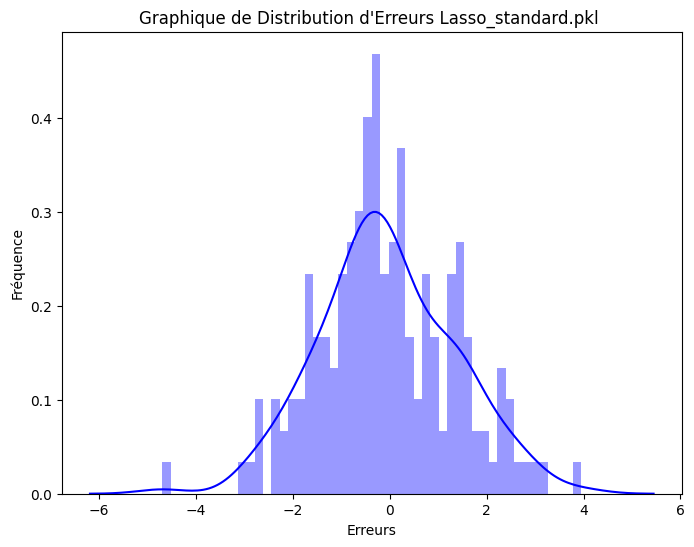

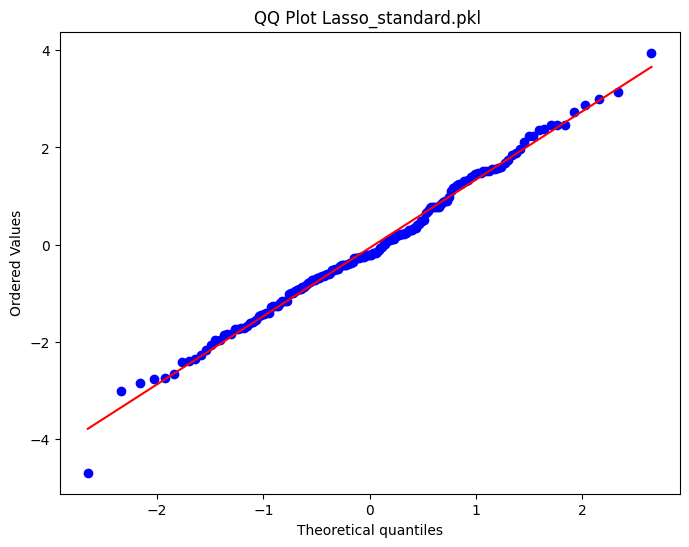

Métrique de performance pour le modèle LinearRegression_gridsearch.pkl :
R²: 0.31879061735073133
RMSE: 1.1491832564232538
MAE: 0.8579300460522519
MSE: 1.3206221568435539


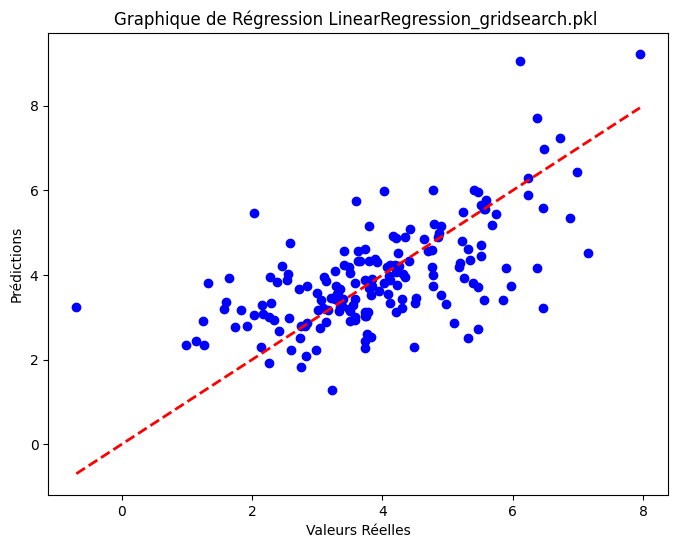

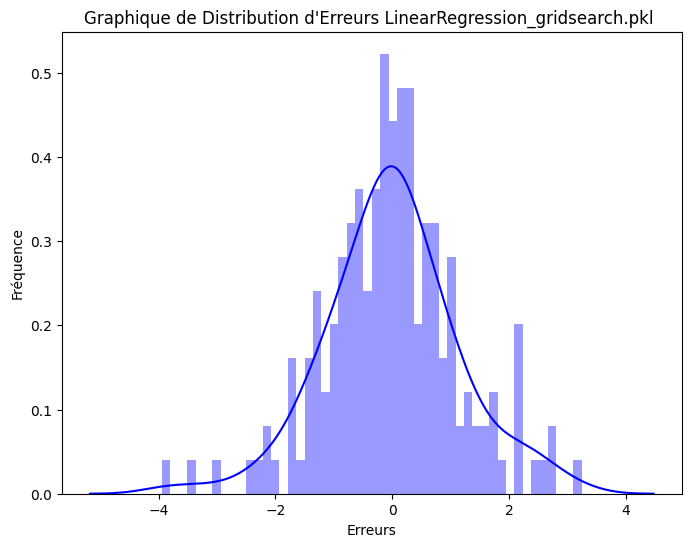

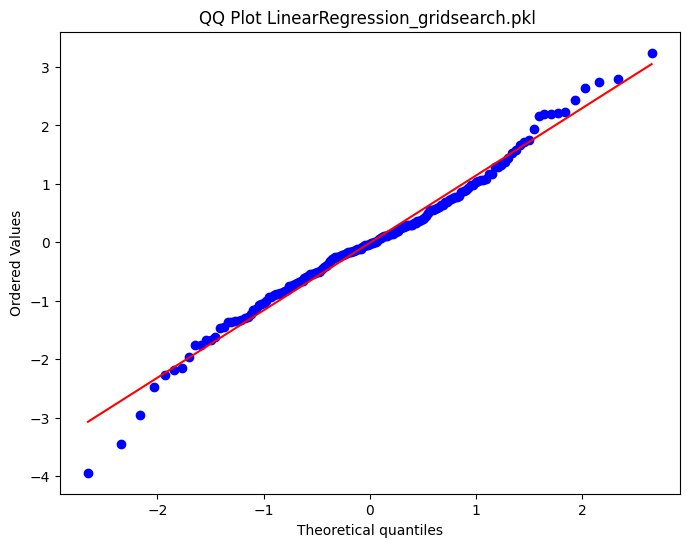

Métrique de performance pour le modèle LinearRegression_randomsearch.pkl :
R²: 0.31879061735073133
RMSE: 1.1491832564232538
MAE: 0.8579300460522519
MSE: 1.3206221568435539


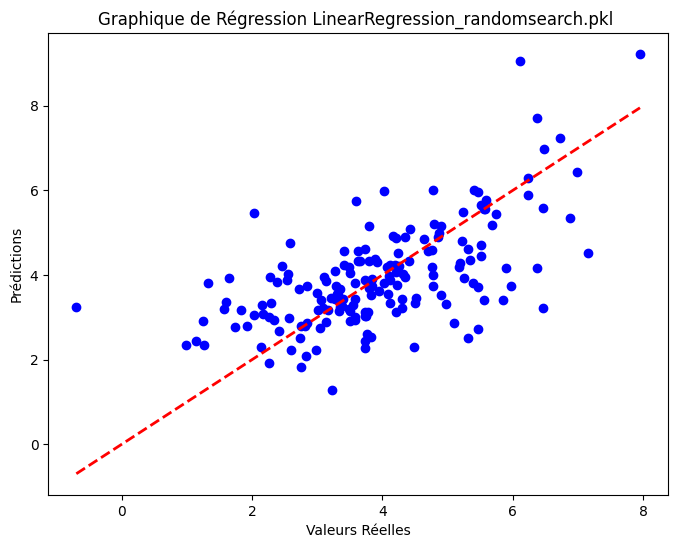

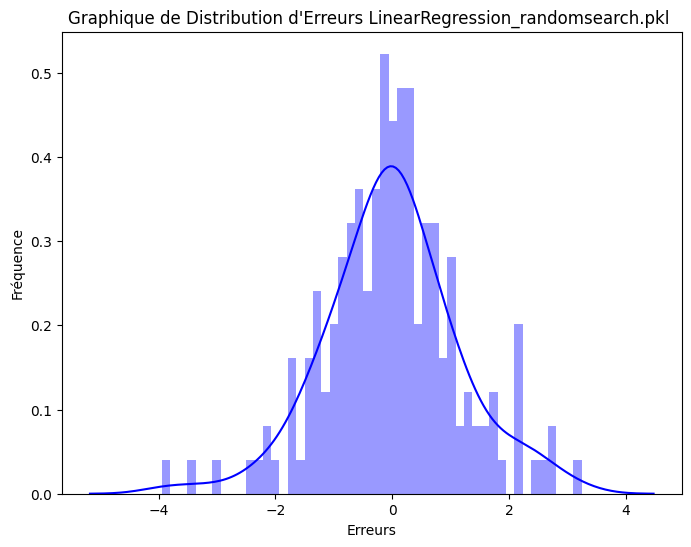

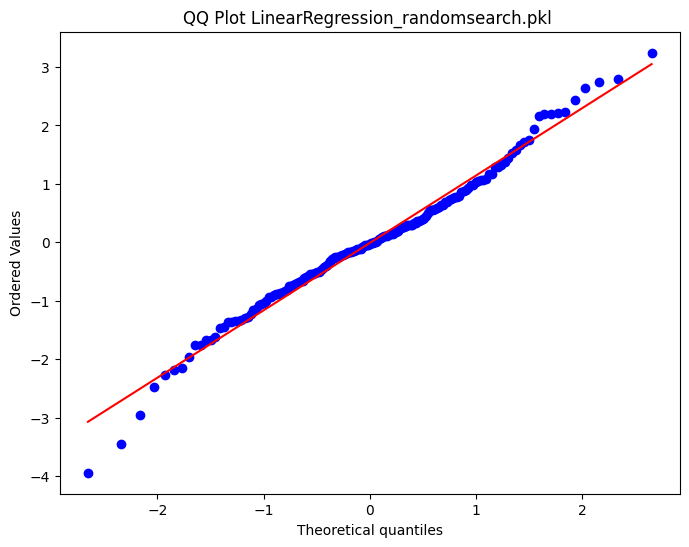

Métrique de performance pour le modèle LinearRegression_standard.pkl :
R²: -4.335919041293231e+20
RMSE: 28992760064.54983
MAE: 7740050866.130319
MSE: 8.405801361605554e+20


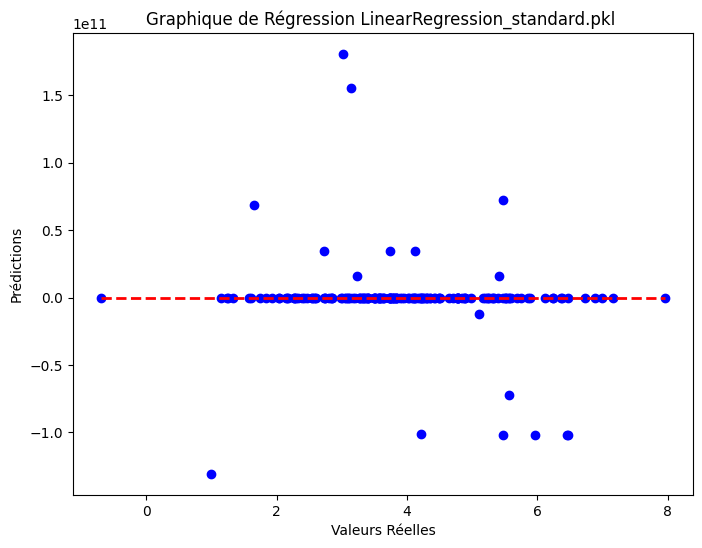

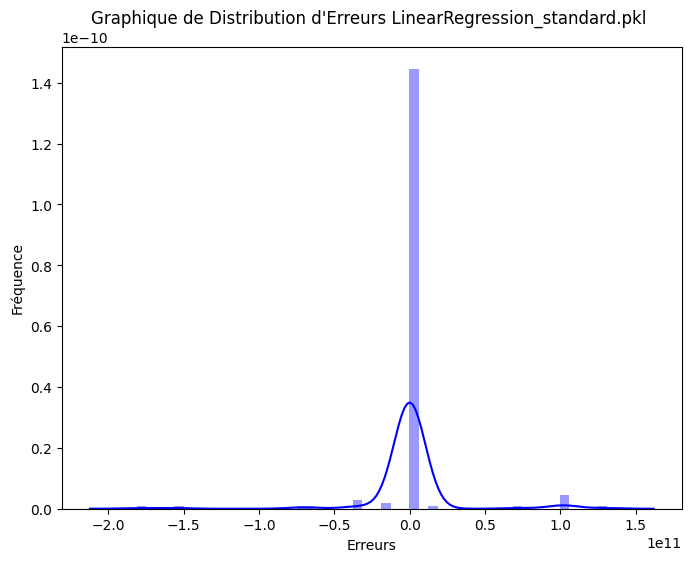

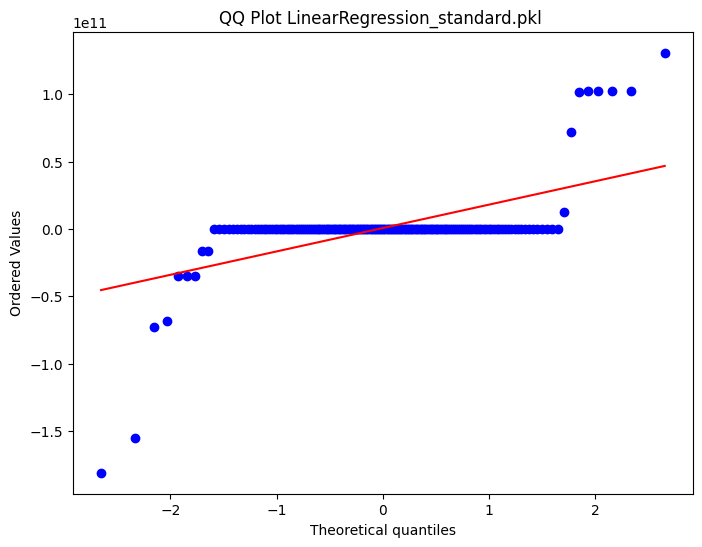

Métrique de performance pour le modèle RandomForestRegressor_gridsearch.pkl :
R²: 0.6655848584005142
RMSE: 0.8051780846139646
MAE: 0.6143660546042764
MSE: 0.6483117479426126


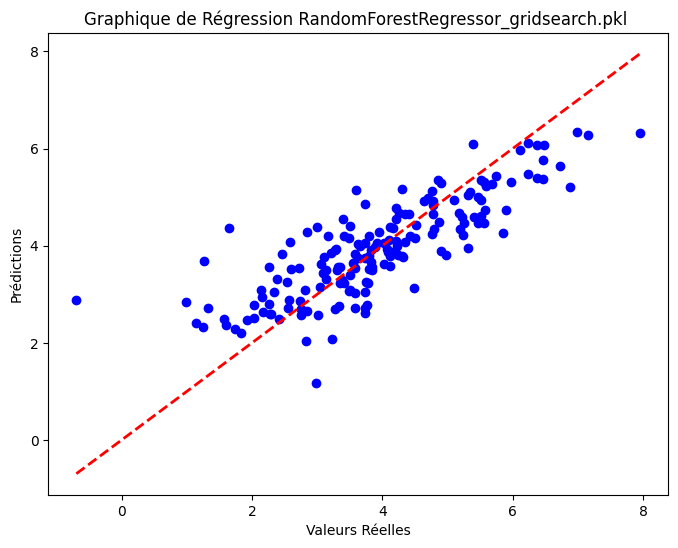

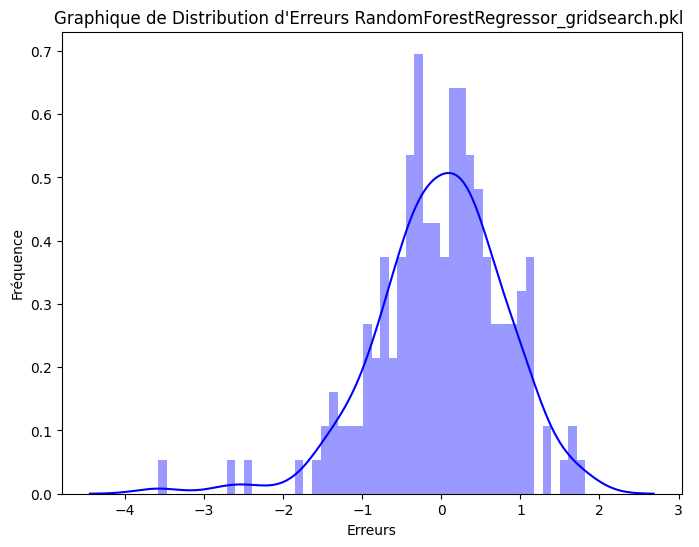

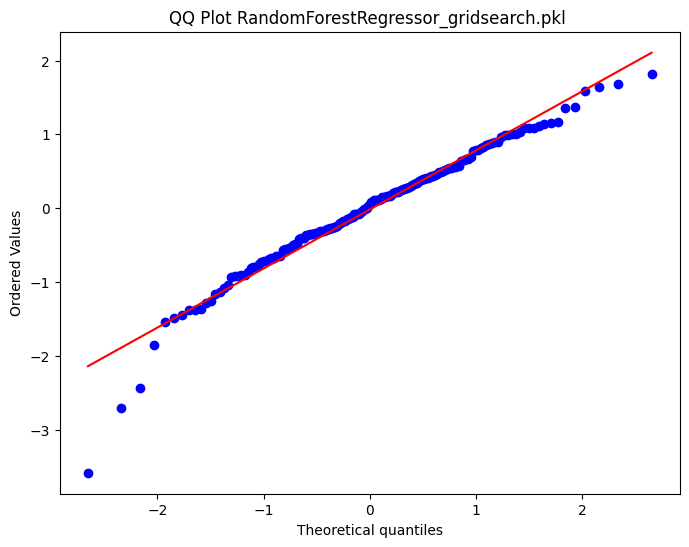

Métrique de performance pour le modèle RandomForestRegressor_randomsearch.pkl :
R²: 0.6655848584005142
RMSE: 0.8051780846139646
MAE: 0.6143660546042762
MSE: 0.6483117479426126


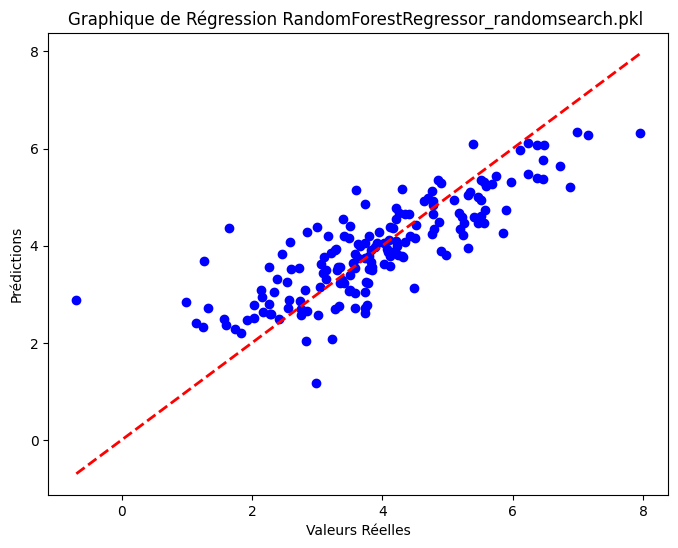

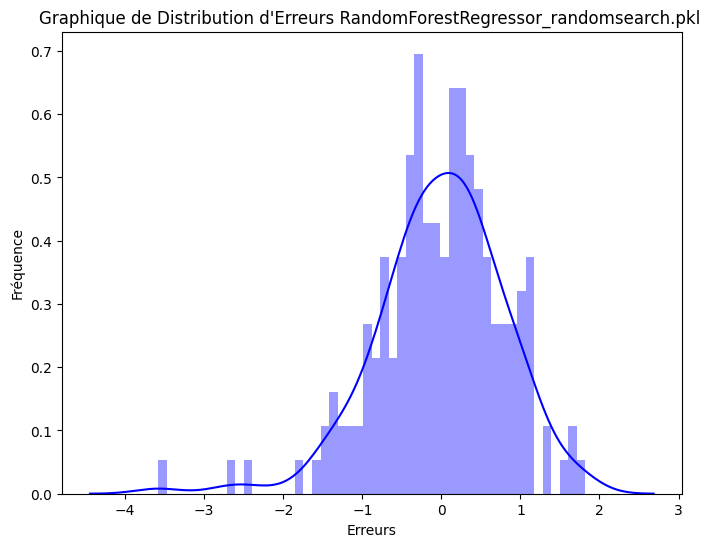

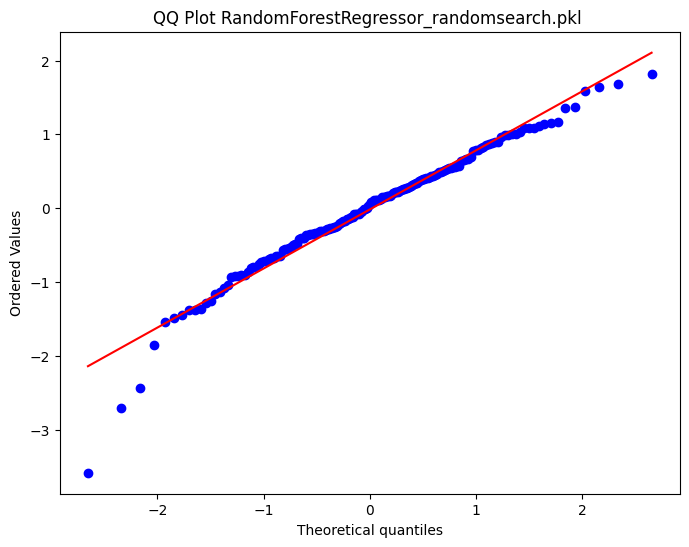

Métrique de performance pour le modèle RandomForestRegressor_standard.pkl :
R²: 0.6434590791525753
RMSE: 0.8313878436399529
MAE: 0.6083364036193284
MSE: 0.6912057465522908


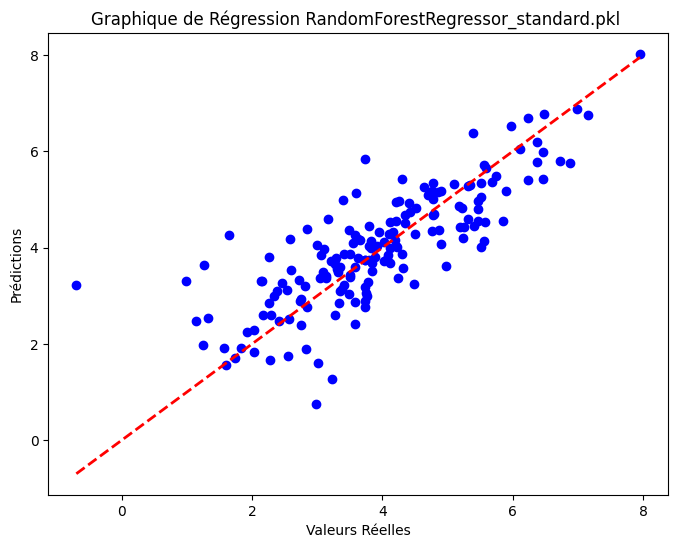

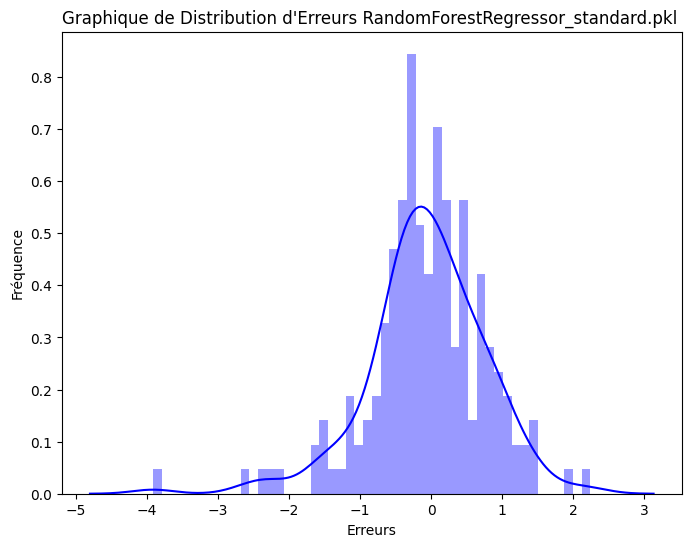

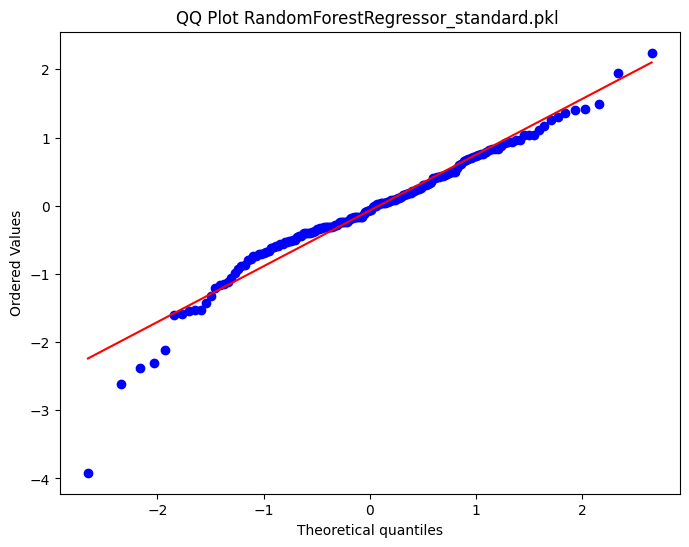

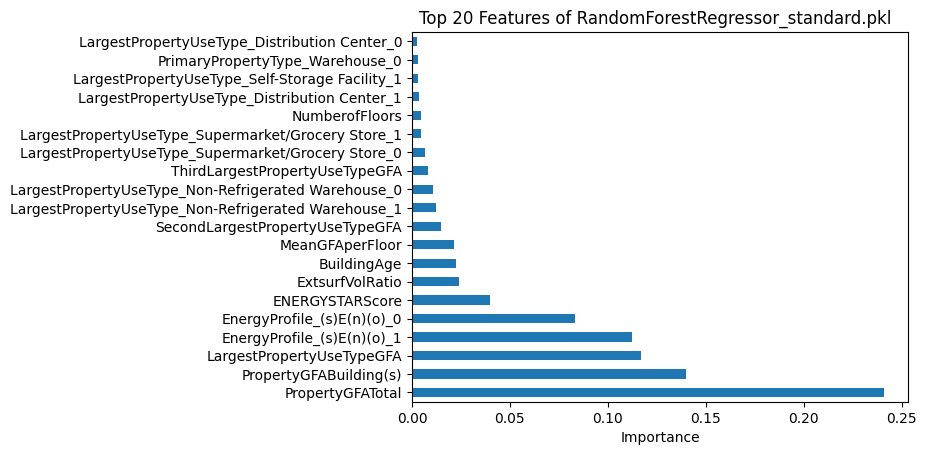

Métrique de performance pour le modèle Ridge_gridsearch.pkl :
R²: 0.4794089459073042
RMSE: 1.0046096130648425
MAE: 0.7685846233845731
MSE: 1.0092404746622925


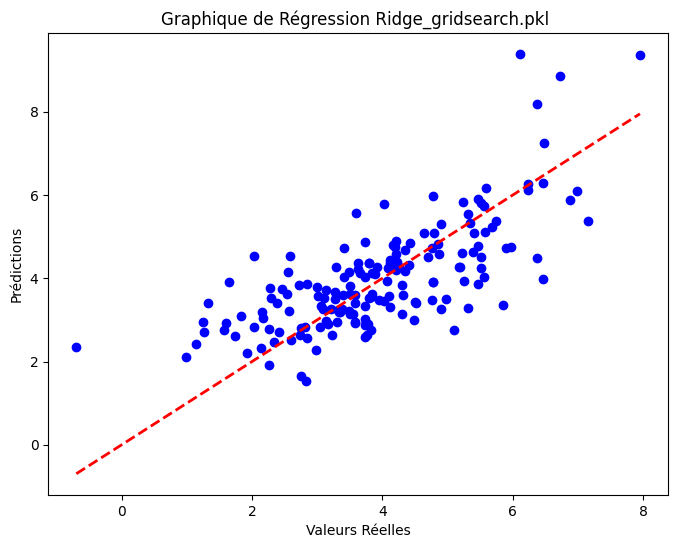

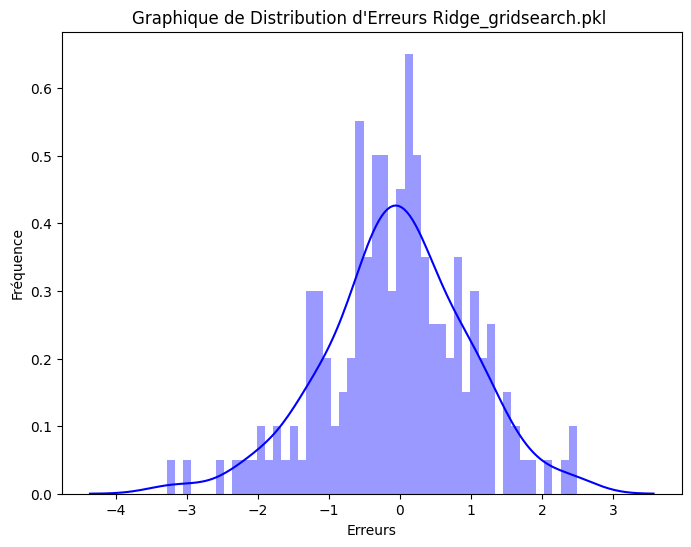

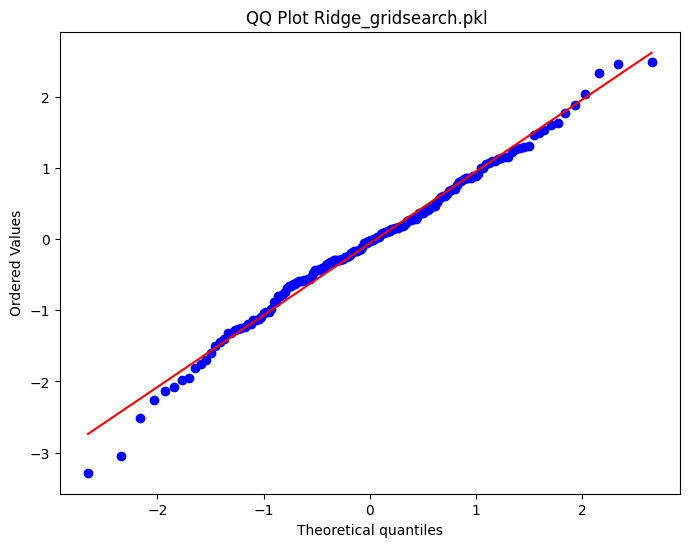

Métrique de performance pour le modèle Ridge_randomsearch.pkl :
R²: 0.4794089459073042
RMSE: 1.0046096130648425
MAE: 0.7685846233845731
MSE: 1.0092404746622925


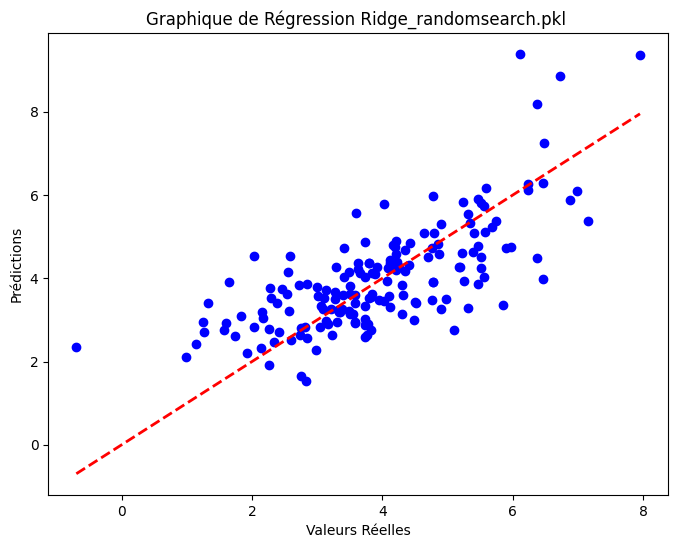

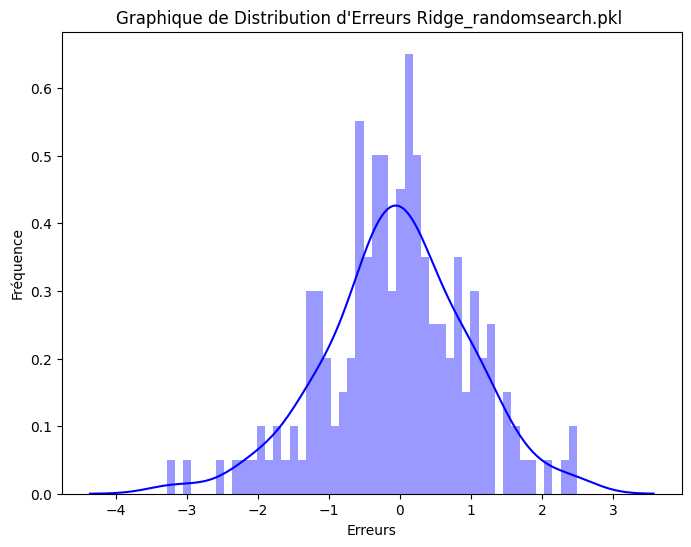

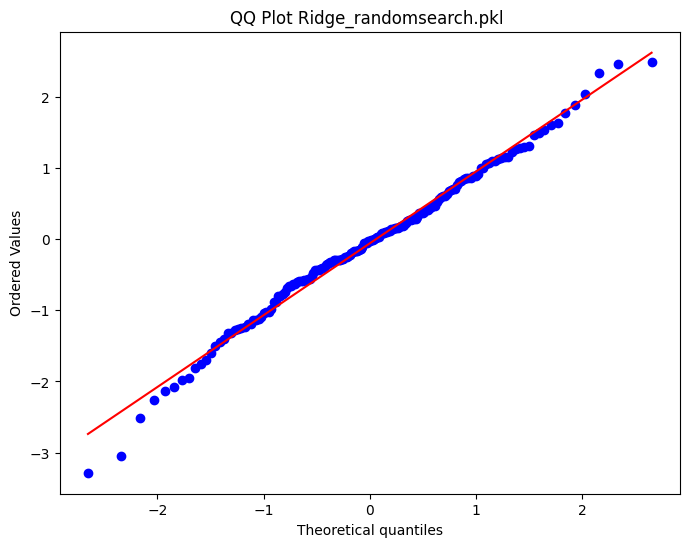

Métrique de performance pour le modèle Ridge_standard.pkl :
R²: 0.4794089459073042
RMSE: 1.0046096130648425
MAE: 0.7685846233845731
MSE: 1.0092404746622925


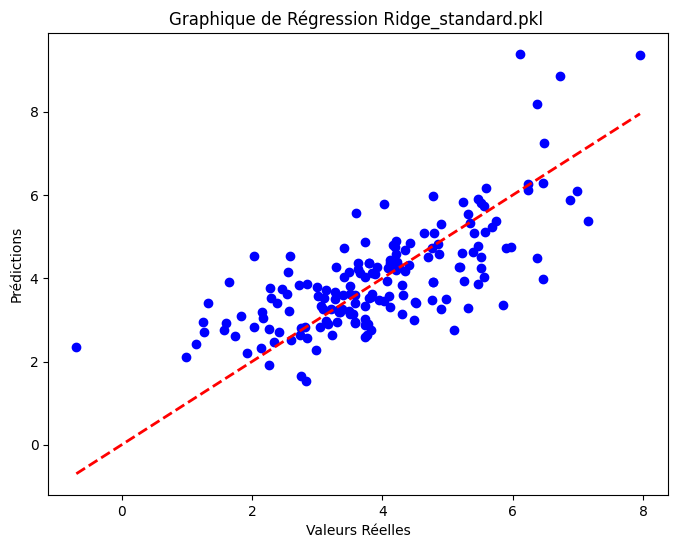

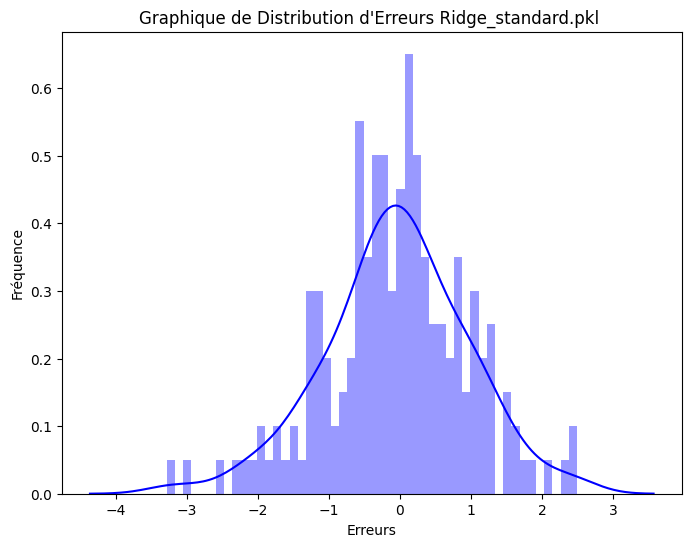

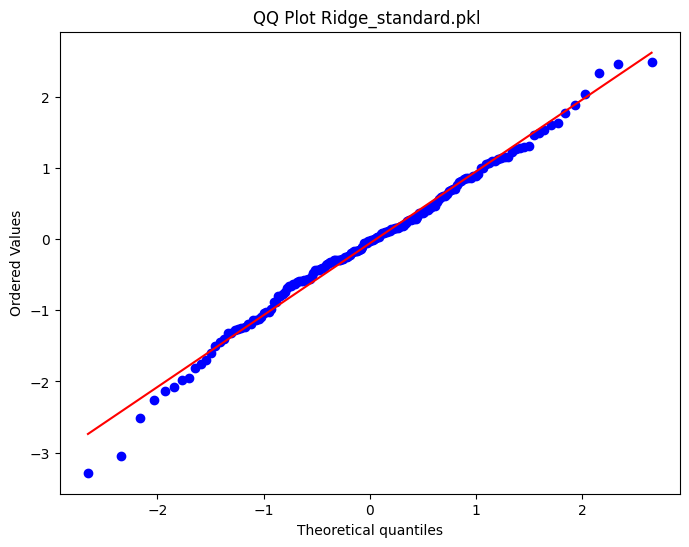

Métrique de performance pour le modèle SVR_gridsearch.pkl :
R²: 0.6868404890511587
RMSE: 0.7791692096549465
MAE: 0.5847074415078479
MSE: 0.6071046572743141


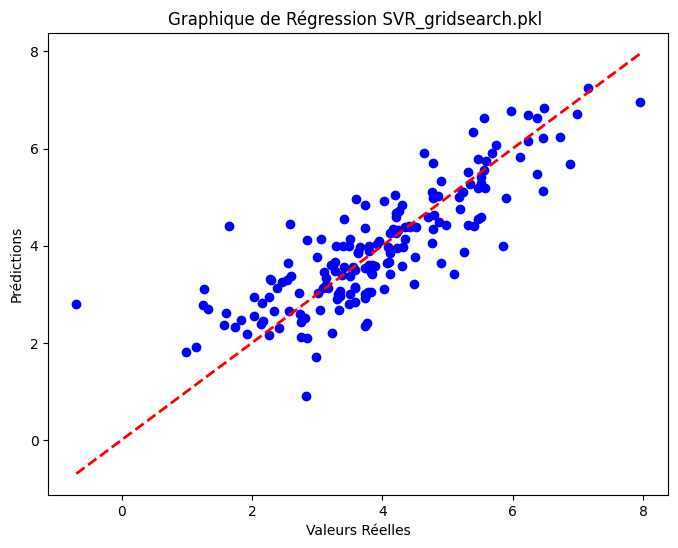

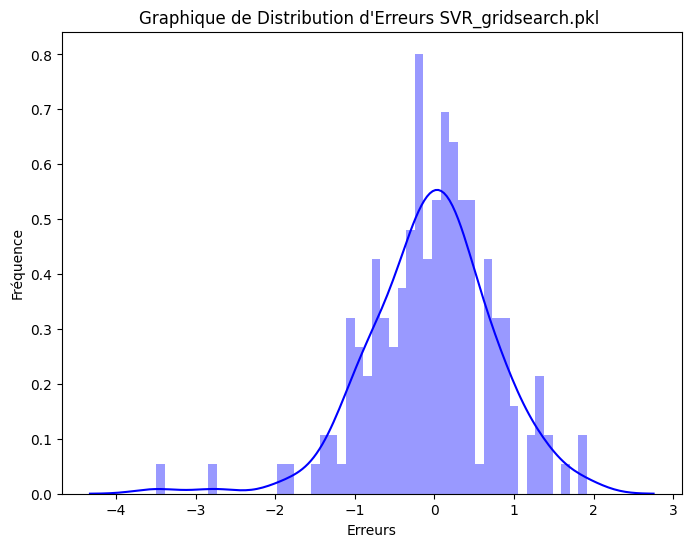

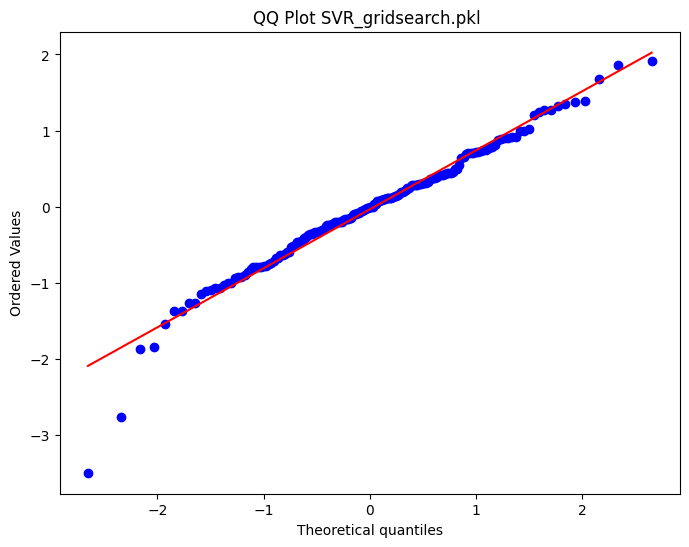

Métrique de performance pour le modèle SVR_randomsearch.pkl :
R²: 0.6884411505432336
RMSE: 0.7771753632493008
MAE: 0.5886785206787176
MSE: 0.6040015452416826


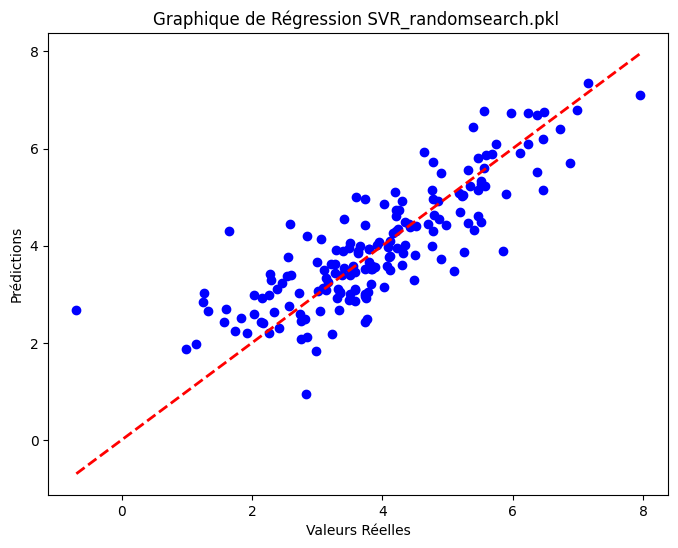

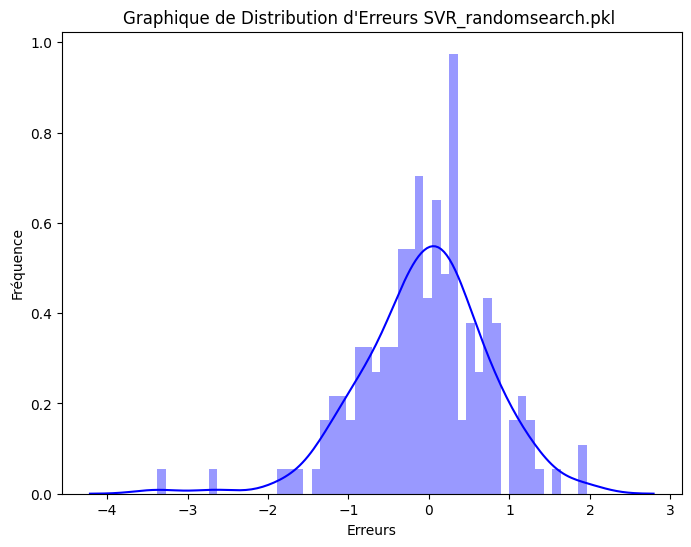

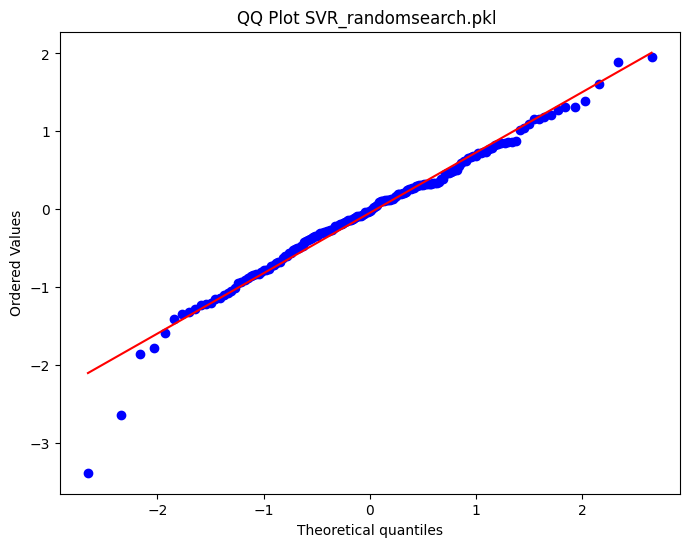

Métrique de performance pour le modèle SVR_standard.pkl :
R²: 0.6588375710041745
RMSE: 0.8132603106908907
MAE: 0.6096938400128816
MSE: 0.661392332945044


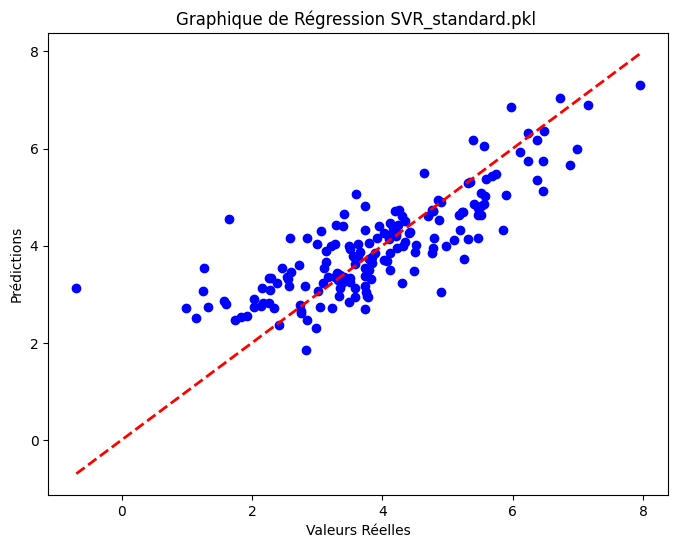

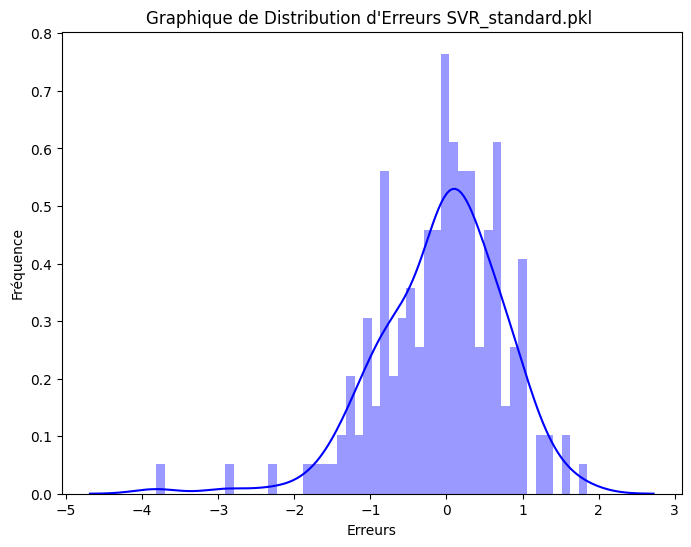

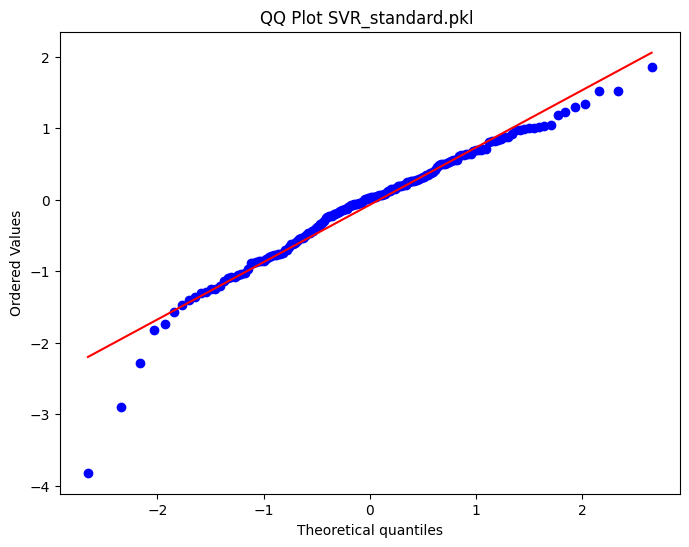

In [18]:
loaded_models = load_and_evaluate_models('../DATA/pickle/TotalGHGEmissions/withoutlieaires/withENERGYSTARScore/', X_test, y_test, evaluate_model_performance)

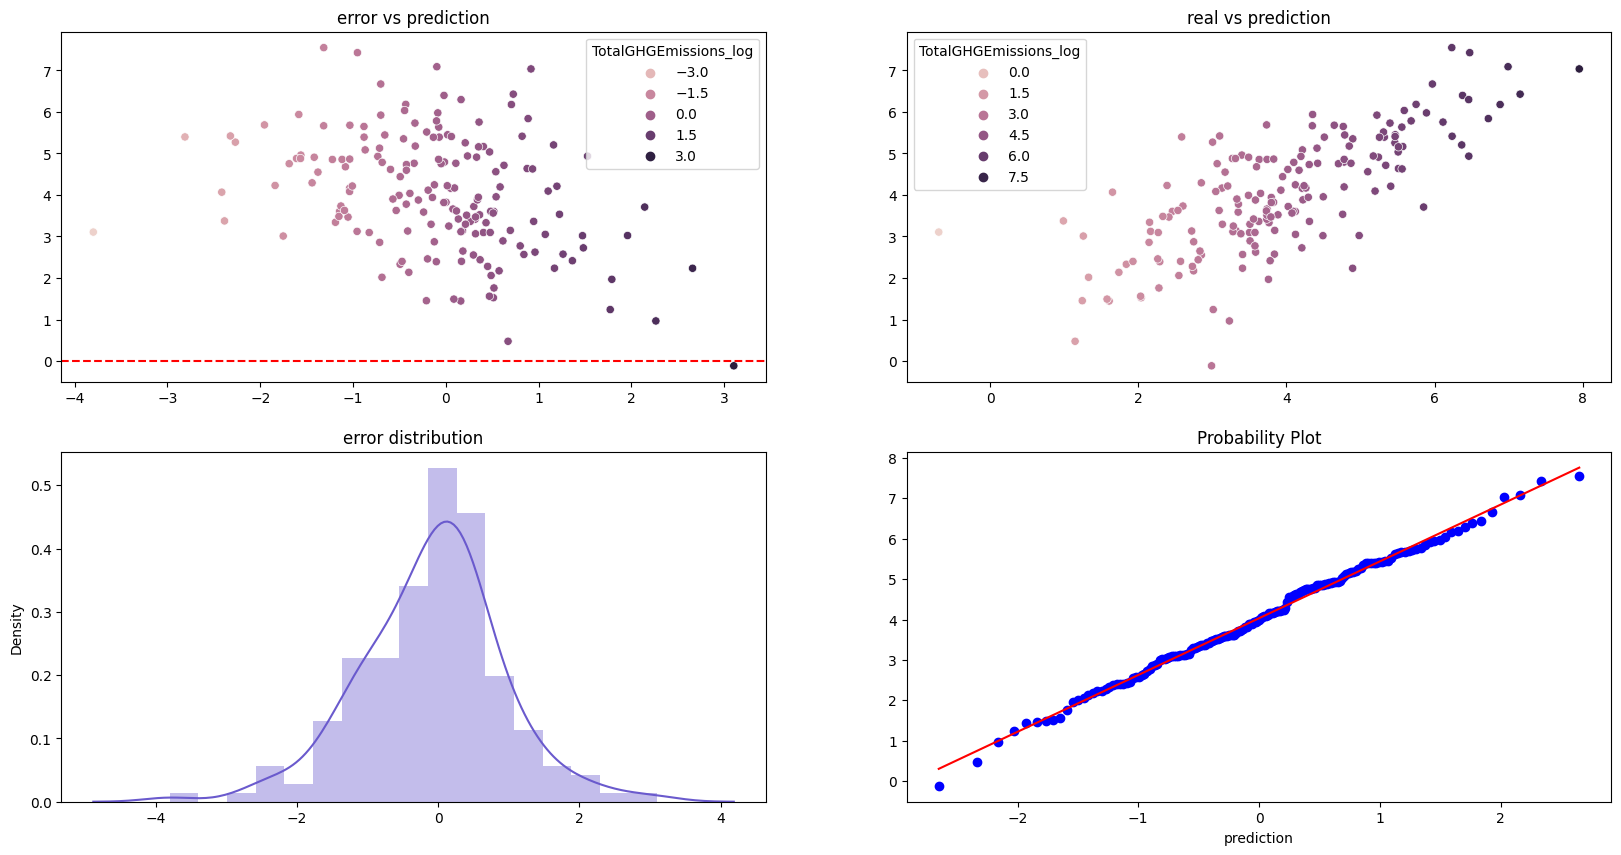

In [19]:
regression_visualizers(get_model='GradientBoostingRegressor_gridsearch', X_test=X_test, y_test=y_test, get_folder='../DATA/pickle/TotalGHGEmissions/withoutlieaires/withENERGYSTARScore/')

### Recherche de modèles de prédiction pour la consommation CO2 (TotalGHGEmissions) with ENERGYSTARScore and without  outlieares 

## KDTree est utiliser pour repérer les valeurs aberrantes multivariées 

In [20]:
df.shape

(863, 66)

In [21]:
data_cleaned = remove_outliers_with_kdtree(df, k=6, threshold_multiplier=1.5,numerical_columns=prop_Q_cols+target_cols,categorical_columns=prop_Q_cols)

In [22]:
data_cleaned.shape

(854, 67)

In [23]:
X_train, X_test, y_train, y_test = data_preprocessing2(data_cleaned,prop_C_cols,prop_Q_cols,'TotalGHGEmissions_log',0.2)
display(X_test.shape)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/TotalGHGEmissions/withoutoutlinears/withENERGYSTARScore/')

(171, 251)

Comparative table of models…


In [24]:
compar_results_energy[compar_results_energy.index.str.contains('R²')]

extratree     dummy                      lr    ridge  \
Standard R²      0.595688 -0.004932 -13181363034632861696.0  0.67358   
GridSearch R²    0.595552 -0.004932                0.532153  0.67358   
RandomSearch R²  0.599231 -0.004932                0.532153  0.67358   

                    lasso   elastic       knn       svr       rfr gradboost  
Standard R²     -0.004932  0.098437  0.503299  0.698752  0.610119  0.701178  
GridSearch R²    0.689577  0.652438  0.503299  0.713575  0.632178   0.38089  
RandomSearch R²  0.689577  0.652438  0.503299  0.713575  0.632178   0.38089

### Recherche de modèles de prédiction pour la consommation CO2 (TotalGHGEmissions) without  ENERGYSTARScore and without  outlieares 

In [25]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # ,

In [26]:
X_train, X_test, y_train, y_test = data_preprocessing2(data_cleaned,prop_C_cols,prop_Q_cols,'TotalGHGEmissions_log',0.2)
display(X_test.shape)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/TotalGHGEmissions/withoutoutlinears/withoutENERGYSTARScore/')

(171, 250)

Comparative table of models…


In [27]:
compar_results_energy[compar_results_energy.index.str.contains('R²')]

extratree     dummy                      lr     ridge  \
Standard R²      0.582773 -0.004932 -64390983375525584896.0  0.610441   
GridSearch R²    0.585562 -0.004932                0.532153  0.610441   
RandomSearch R²  0.600407 -0.004932                0.532153  0.610441   

                    lasso   elastic       knn       svr       rfr gradboost  
Standard R²     -0.004932  0.098437  0.425186   0.64396  0.582298  0.668429  
GridSearch R²    0.632513  0.599385  0.413573    0.6284  0.611932  0.338765  
RandomSearch R²  0.632513  0.599385  0.413573  0.621858  0.611932  0.338765

#### Conclusion

Dans le domaine des performances énergétiques des bâtiments de Seattle, il est clairement évident qu'une approche basée sur les algorithmes ensemblistes surpasse les méthodes de prédiction simples.

Au cours de cette étude, nous avons mis en lumière les performances d'un puissant meta-algorithme d'apprentissage ensembliste : le gradboost  ajusté par validation croisée. Ce modèle a démontré une stabilité et une précision exceptionnelles, éliminant ainsi tout risque de surapprentissage.

Il est important de souligner que ce modèle d'apprentissage supervisé est spécifiquement adapté à notre problème métier. Son utilisation permettrait d'éviter les relevés de consommation annuels, entraînant ainsi une réduction significative des coûts, de la charge de travail liée aux tâches fastidieuses et des risques de fuites de données, entre autres avantages.

En ce qui concerne l'utilité de l'"ENERGY STAR Score" dans la prédiction des émissions de CO2, nos résultats indiquent que cet indicateur  contribue  significativement à l'amélioration des prédictions 
Axes Possibles d'Amélioration

Il existe des opportunités d'amélioration significatives pour nos futures études. Initialement, notre échantillon de données contenait des variables importantes, cependant, il serait bénéfique de l'enrichir davantage. L'ajout de caractéristiques spécifiques telles que les propriétés des isolants thermiques des bâtiments, le type d'éclairage, ou même des données météorologiques pourraient apporter une profondeur supplémentaire à notre analyse. Ce processus d'enrichissement des caractéristiques pourrait potentiellement améliorer la précision de nos modèles et conduire à des prédictions encore plus fiables.
